# ColBERT and Single Vector Index Benchmarking

This notebook benchmarks the performance of the ColBERT (late interaction) and Single Vector Index (no interaction) implementation, which provides this particular search method:
1. **Near-Vector Search** - Uses pre-computed vectors for similarity search

**Late interaction** refers to the ColBERT architecture's approach where the interaction between query and document tokens occurs at the final stage of retrieval. This method:

1. Encodes query and document tokens separately
2. Stores token-level representations for documents
3. Performs token-to-token matching during search
4. Enables more fine-grained relevance assessment
5. Balances accuracy and efficiency in large-scale retrieval tasks

This approach allows for more nuanced similarity calculations compared to single-vector methods, potentially improving search quality at the cost of increased computational complexity.


**Single Vector Index (no interaction)** is generally faster for indexing and retrieval due to its simpler architecture:

1. Represents each document as a single vector
2. Performs straightforward vector similarity calculations
3. Requires less storage and computational resources
4. Offers quicker indexing and search times
5. Trades some accuracy for improved efficiency

This approach is well-suited for applications where speed is a priority and the loss in nuanced matching is acceptable.

We'll evaluate this search method using standard information retrieval metrics:
- **NDCG (Normalized Discounted Cumulative Gain)** - Measures ranking quality
- **MAP (Mean Average Precision)** - Measures retrieval performance
- **Precision** - Measures the fraction of retrieved documents that are relevant
- **Recall** - Measures the fraction of relevant documents that are retrieved

This notebook uses the test data from `test_chunk.csv` and `test_question.csv` files.

# Recommendation
Based on our experiments, we recommend using Weaviate with ColBERT embeddings for production-scale semantic search applications due to:
- Superior search accuracy through late-interaction architecture
- Efficient query time performance with multi-vector approach
- Flexible deployment options

However, for applications where indexing speed is critical and slight accuracy trade-offs are acceptable, the single vector approach may be more suitable. Consider your specific use case requirements when choosing between these approaches.

# Document
1. [ColBERT Multivector Search - Spreadsheets](https://docs.google.com/spreadsheets/d/1cGTGAGfvuSKkaBkd_5LgZnr7nyccG6F60b16HGGzCl0/edit?gid=0#gid=0)
2. [ColBERT Text Embedding Using JinaAI In Weaviate Exploration](https://docs.google.com/document/d/1EysjPSFZRZXXOHZ9Mi5vhLYl7iFk2XSan0HW1bfDlho/edit?tab=t.0#heading=h.6dflisl7td21)

## Setup Environment
- Weaviate client (weaviate-client==4.14.1): For interacting with Weaviate vector database
- BEIR: For information retrieval benchmarks
- LangChain: For building applications with LLMs
- Weaviate: Vector database
- LangChain Community: Extensions for LangChain
- python-dotenv: For loading environment variables
- matplotlib: For data visualization
- seaborn: For statistical data visualization
- pandas: For data manipulation and analysis
- OpenAI: API client for OpenAI services


In [22]:
!pip install "weaviate-client==4.14.1" -q
!pip install beir -q
!pip install langchain -q
!pip install weaviate -q
!pip install -U langchain-community -q
!pip install python-dotenv -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install pandas -q
!pip install openai -q
!pip install psutil -q

In [22]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Literal
from beir.retrieval.evaluation import EvaluateRetrieval
import requests
from functools import wraps

import psutil

import weaviate
from weaviate.classes.config import Configure, Property, DataType
from weaviate.classes.init import Auth
from weaviate.util import generate_uuid5

from openai import OpenAI

import time

# Constants
BEIR_K_TO_CHECK = [1, 3, 5, 10]
TOP_K_TO_CHECK = 10
DATA_DIR = "./data"
RESULTS_DIR = "./results"

# Create results directory if it doesn't exist
os.makedirs(RESULTS_DIR, exist_ok=True)

# Memory Monitoring Implementation

This code implements a comprehensive memory monitoring system with two main components:

## 1. MemoryMonitor Class

The [MemoryMonitor](cci:2://file:///home/glenn-s-santoso/git/work/gen-ai-exploration/vectordb_exploration/Weaviate/colpal-colbert-colpali-late-interaction/benchmarking/memory_measurement.py:7:0-65:18) class tracks memory usage of a Python process over time:

- **Initialization**: Creates a monitor for the current process (or a specified process ID)
- **Memory Measurement**: Uses `psutil` to access the Resident Set Size (RSS) of the process, which represents the actual physical memory used
- **Sampling**: Records memory usage at specific points in time
- **Data Collection**: Stores memory samples and timestamps in lists for analysis
- **Key Metrics**: Tracks baseline memory (starting point), peak memory (maximum usage), and memory increase (difference between peak and baseline)
- **Visualization**: Provides a plotting method to visualize memory usage over time with clear indicators for baseline and peak usage

## 2. measure_memory Decorator

The [measure_memory](cci:1://file:///home/glenn-s-santoso/git/work/gen-ai-exploration/vectordb_exploration/Weaviate/colpal-colbert-colpali-late-interaction/benchmarking/memory_measurement.py:67:0-141:30) decorator function allows easy application of memory monitoring to any function:

- **Decorator Pattern**: Uses Python's decorator pattern to wrap a function with memory monitoring
- **Background Sampling**: Creates a separate thread that continuously samples memory usage at regular intervals (default: every 0.1 seconds)
- **Thread Safety**: Uses a threading Event to safely stop the sampling thread when the function completes
- **Comprehensive Reporting**: Prints detailed memory statistics including baseline, peak, and increase
- **Visualization**: Automatically generates and optionally saves a plot of memory usage over time
- **Error Handling**: Ensures proper cleanup of resources even if the monitored function raises an exception

## Usage in Benchmarking

This implementation is particularly useful for benchmarking because:

1. It provides accurate measurements of memory consumption during both indexing and querying operations
2. It captures the peak memory usage, which is critical for understanding resource requirements
3. It shows memory usage patterns over time, revealing how memory grows during different phases of processing
4. It generates visualizations that can be included in reports to demonstrate infrastructure implications

In [ ]:
class MemoryMonitor:
    """Monitor memory usage during operations."""
    
    def __init__(self, process_id=None):
        """Initialize with process ID (defaults to current process)."""
        self.process = psutil.Process(process_id if process_id else os.getpid())
        self.memory_samples = []
        self.timestamps = []
        self.start_time = None
        self.peak_memory = 0
        self.baseline_memory = self._get_memory_mb()
    
    def _get_memory_mb(self):
        """Get current memory usage in MB."""
        return self.process.memory_info().rss / (1024 * 1024)
    
    def start(self):
        """Start monitoring memory."""
        self.memory_samples = []
        self.timestamps = []
        self.start_time = time.time()
        self.peak_memory = 0
        self.baseline_memory = self._get_memory_mb()
        return self
    
    def sample(self):
        """Take a memory sample."""
        current_memory = self._get_memory_mb()
        self.memory_samples.append(current_memory)
        self.timestamps.append(time.time() - self.start_time)
        self.peak_memory = max(self.peak_memory, current_memory)
    
    def stop(self):
        """Stop monitoring and return results."""
        self.sample()  # Take final sample
        return {
            'baseline_mb': self.baseline_memory,
            'peak_mb': self.peak_memory,
            'increase_mb': self.peak_memory - self.baseline_memory,
            'samples': list(zip(self.timestamps, self.memory_samples))
        }
    
    def plot(self, title="Memory Usage Over Time", save_path=None):
        """Plot memory usage over time."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.timestamps, self.memory_samples)
        plt.axhline(y=self.baseline_memory, color='r', linestyle='--', label=f'Baseline ({self.baseline_memory:.2f} MB)')
        plt.axhline(y=self.peak_memory, color='g', linestyle='--', label=f'Peak ({self.peak_memory:.2f} MB)')
        plt.title(title)
        plt.xlabel("Time (seconds)")
        plt.ylabel("Memory Usage (MB)")
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        if save_path:
            plt.savefig(save_path)
            print(f"Memory plot saved to {save_path}")
        
        plt.show()

def measure_memory(func=None, *, label=None, sample_interval=0.1, plot=True, save_plot=None):
    """
    Decorator to measure memory usage during function execution.
    
    Args:
        func: The function to decorate
        label: Custom label for the measurement
        sample_interval: How often to sample memory (seconds)
        plot: Whether to plot memory usage
        save_plot: Path to save the plot
        
    Returns:
        Decorated function that measures memory
    """
    def decorator(f):
        @wraps(f)
        def wrapper(*args, **kwargs):
            # Initialize monitor
            monitor = MemoryMonitor().start()
            
            # Start background sampling
            import threading
            stop_sampling = threading.Event()
            
            def sample_memory():
                while not stop_sampling.is_set():
                    monitor.sample()
                    time.sleep(sample_interval)
            
            sampling_thread = threading.Thread(target=sample_memory)
            sampling_thread.daemon = True
            sampling_thread.start()
            
            try:
                # Run the function
                start_time = time.time()
                result = f(*args, **kwargs)
                execution_time = time.time() - start_time
                
                # Stop sampling
                stop_sampling.set()
                sampling_thread.join(timeout=1.0)
                
                # Get memory stats
                memory_stats = monitor.stop()
                
                # Display results
                func_name = label or f.__name__
                print(f"\n{'='*50}")
                print(f"Memory Usage for {func_name}:")
                print(f"{'='*50}")
                print(f"Baseline Memory: {memory_stats['baseline_mb']:.2f} MB")
                print(f"Peak Memory: {memory_stats['peak_mb']:.2f} MB")
                print(f"Memory Increase: {memory_stats['increase_mb']:.2f} MB")
                print(f"Execution Time: {execution_time:.2f} seconds")
                print(f"{'='*50}\n")
                
                # Plot if requested
                if plot:
                    plot_title = f"Memory Usage: {func_name}"
                    monitor.plot(title=plot_title, save_path=f"./results/{save_plot}")
                
                return result
            except Exception as e:
                stop_sampling.set()
                if sampling_thread.is_alive():
                    sampling_thread.join(timeout=1.0)
                raise e
        
        return wrapper
    
    if func is None:
        return decorator
    else:
        return decorator(func)


# Initialize Weaviate client

Based on the code snippet, I can explain how to obtain the necessary API keys for this vector search implementation:

## How to Get the Required API Keys

The code uses four essential API keys that need to be set up:

### 1. Weaviate URL and API Key

- **Weaviate URL**: You need to create a Weaviate Cloud Services (WCS) account
  - Sign up at https://console.weaviate.cloud/
  - Create a new cluster
  - The URL will be provided in your cluster details (typically in format: https://your-cluster-id.weaviate.network)
- **Weaviate API Key**:
  - Generated when you create a cluster in Weaviate Cloud
  - Available in your cluster settings under "API Keys"

### 2. JinaAI API Key

- Required for using the jina-colbert-v2 embeddings model
- Sign up at https://jina.ai/
- Navigate to your account dashboard
- Create an API key in the API keys section

### 3. OpenAI API Key

- Required for using the text-embedding-3-small model
- Sign up at https://platform.openai.com/
- Navigate to "API Keys" in your account settings
- Create a new secret key

## Setting Up the Keys

Once you have all these keys, insert every each key into the corresponding environment variable in the code snippet.
```python
os.environ["WEAVIATE_URL"] = "your-weaviate-url"
os.environ["WEAVIATE_API_KEY"] = "your-weaviate-api-key"
os.environ["JINAAI_API_KEY"] = "your-jinaai-api-key"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"
```


In [ ]:
# Initialize Weaviate client
os.environ["WEAVIATE_URL"] = "your_weaviate_url"
os.environ["WEAVIATE_API_KEY"] = "your_weaviate_api_key"
os.environ["JINAAI_API_KEY"] = "your_jinaai_api_key"
os.environ["OPENAI_API_KEY"] = "your_openai_api_key"

jinaai_key=os.getenv("JINAAI_API_KEY")
openai_key=os.getenv("OPENAI_API_KEY")

client = weaviate.connect_to_weaviate_cloud(
    cluster_url=os.getenv("WEAVIATE_URL"),
    auth_credentials=Auth.api_key(os.getenv("WEAVIATE_API_KEY")),
    headers={
        'X-JinaAI-Api-Key': jinaai_key,
        'X-OpenAI-Api-Key': openai_key
    }
)

openai_client = OpenAI(api_key=openai_key)

# Weaviate Client to Create ColBERT Collection
This code block implements a benchmarking framework for evaluating ColBERT's late-interaction architecture in Weaviate. The implementation focuses on comparing multi-vector (ColBERT) and single-vector embedding approaches for semantic search.

### Key Components
- **Collection Setup**: Creates a Weaviate collection configured for ColBERT embeddings using the Jina AI model "jina-colbert-v2". The collection stores both document content and metadata.
- **Document Processing**: Handles importing documents into Weaviate with efficient batch processing, generating multi-vector embeddings for each document.
- **Search Implementation**: Provides three search methods:
  - Near-text search
  - Hybrid search
  - Near-vector search (using pre-computed embeddings)
- **Performance Measurement**: Tracks and reports key performance metrics including:
  - Indexing time
  - Query time
  - Search accuracy

### Architecture
The implementation uses a late-interaction architecture where:

- Documents are represented as multiple token-level embeddings rather than a single document embedding
- Queries are similarly encoded as multiple vectors
- Similarity is computed through token-level interactions between query and document vectors

This approach allows for more precise matching and better handling of semantic relationships, particularly for longer documents where important information might be diluted in a single-vector representation.

### Integration
The code integrates with:

- Weaviate vector database for storage and retrieval
- Jina AI API for ColBERT embeddings
- OpenAI API for comparison with single-vector embeddings

In [ ]:
collection_name = "New_Again_New_ColBERT_Benchmarking"
collection = None


def create_collection():
    """Create a Weaviate collection for ColBERT embeddings."""
    global collection_name, client, collection

    if client.collections.exists(collection_name):
        collection = client.collections.get(collection_name)
        print(f"Collection {collection_name} already exists, using existing collection")
        return collection
    else:
        collection = client.collections.create(
            collection_name,
            vectorizer_config=[
                Configure.NamedVectors.text2colbert_jinaai(
                    name="multi_vector",
                    source_properties=["text"],
                    model="jina-colbert-v2"
                ),
            ],
            properties=[
                Property(name="text", data_type=DataType.TEXT),
                Property(name="chunk_id", data_type=DataType.TEXT),
                Property(name="source", data_type=DataType.TEXT),
                Property(name="title", data_type=DataType.TEXT),
                Property(name="keywords", data_type=DataType.TEXT),
            ],
        )

        print(f"Created collection: {collection_name}")
        return collection


def add_documents(documents: List[Dict[str, Any]]):
    """Add documents with token embeddings to the collection"""
    global collection_name, client, collection
    start_time = time.time()

    collection = client.collections.get(collection_name)

    existing_docs = collection.query.fetch_objects(limit=100, include_vector=True)

    if existing_docs.objects and len(existing_docs.objects) >= len(documents):
        print(f"Documents already exist in collection, skipping import")
        return

    with collection.batch.fixed_size(batch_size=10) as batch:
        for doc in documents:
            batch.add_object(
                properties={
                    "text": doc["text"],
                    "chunk_id": doc["id"],
                    "source": doc.get("source", ""),
                    "title": doc.get("title", ""),
                    "keywords": doc.get("keywords", ""),
                },
                uuid=generate_uuid5(doc["id"]),
            )

    if collection.batch.failed_objects:
        print(f"Number of failed imports: {len(collection.batch.failed_objects)}")
        print(f"First failed object: {collection.batch.failed_objects[0]}")

    end_time = time.time()
    print(f"Added {len(documents)} documents to the collection in {end_time - start_time:.2f} seconds")


def confirm_embedding_shape():
    """Confirm the shape of the embeddings in the collection."""
    global collection, client
    response = collection.query.fetch_objects(limit=3, include_vector=True)

    print(f"Embedding data type: {type(response.objects[0].vector['multi_vector'])}")
    print(f"Embedding first element type: {type(response.objects[0].vector['multi_vector'][0])}")
    for i in range(min(3, len(response.objects))):
        print(f"This embedding's shape is ({len(response.objects[i].vector['multi_vector'])}, {len(response.objects[i].vector['multi_vector'][0])})")


def get_colbert_embedding(source_text: str) -> List[List[float]]:
    """Get ColBERT embeddings from Jina AI API"""
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {jinaai_key}",
    }

    data = {
        "model": "jina-colbert-v2",
        "dimensions": 128,
        "input_type": "document",
        "embedding_type": "float",
        "input": [source_text],
    }

    try:
        response = requests.post(
            "https://api.jina.ai/v1/multi-vector", 
            headers=headers, 
            data=json.dumps(data)
        )
        response.raise_for_status()  # Raise an error for bad status codes
        
        response_data = json.loads(response.text)
        embedding = response_data["data"][0]["embeddings"]
        
        if not isinstance(embedding, list):
            raise ValueError(f"Expected list embedding, got {type(embedding)}")
            
        return embedding
    except Exception as e:
        print(f"Error getting embedding: {str(e)}")
        return None


@measure_memory(label="Search ColBERT Near Vector", plot=True, save_plot="search_colbert_near_vector.png")
def search(query: str, type: Literal["near-text", "hybrid", "near-vector"]):
    """Search the collection using the specified search type."""
    global collection, client
    
    start_time = time.time()  # Start timing
    
    if type == 'near-text':
        response = collection.query.near_text(
            query,
            target_vector="multi_vector",
        )
    elif type == 'hybrid':
        response = collection.query.hybrid(
            query,
            target_vector="multi_vector",
        )
    elif type == 'near-vector':
        # Get embedding time is not included in search time
        embedding = get_colbert_embedding(query)
        if embedding is None:
            print("Failed to get embedding, skipping search")
            return None, 0  # Return 0 for search time
        
        # Start timing after embedding is generated
        start_time = time.time()  # Reset timing for actual search
        response = collection.query.near_vector(
            near_vector=embedding,
            target_vector="multi_vector",
        )
    
    end_time = time.time()  # End timing
    search_time = end_time - start_time
    
    return response, search_time



## Weaviate Client to Create Single Vector Collection

This code block implements a traditional single vector embedding approach for semantic search in Weaviate. It serves as a comparison baseline for benchmarking against the ColBERT multi-vector implementation.

### Key Components
- **Collection Setup**: Creates a Weaviate collection configured for single vector embeddings using OpenAI's `text-embedding-3-small` model. The collection organizes content and metadata in a structured schema.
- **Document Processing**: Handles importing documents into Weaviate with batch processing, generating single vector embeddings for each document.
- **Embedding Generation**: Creates dense vector representations of text using OpenAI's embedding model.
- **Search Implementation**: Provides near-vector search functionality using pre-computed embeddings.
- **Performance Measurement**: Tracks and reports key performance metrics for benchmarking comparison.

### Architecture
The implementation uses an early embedding (no interaction) architecture where:

- Documents are represented as a single dense vector embedding
- Queries are similarly encoded as single vectors
- Similarity is computed through direct vector-to-vector comparison

This approach represents the traditional vector search method commonly used in production systems, providing a baseline to evaluate the benefits and trade-offs of the more complex late-interaction architecture.

### Integration
The code integrates with:

- Weaviate vector database for storage and retrieval
- OpenAI API for generating text embeddings
- Benchmarking framework for comparative analysis with multi-vector approaches

In [ ]:
single_vector_collection_name = "Single_Vector_Benchmark"
single_vector_collection = None

def create_single_vector_collection():
    global single_vector_collection
    if client.collections.exists(single_vector_collection_name):
        client.collections.delete(single_vector_collection_name)
    
    single_vector_collection = client.collections.create(
        single_vector_collection_name,
        vectorizer_config=Configure.Vectorizer.text2vec_openai(  # <-- SINGLE vectorizer, not multi
            model="text-embedding-3-small"                      # Example: OpenAI embedding model
        ),
        properties=[
            Property(
                name="page_content",
                data_type=DataType.TEXT
            ),
            Property(
                name="metadata",
                data_type=DataType.OBJECT,
                nested_properties=[
                    Property(name="title", data_type=DataType.TEXT),
                    Property(name="chunkid", data_type=DataType.TEXT),
                    Property(name="keywords", data_type=DataType.TEXT),
                    Property(name="source", data_type=DataType.TEXT),
                ]
            )
        ],
    )

    return single_vector_collection

def add_documents_to_single_vector_collection(documents: List[Dict[str, Any]]):
    """Add documents with token embeddings to the collection"""
    global client, single_vector_collection_name
    start_time = time.time()
    collection = client.collections.get(single_vector_collection_name)

    existing_docs = collection.query.fetch_objects(limit=100, include_vector=True)

    if existing_docs.objects and len(existing_docs.objects) >= len(documents):
        print(f"Documents already exist in collection, skipping import")
        return

    with collection.batch.fixed_size(batch_size=10) as batch:
        for doc in documents:
            batch.add_object(
                properties={
                    "page_content": doc["text"],
                    "metadata": {
                        "title": doc.get("title", ""),
                        "chunkid": doc["id"],
                        "keywords": doc.get("keywords", ""),
                        "source": doc.get("source", ""),
                    },
                },
                uuid=generate_uuid5(doc["id"]),
            )

    if collection.batch.failed_objects:
        print(f"Number of failed imports: {len(collection.batch.failed_objects)}")
        print(f"First failed object: {collection.batch.failed_objects[0]}")

    end_time = time.time()
    print(f"Added {len(documents)} documents to the collection in {end_time - start_time:.2f} seconds")

def get_dense_embedding(text):
    try:
        if not text or not isinstance(text, str):
            raise ValueError("Input text must be a non-empty string.")
        
        response = openai_client.embeddings.create(
            input=[text],
            model="text-embedding-3-small"
        )
        return response.data[0].embedding
    except Exception as e:
        print(f"An error occurred while generating the embedding: {e}")
        return None

@measure_memory(label="Search No Interaction Near Vector", plot=True, save_plot="search_no_interaction_near_vector.png")
def search_no_interaction_near_vector(collection, query):
    start_time = time.time()  # Start timing
    query_vector = get_dense_embedding(query)
    response = collection.query.near_vector(
        near_vector=query_vector,
        return_metadata=["distance"]
    )

    end_time = time.time()  # End timing
    search_time = end_time - start_time
    return response, search_time

    

## Define Evaluation Functions

This section implements standard information retrieval metrics to evaluate and compare the performance of different vector search methods. The evaluation framework provides quantitative measurements of search quality and efficiency.

### Key Metrics
- **NDCG (Normalized Discounted Cumulative Gain)**: Measures the quality of ranking, considering both relevance and position of results
- **MAP (Mean Average Precision)**: Evaluates retrieval performance across multiple queries
- **Precision**: Calculates the fraction of retrieved documents that are relevant
- **Recall**: Measures the fraction of relevant documents that are successfully retrieved
- **Query Time**: Records the time taken to execute search queries

### Implementation
The evaluation functions process search results against ground truth data to compute these metrics at different k values (top-k results). This allows for comprehensive analysis of how each search method performs at various result set sizes.

### Benchmarking Framework
These metrics form the foundation of the comparative analysis between:
- Early embedding (single vector) approach
- Late interaction (multi-vector/ColBERT) approach

The evaluation results provide quantitative evidence for determining which approach best suits different use cases based on accuracy requirements and performance constraints.

In [30]:
def get_retrieval_results_data(docs, relevant_ids):
    """
    Calculate retrieval metrics for a set of documents and relevant IDs.

    Args:
        docs: List of document objects returned by the search
        relevant_ids: List of relevant document IDs

    Returns:
        tuple: (target_chunk_count, target_chunk_rank)
    """
    target_chunk_count = 0
    target_chunk_rank = []

    for rank, doc in enumerate(docs, start=1):
        chunk_id = doc.get("chunk_id", None)
        if chunk_id in relevant_ids:
            target_chunk_count += 1
            target_chunk_rank.append(str(rank))

    target_chunk_count = f"{target_chunk_count} / {len(relevant_ids)}"
    target_chunk_rank = ", ".join(target_chunk_rank) if target_chunk_rank else "-"

    return target_chunk_count, target_chunk_rank

In [31]:
def display_scores(retrieved_contexts, ground_truth_contexts):
    """
    Display evaluation metrics for retrieved contexts.

    Args:
        retrieved_contexts: Dictionary of retrieved contexts
        ground_truth_contexts: Dictionary of ground truth contexts
    """
    evaluator = EvaluateRetrieval()

    ndcg, map_score, recall, precision = evaluator.evaluate(
        ground_truth_contexts, retrieved_contexts, BEIR_K_TO_CHECK
    )

    print("NDCG: ")
    pprint_score(ndcg)
    print("MAP: ")
    pprint_score(map_score)
    print("Recall: ")
    pprint_score(recall)
    print("Precision: ")
    pprint_score(precision)

    return {
        "ndcg": ndcg,
        "map": map_score,
        "recall": recall,
        "precision": precision
    }

def display_single_vector_scores(retrieved_contexts, ground_truth_contexts):
    """
    Display evaluation metrics for retrieved contexts.

    Args:
        retrieved_contexts: Dictionary of retrieved contexts
        ground_truth_contexts: Dictionary of ground truth contexts
    """
    # Check if retrieved_contexts is empty or malformed
    if not retrieved_contexts:
        print("WARNING: retrieved_contexts is empty!")
        return {"ndcg": {}, "map": {}, "recall": {}, "precision": {}}
    
    # Ensure all values in retrieved_contexts are numeric
    fixed_retrieved_contexts = {}
    for query, docs in retrieved_contexts.items():
        if not docs:  # Skip empty results
            continue
            
        # Check if the values are numeric
        try:
            fixed_docs = {doc_id: float(score) for doc_id, score in docs.items()}
            fixed_retrieved_contexts[query] = fixed_docs
        except (ValueError, TypeError) as e:
            try:
                if isinstance(docs, dict):
                    fixed_retrieved_contexts[query] = {doc_id: 1.0 - (i * 0.1) for i, doc_id in enumerate(docs.keys())}
                else:
                    print(f"Unexpected type for docs: {type(docs)}")
            except Exception as e2:
                print(f"Failed to fix: {e2}")
    
    try:
        evaluator = EvaluateRetrieval()
        ndcg, map_score, recall, precision = evaluator.evaluate(
            ground_truth_contexts, fixed_retrieved_contexts, BEIR_K_TO_CHECK
        )
        
        print("NDCG: ")
        pprint_score(ndcg)
        print("MAP: ")
        pprint_score(map_score)
        print("Recall: ")
        pprint_score(recall)
        print("Precision: ")
        pprint_score(precision)
        
        return {
            "ndcg": ndcg,
            "map": map_score,
            "recall": recall,
            "precision": precision
        }
    except Exception as e:
        print(f"Evaluation failed: {e}")
        print("This could be due to a mismatch in format between retrieved_contexts and what BEIR expects.")
        print("BEIR expects: {'query1': {'doc1': score1, 'doc2': score2, ...}, 'query2': {...}, ...}")
        
        # Return empty metrics as fallback
        return {"ndcg": {}, "map": {}, "recall": {}, "precision": {}}

In [32]:
def pprint_score(score):
    """Print score in a formatted way."""
    for key, value in score.items():
        print(f"  - {key} = {round(value, 2)}")

def get_single_vector_retrieved_contexts(docs):
    """
    Convert search results to a format suitable for evaluation.
    
    Args:
        docs: List of document objects returned by the search
        
    Returns:
        dict: Dictionary of retrieved contexts with scores
    """
    retrieved_contexts = {}
    current_score = 1.0
    interval = current_score / max(1, len(docs))
    
    for doc in docs:
        # Extract the chunk_id from the metadata
        if 'metadata' in doc and 'chunkid' in doc['metadata']:
            doc_id = doc['metadata']['chunkid']
            retrieved_contexts[doc_id] = float(current_score)  # Ensure score is float
            current_score -= interval
    
    return retrieved_contexts
    

def get_retrieved_contexts(docs):
    """
    Convert search results to a format suitable for evaluation.

    Args:
        docs: List of document objects returned by the search

    Returns:
        dict: Dictionary of retrieved contexts with scores
    """
    retrieved_contexts = {}
    current_score = 1.0
    interval = current_score / TOP_K_TO_CHECK
    for doc in docs:
        doc_id = doc.get("chunk_id", None)
        retrieved_contexts[doc_id] = current_score
        current_score -= interval
    return retrieved_contexts


## Load Test Data from CSV Files

The test data can be found [here](https://drive.google.com/drive/folders/1mvigRBchgpqZsyWNt4dEDb3AQpr6ERnT). We are using `test_chunk.csv` and `test_question.csv`. In case you don't have access to the drive, we have provided the data in the repository as well (check `data` folder).

In [33]:
def load_test_data():
    """
    Load test data from CSV files.

    Returns:
        tuple: (chunk_df, question_df, expected_chunk_dict, ground_truth_contexts)
    """
    # Load test data
    chunk_df = pd.read_csv(f"{DATA_DIR}/test_chunk.csv")
    question_df = pd.read_csv(f"{DATA_DIR}/test_question.csv")

    # Process question data
    expected_chunk_dict = {}
    ground_truth_contexts = {}

    for _, row in question_df.iterrows():
        question = row["Question"]
        question_id = row["No"]
        relevant_ids = row["Expected Chunk (Chunk ID)"].split("\n")

        expected_chunk_dict[question_id] = {
            "question": question,
            "relevant_ids": relevant_ids,
        }

        ground_truth_contexts[question] = {chunk_id: 1 for chunk_id in relevant_ids}

    return chunk_df, question_df, expected_chunk_dict, ground_truth_contexts

# Load the test data
chunk_df, question_df, expected_chunk_dict, ground_truth_contexts = load_test_data()

print(f"Loaded {len(chunk_df)} chunks and {len(question_df)} questions")

# Display sample of the data
print("\nSample chunks:")
display(chunk_df.head(3))

print("\nSample questions:")
display(question_df.head(3))

Loaded 1227 chunks and 50 questions

Sample chunks:


chunk_id  \
0  2102beb02097f521ed574355558ee65a-3   
1  1549da3ff63877201b7364d47887c370-1   
2  510157370ec05067d2cfc1ed94db3694-1   

                                              source  \
0  https://www.bca.co.id/id/informasi/Edukatips/2...   
1  https://www.bca.co.id/id/informasi/awas-modus/...   
2  https://www.bca.co.id/id/informasi/Edukatips/2...   

                                               title  \
0  BCA - Mau Renovasi Rumah? Ini Dia 5 Tips dan T...   
1  BCA - Waspada Malware! Ini Tips-nya Agar Terhi...   
2          BCA - Ngabuburit Seru Saat RamadanDiRumah   

                                             content  \
0  Tidak Boros Membeli Material\nLakukanlah riset...   
1  2023-06-07 | #AwasModus\nWaspada Malware! Ini ...   
2  Transfer ke Ibu di luar kota buat keperluan se...   

                                            keywords  
0  Harga material\nRiset mengenai harga material\...  
1  Waspada\nMalware\nData\nPribadi\nBlack market\...  
2  BCA Mobile\nTransfer\nRamadan\nPhysical Distan...


Sample questions:


No                                          Question  \
0  237                         apa saja jenis buku fiksi   
1  283  bagaimana cara konfigurasi akses lokasi di mybca   
2  281          bagaimana cara early redemption obligasi   

                           Expected Chunk (Chunk ID)  
0  2c4e0b0add2df60c146321cd20ecf420-1\n2c4e0b0add...  
1  895ed159261f83fd2c30badb5944c3cd-1\n895ed15926...  
2  1e749b3b8e6652a8e792f499a0efb6c9-1\n1e749b3b8e...

## Prepare Documents for Indexing

This section handles the transformation of data from a DataFrame into a format suitable for indexing in Weaviate collections. The implementation is straightforward and focused on essential data preparation.

### Document Preparation Function
The `prepare_documents` function:
- Takes a DataFrame (`chunk_df`) containing document chunks as input
- Extracts the essential fields from each row:
  - `chunk_id`: Unique identifier for each chunk
  - `content`: The actual text content to be embedded
- Creates a list of document dictionaries with a consistent structure
- Reports the total number of chunks being indexed

### Implementation Details
The function performs a simple iteration over DataFrame rows, mapping each row to a document dictionary with standardized field names. This ensures consistent document structure for both single vector and multi-vector approaches.

### Usage
The prepared documents are used for:
- Indexing in the ColBERT multi-vector collection
- Indexing in the single vector collection for benchmarking comparison

In [12]:
def prepare_documents(chunk_df):
    """
    Prepare documents for indexing.

    Args:
        chunk_df: DataFrame containing chunk data

    Returns:
        list: List of document dictionaries
    """
    documents = []
    for _, row in chunk_df.iterrows():
        doc = {
            "id": row["chunk_id"],
            "text": row["content"]
        }
        documents.append(doc)

    num_chunks = len(documents)
    print(f"Number of chunks being indexed: {num_chunks}")
    return documents

# Prepare documents for indexing
documents = prepare_documents(chunk_df)

Number of chunks being indexed: 1227


## Initialize Weaviate Collection for ColBERT Multi-Vector and Add Documents

This section initializes Weaviate collections for both the ColBERT multi-vector and single vector approaches. It sets up the necessary schema and prepares the collections for document indexing.

### Collection Setup
The implementation creates two Weaviate collections:

- ColBERT Multi-Vector Collection: Configured for multi-vector embeddings using Jina AI's `jina-colbert-v2` model. The collection includes a structured schema for document content and metadata.

### Schema Definition
The schema for both collections includes:
- `id`: Unique identifier for each document
- `text`: The main text content to be embedded
- `source`: Source of the document
- `title`: Document title (if available)
- `keywords`: Keywords associated with the document (if available)

### Collection Configuration
The collections are configured with:
- Batch processing for efficient document indexing
- Consistent document structure across both collections
- Support for metadata fields to maintain document context

### Usage
The initialized collections are used for:
- Indexing documents in the ColBERT multi-vector collection

In [45]:
@measure_memory(label="ColBERT Indexing", save_plot="colbert_indexing_memory.png")
def create_and_index_colbert():
    collection = create_collection()
    add_documents(documents)
    return collection
    

/home/glenn-s-santoso/git/work/gen-ai-exploration/vectordb_exploration/Weaviate/colpal-colbert-colpali-late-interaction/venv/lib/python3.12/site-packages/weaviate/collections/classes/config.py:1950: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  for cls_field in self.model_fields:


Created collection: New_Again_New_ColBERT_Benchmarking
Added 1227 documents to the collection in 544.70 seconds

Memory Usage for ColBERT Indexing:
Baseline Memory: 264.07 MB
Peak Memory: 264.95 MB
Memory Increase: 0.88 MB
Execution Time: 545.23 seconds

Memory plot saved to colbert_indexing_memory.png


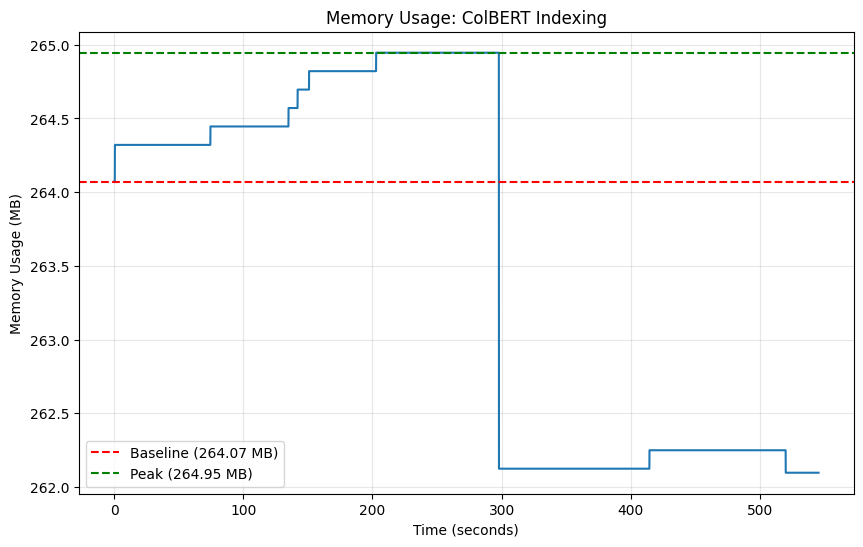

In [46]:
collection = create_and_index_colbert()

In [47]:
# Confirm the embedding shape
print("Confirming embedding shape...")
confirm_embedding_shape()

Confirming embedding shape...
Embedding data type: <class 'list'>
Embedding first element type: <class 'list'>
This embedding's shape is (283, 128)
This embedding's shape is (266, 128)
This embedding's shape is (251, 128)


## Weaviate Client to Create Single Vector Collection

This section initializes a Weaviate collection for the traditional single-vector approach. It sets up the necessary schema and prepares the collection for document indexing.

### Collection Setup
The implementation creates a single Weaviate collection:

- Single Vector Collection: Configured for single vector embeddings using OpenAI's `text-embedding-3-small` model. The collection includes a structured schema for document content and metadata.

### Schema Definition
The schema for the collection includes:
- `page_content`: The main text content to be embedded
- `metadata`: A nested object containing:
  - `title`: Document title (if available)
  - `chunkid`: Unique identifier for each chunk
  - `keywords`: Keywords associated with the document (if available)
  - `source`: Source of the document

### Collection Configuration
The collection is configured with:
- OpenAI's text embedding model for vector generation
- Batch processing for efficient document indexing
- Nested property structure for organized metadata
- UUID generation based on document IDs for consistent identification

### Usage
The initialized collection is used for:
- Indexing documents with single vector embeddings
- Providing a baseline for comparison with the ColBERT multi-vector approach
- Benchmarking performance differences in terms of indexing time, query time, and search accuracy

In [78]:
@measure_memory(label="Single Vector Collection Creation", save_plot="single_vector_collection_creation_memory.png")
def create_and_index_single_vector_collection():
    print("Initializing single vector collection...")
    single_vector_collection = create_single_vector_collection()
    print("Adding documents to single vector collection...")
    add_documents_to_single_vector_collection(documents)
    return single_vector_collection

Initializing single vector collection...


/home/glenn-s-santoso/git/work/gen-ai-exploration/vectordb_exploration/Weaviate/colpal-colbert-colpali-late-interaction/venv/lib/python3.12/site-packages/weaviate/collections/classes/config.py:1950: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  for cls_field in self.model_fields:


Adding documents to single vector collection...
Added 1227 documents to the collection in 95.45 seconds

Memory Usage for Single Vector Collection Creation:
Baseline Memory: 308.67 MB
Peak Memory: 308.67 MB
Memory Increase: 0.00 MB
Execution Time: 96.17 seconds

Memory plot saved to single_vector_collection_creation_memory.png


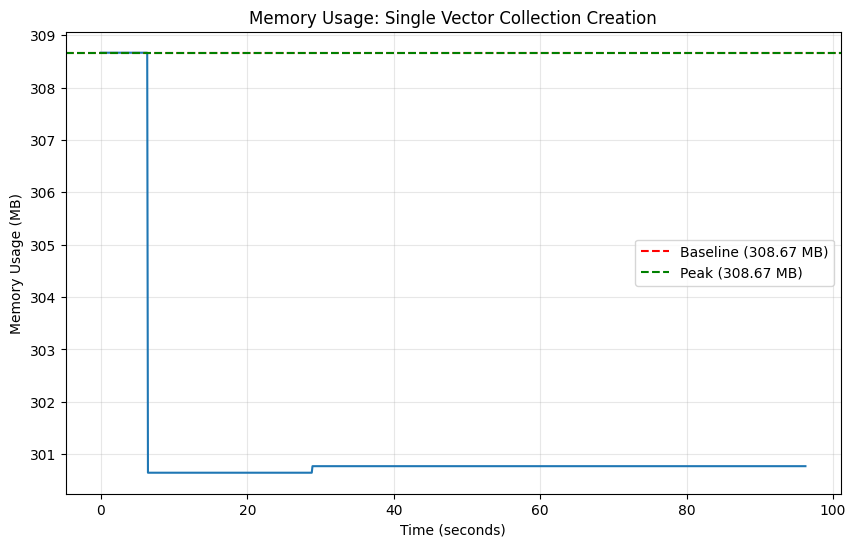

In [79]:
single_vector_collection = create_and_index_single_vector_collection()

## Benchmark Search Methods

### Benchmark a single multi-vector search method on the given index.

This function measures the performance of a specific multi-vector search method by running it on a set of query multi-vectors and comparing the results against the ground truth. It calculates and returns various metrics such as recall, precision, and query time.

In [ ]:
def benchmark_search_method(search_type, expected_chunk_dict, ground_truth_contexts):
    """
    Benchmark a specific search method from index.py.
    """
    print(f"\n===== Benchmarking {search_type} search =====\n")

    retrieved_contexts = {}
    retrieval_results_data = []
    execution_times = []  # Store search times

    for question_id, question_data in expected_chunk_dict.items():
        question, relevant_ids = question_data["question"], question_data["relevant_ids"]

        # Get search results with timing
        try:
            results, search_time = search(question, search_type)
            execution_times.append(search_time)  # Store the search time
            
            docs = [result.properties for result in results.objects]

            # Evaluate results
            target_chunk_count, target_chunk_rank = get_retrieval_results_data(docs, relevant_ids)
            retrieved_contexts[question] = get_retrieved_contexts(docs)
            retrieval_results_data.append({
                "id": question_id,
                "question": question,
                "retrieved_count": target_chunk_count,
                "retrieved_rank": target_chunk_rank,
                "search_time": f"{search_time:.4f}s"  # Add search time to results
            })

        except Exception as e:
            print(f"Error processing question {question_id}: {e}")

    # Calculate average search time
    avg_execution_time = sum(execution_times) / len(execution_times) if execution_times else 0
    print(f"Average search time: {avg_execution_time:.4f} seconds")
    
    # Display evaluation metrics
    metrics = display_scores(retrieved_contexts, ground_truth_contexts)

    # Create and display results DataFrame
    detail_results_df = pd.DataFrame(data=retrieval_results_data)
    print("\nResults summary:")
    display(detail_results_df.head())

    # Save results to CSV
    detail_results_df.to_csv(f"{RESULTS_DIR}/index_{search_type}_results.csv", index=False)

    return {
        "results_df": detail_results_df,
        "retrieved_contexts": retrieved_contexts,
        "metrics": metrics,
        "execution_times": execution_times,
        "avg_execution_time": avg_execution_time
    }

### Benchmark a single vector search method on the given index.

This function measures the performance of a specific vector search method by running it on a set of query vectors and comparing the results against the ground truth. It calculates and returns various metrics such as recall, precision, and query time.

In [75]:
def benchmark_single_vector_search_method(expected_chunk_dict, ground_truth_contexts):
    """
    Benchmark a specific search method from index.py.
    """
    print(f"\n===== Benchmarking Single Vector search =====\n")
    global single_vector_collection

    retrieved_contexts = {}
    retrieval_results_data = []
    execution_times = []  # Store search times

    for question_id, question_data in expected_chunk_dict.items():
        question, relevant_ids = question_data["question"], question_data["relevant_ids"]

        # Get search results with timing
        try:
            results, search_time = search_no_interaction_near_vector(single_vector_collection, question)
            execution_times.append(search_time)  # Store the search time
            
            docs = [result.properties for result in results.objects]

            # Evaluate results
            target_chunk_count, target_chunk_rank = get_retrieval_results_data(docs, relevant_ids)
            
            # Create retrieved contexts for this question
            question_retrieved_contexts = get_single_vector_retrieved_contexts(docs)
            
            # Only add to retrieved_contexts if we have valid document IDs
            if question_retrieved_contexts and all(doc_id is not None for doc_id in question_retrieved_contexts.keys()):
                retrieved_contexts[question] = question_retrieved_contexts
            
            retrieval_results_data.append({
                "id": question_id,
                "question": question,
                "retrieved_count": target_chunk_count,
                "retrieved_rank": target_chunk_rank,
                "search_time": f"{search_time:.4f}s"  # Add search time to results
            })

        except Exception as e:
            print(f"Error processing question {question_id}: {e}")

    # Calculate average search time
    avg_execution_time = sum(execution_times) / len(execution_times) if execution_times else 0
    print(f"Average search time: {avg_execution_time:.4f} seconds")
    
    # Display evaluation metrics only if we have valid retrieved contexts
    if retrieved_contexts and all(bool(docs) for docs in retrieved_contexts.values()):
        metrics = display_single_vector_scores(retrieved_contexts, ground_truth_contexts)
    else:
        print("Skipping evaluation due to invalid retrieved contexts")
        metrics = {"ndcg": {}, "map": {}, "recall": {}, "precision": {}}

    # Create and display results DataFrame
    detail_results_df = pd.DataFrame(data=retrieval_results_data)
    print("\nResults summary:")
    display(detail_results_df.head())

    # Save results to CSV
    detail_results_df.to_csv(f"{RESULTS_DIR}/index_single_vector_results.csv", index=False)

    return {
        "results_df": detail_results_df,
        "retrieved_contexts": retrieved_contexts,
        "metrics": metrics,
        "execution_times": execution_times,
        "avg_execution_time": avg_execution_time
    }


===== Benchmarking near-vector search =====


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 273.04 MB
Peak Memory: 273.04 MB
Memory Increase: 0.00 MB
Execution Time: 1.70 seconds

Memory plot saved to search_colbert_near_vector.png


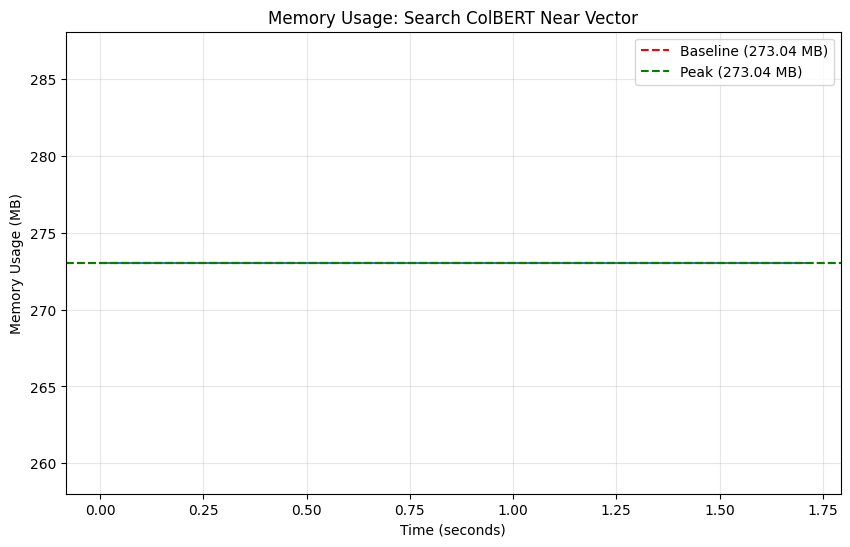


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 273.17 MB
Peak Memory: 273.17 MB
Memory Increase: 0.00 MB
Execution Time: 1.08 seconds

Memory plot saved to search_colbert_near_vector.png


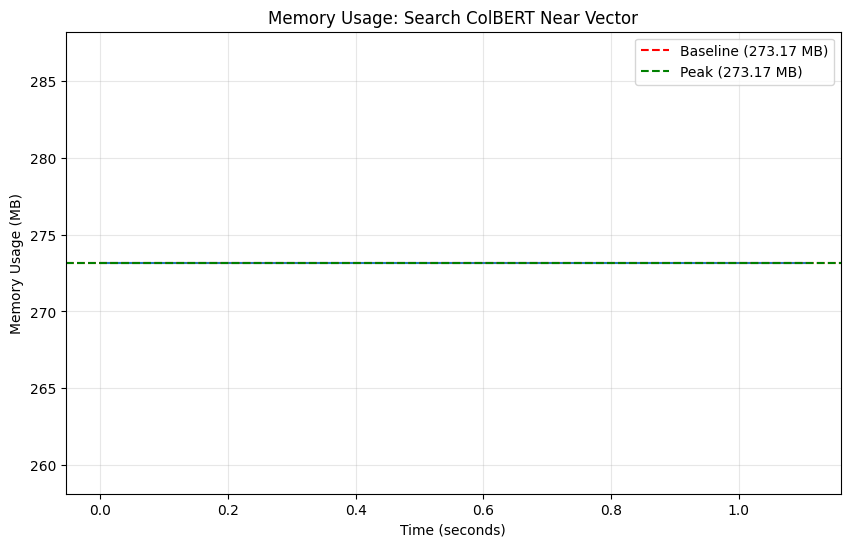


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 275.17 MB
Peak Memory: 275.29 MB
Memory Increase: 0.12 MB
Execution Time: 1.44 seconds

Memory plot saved to search_colbert_near_vector.png


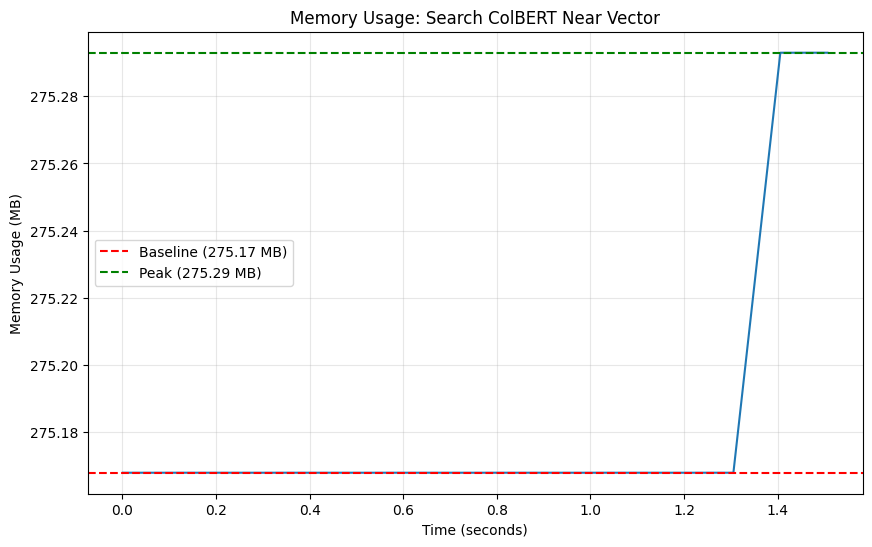


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 277.29 MB
Peak Memory: 277.29 MB
Memory Increase: 0.00 MB
Execution Time: 1.28 seconds

Memory plot saved to search_colbert_near_vector.png


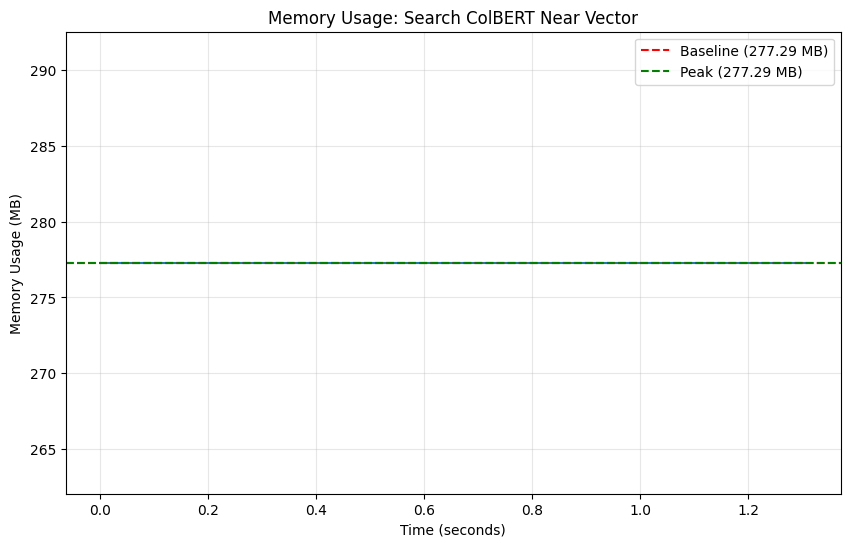


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 277.29 MB
Peak Memory: 277.29 MB
Memory Increase: 0.00 MB
Execution Time: 1.54 seconds

Memory plot saved to search_colbert_near_vector.png


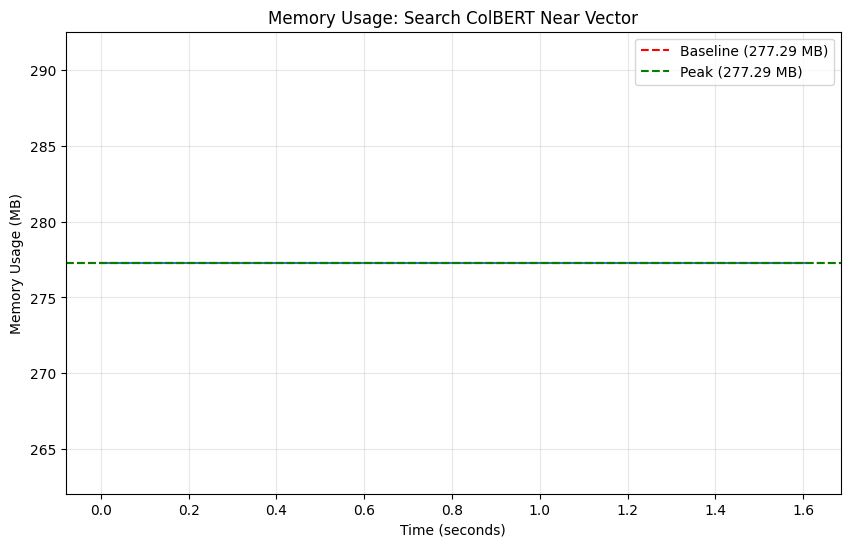


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 279.04 MB
Peak Memory: 279.04 MB
Memory Increase: 0.00 MB
Execution Time: 1.60 seconds

Memory plot saved to search_colbert_near_vector.png


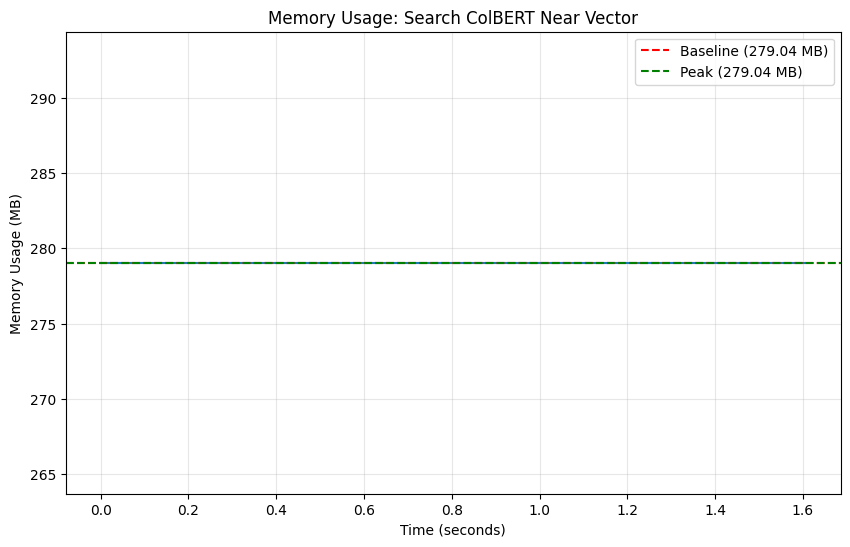


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 279.04 MB
Peak Memory: 279.04 MB
Memory Increase: 0.00 MB
Execution Time: 1.51 seconds

Memory plot saved to search_colbert_near_vector.png


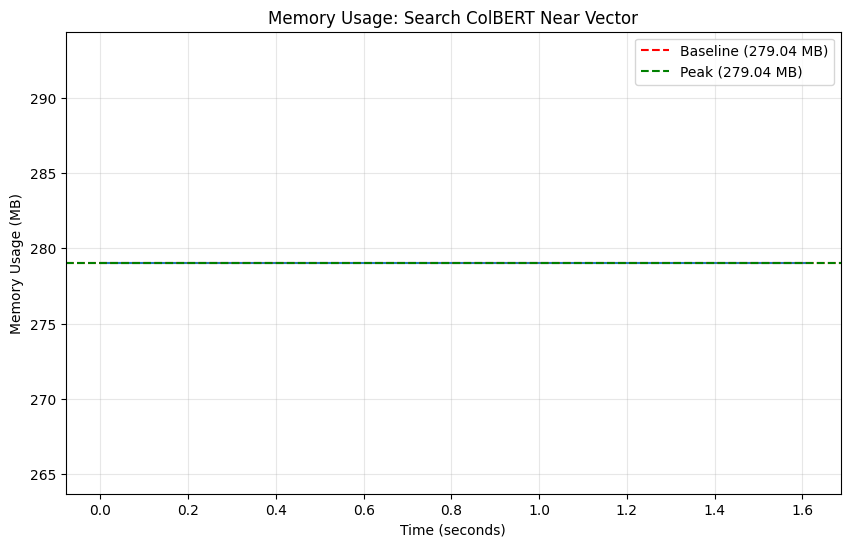


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 280.79 MB
Peak Memory: 280.79 MB
Memory Increase: 0.00 MB
Execution Time: 1.83 seconds

Memory plot saved to search_colbert_near_vector.png


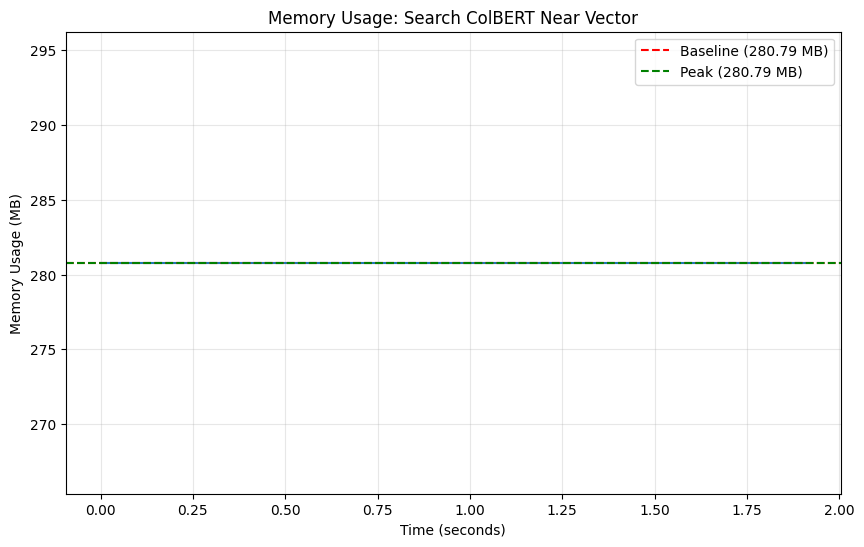


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 280.79 MB
Peak Memory: 280.79 MB
Memory Increase: 0.00 MB
Execution Time: 1.49 seconds

Memory plot saved to search_colbert_near_vector.png


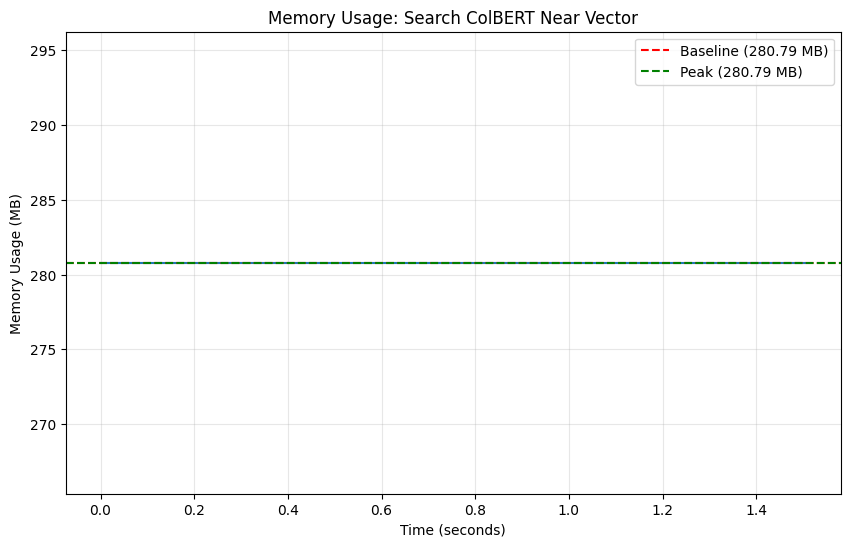


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 282.54 MB
Peak Memory: 282.67 MB
Memory Increase: 0.12 MB
Execution Time: 1.54 seconds

Memory plot saved to search_colbert_near_vector.png


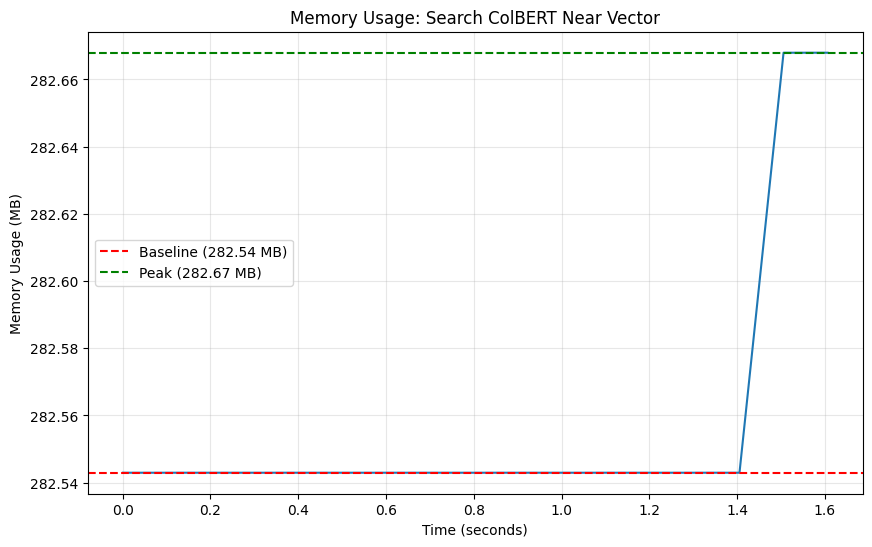


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 284.92 MB
Peak Memory: 285.04 MB
Memory Increase: 0.12 MB
Execution Time: 1.55 seconds

Memory plot saved to search_colbert_near_vector.png


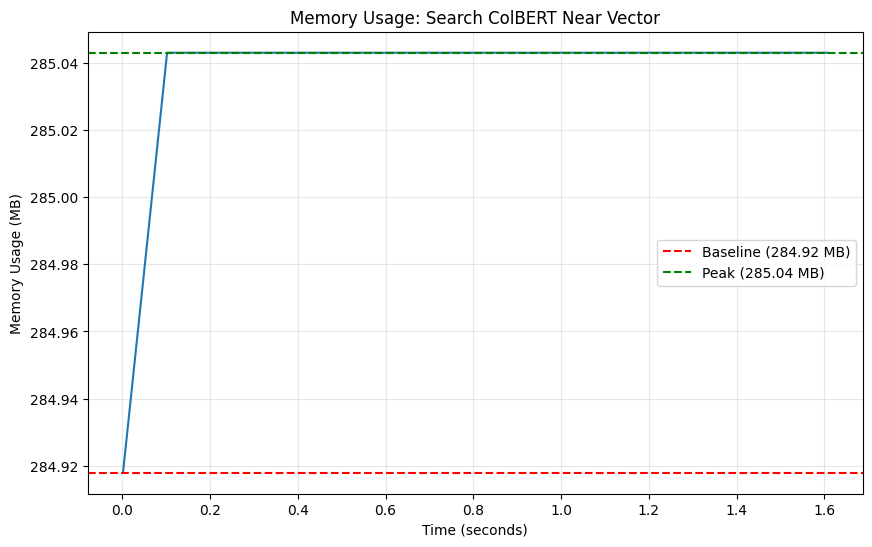


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 285.17 MB
Peak Memory: 285.29 MB
Memory Increase: 0.12 MB
Execution Time: 1.11 seconds

Memory plot saved to search_colbert_near_vector.png


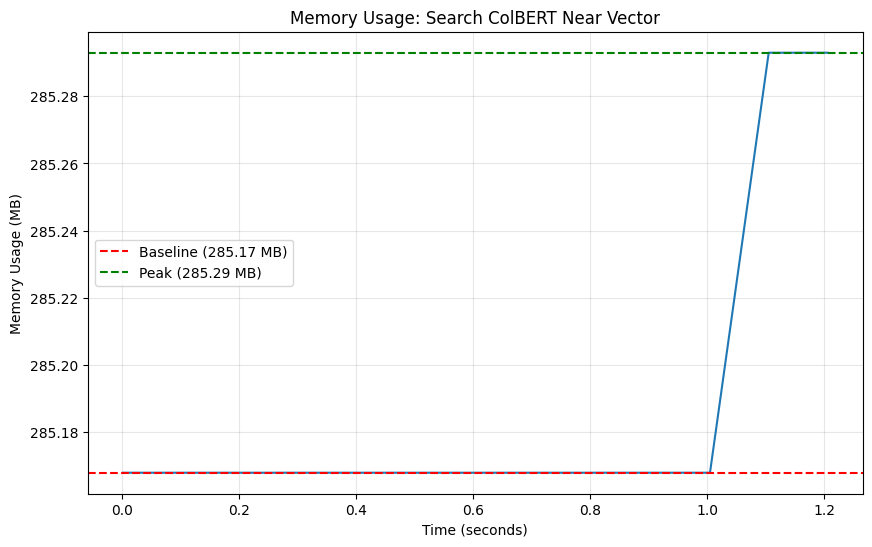


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 287.79 MB
Peak Memory: 287.79 MB
Memory Increase: 0.00 MB
Execution Time: 1.53 seconds

Memory plot saved to search_colbert_near_vector.png


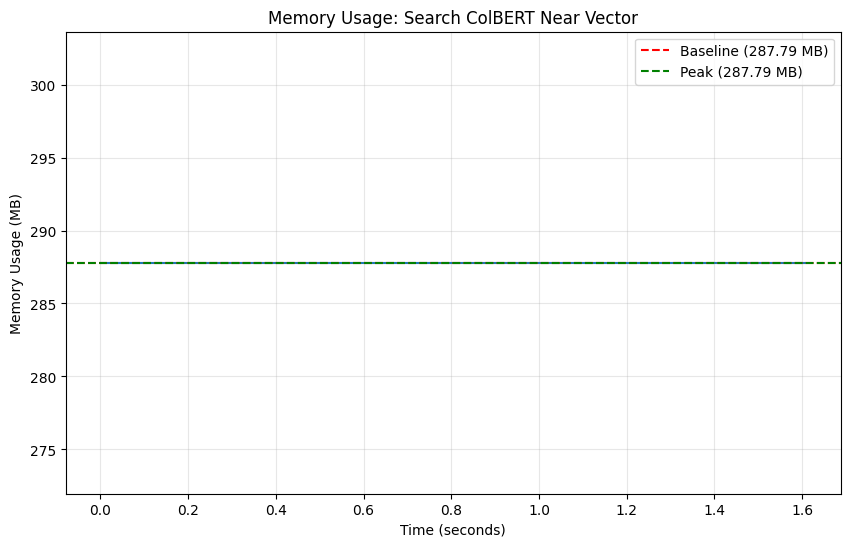


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 287.92 MB
Peak Memory: 287.92 MB
Memory Increase: 0.00 MB
Execution Time: 1.24 seconds

Memory plot saved to search_colbert_near_vector.png


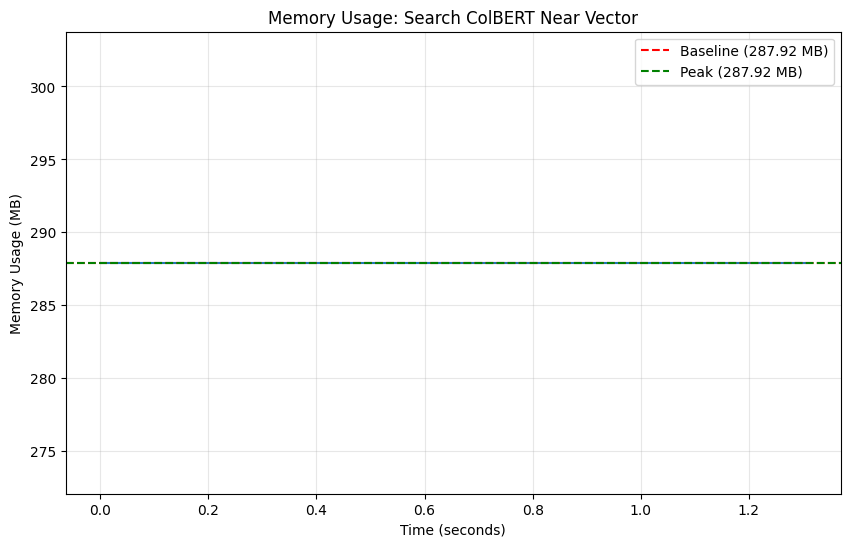


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 290.17 MB
Peak Memory: 290.42 MB
Memory Increase: 0.25 MB
Execution Time: 1.46 seconds

Memory plot saved to search_colbert_near_vector.png


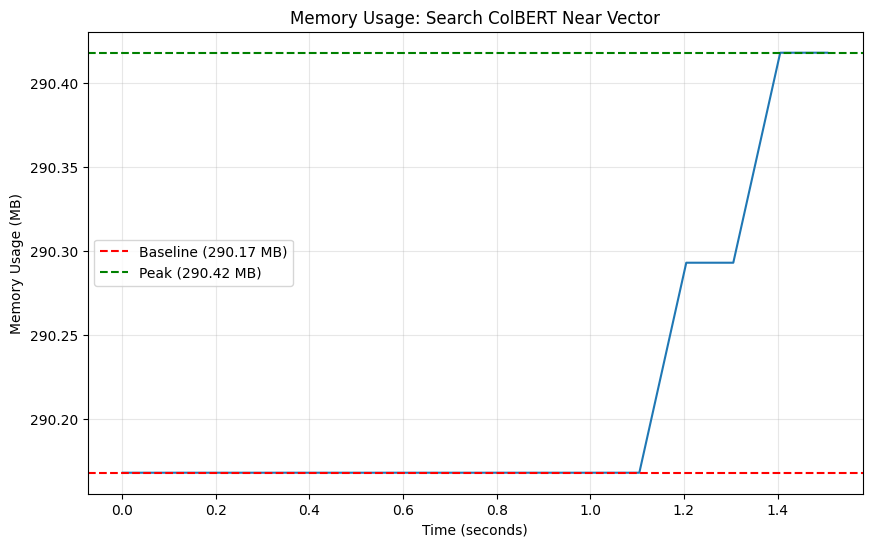


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 292.92 MB
Peak Memory: 292.92 MB
Memory Increase: 0.00 MB
Execution Time: 1.52 seconds

Memory plot saved to search_colbert_near_vector.png


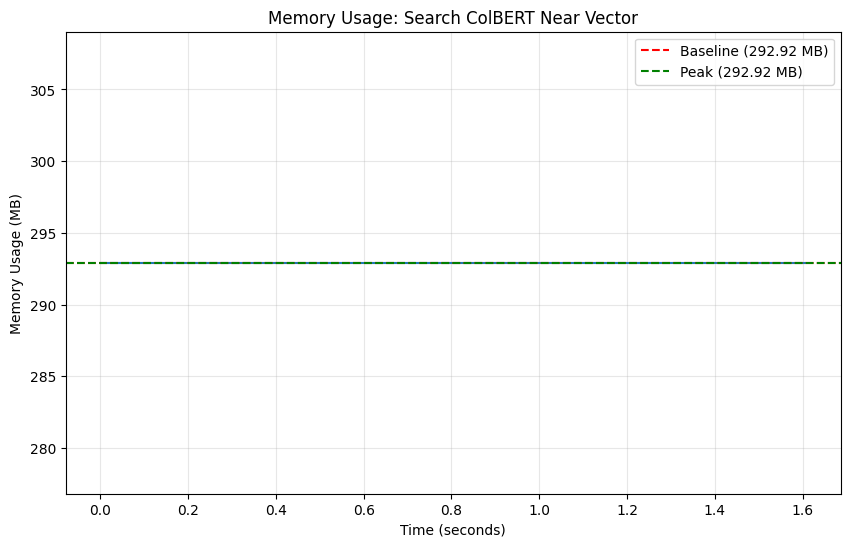


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 293.29 MB
Peak Memory: 293.29 MB
Memory Increase: 0.00 MB
Execution Time: 1.19 seconds

Memory plot saved to search_colbert_near_vector.png


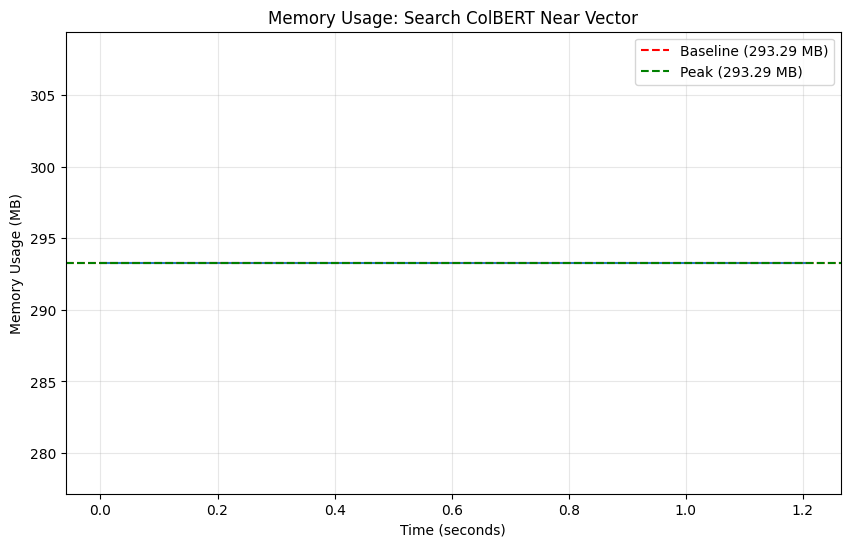


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 295.54 MB
Peak Memory: 295.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.58 seconds

Memory plot saved to search_colbert_near_vector.png


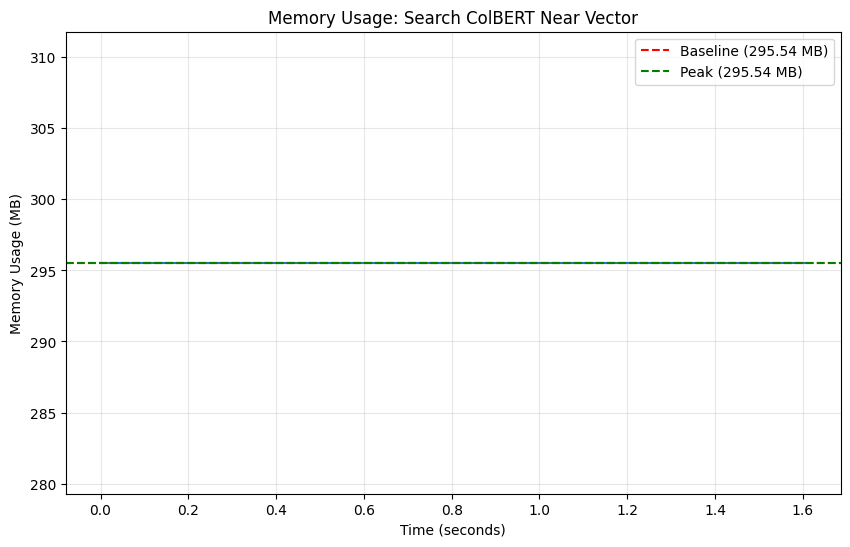


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 295.92 MB
Peak Memory: 295.92 MB
Memory Increase: 0.00 MB
Execution Time: 1.41 seconds

Memory plot saved to search_colbert_near_vector.png


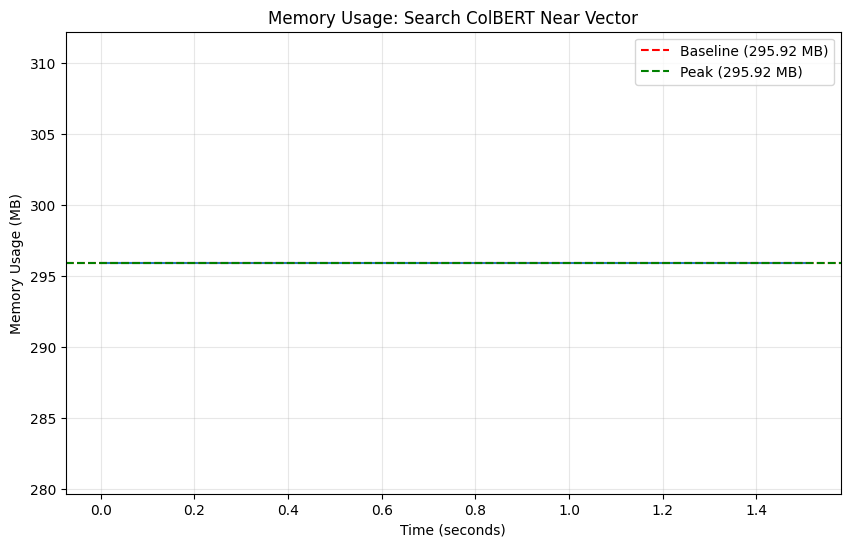


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 298.17 MB
Peak Memory: 298.17 MB
Memory Increase: 0.00 MB
Execution Time: 1.57 seconds

Memory plot saved to search_colbert_near_vector.png


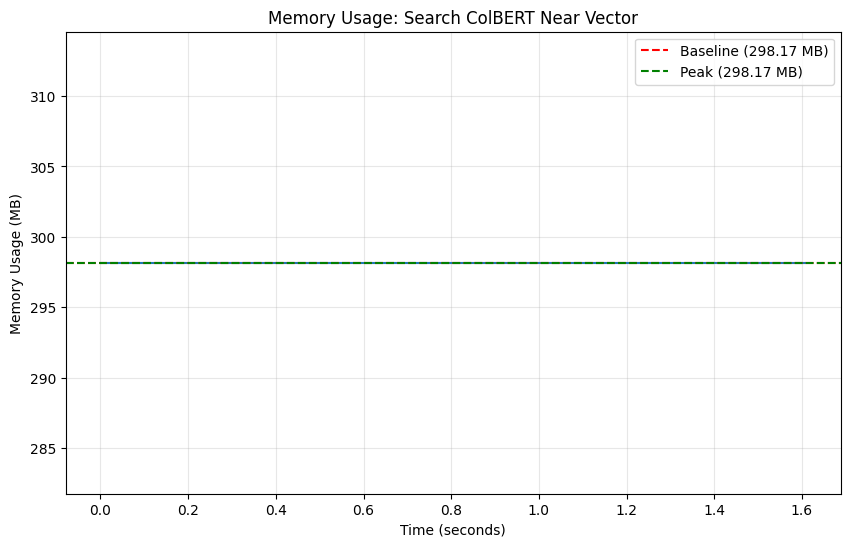


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 298.29 MB
Peak Memory: 298.29 MB
Memory Increase: 0.00 MB
Execution Time: 1.48 seconds

Memory plot saved to search_colbert_near_vector.png


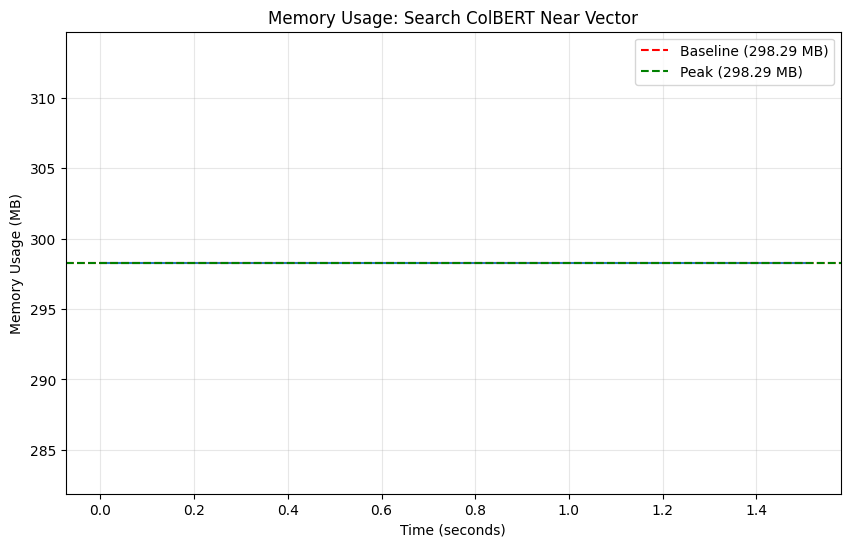


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 300.67 MB
Peak Memory: 300.67 MB
Memory Increase: 0.00 MB
Execution Time: 1.25 seconds

Memory plot saved to search_colbert_near_vector.png


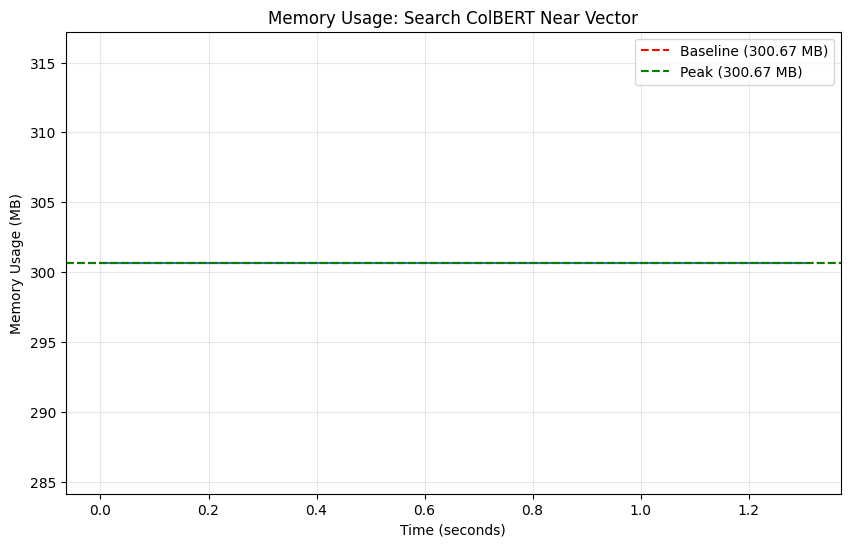


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.29 MB
Peak Memory: 303.42 MB
Memory Increase: 0.12 MB
Execution Time: 1.45 seconds

Memory plot saved to search_colbert_near_vector.png


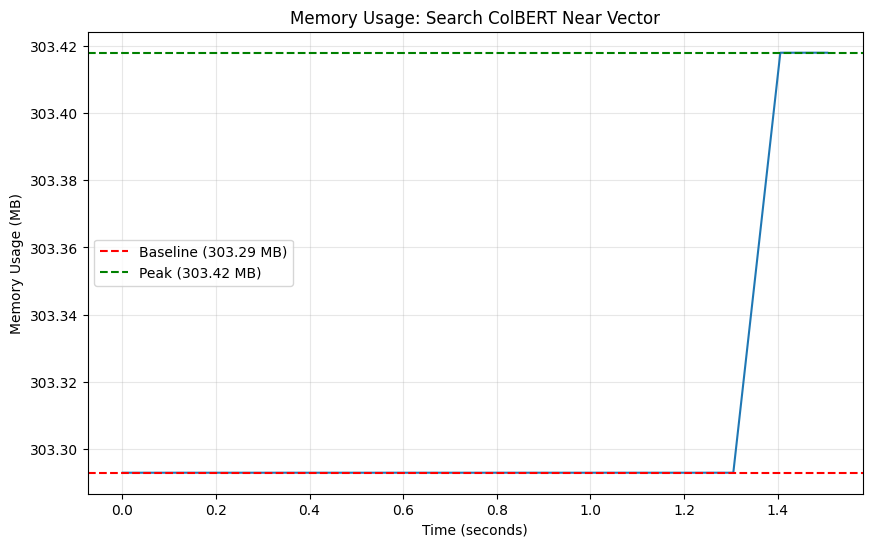


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.24 seconds

Memory plot saved to search_colbert_near_vector.png


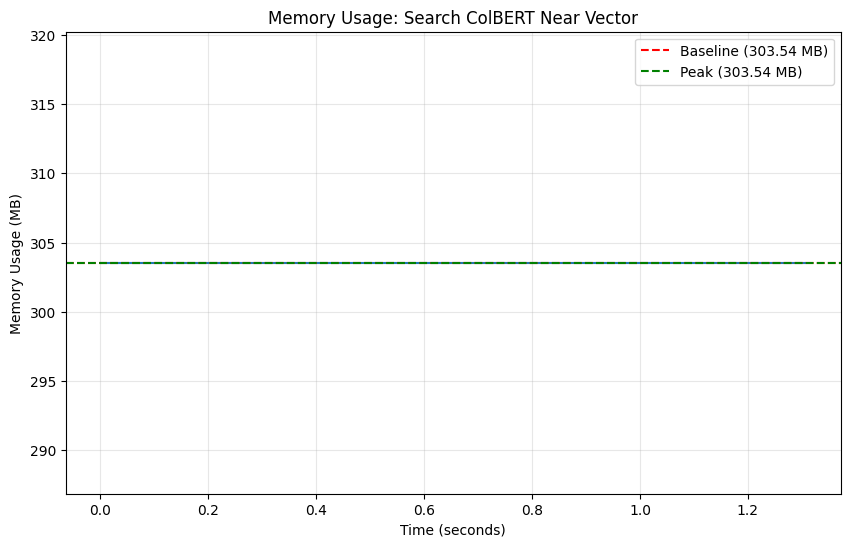


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.53 seconds

Memory plot saved to search_colbert_near_vector.png


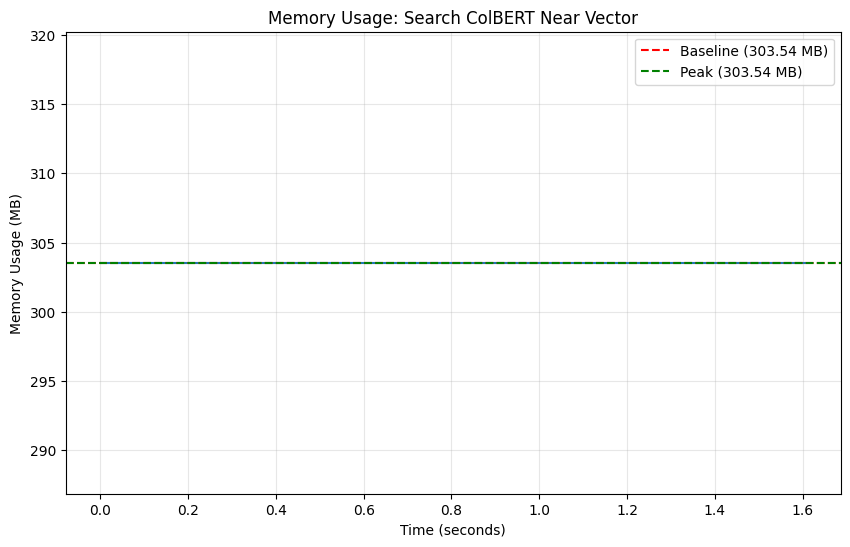


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.25 seconds

Memory plot saved to search_colbert_near_vector.png


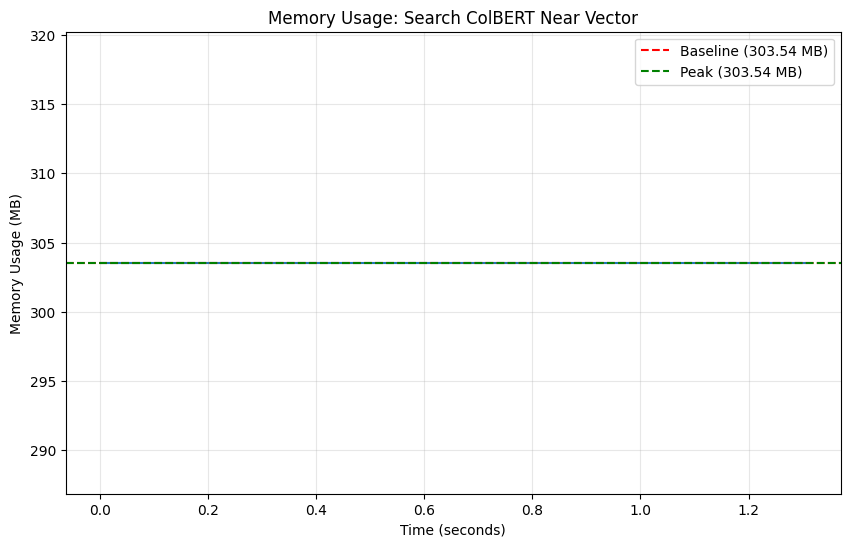


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.75 seconds

Memory plot saved to search_colbert_near_vector.png


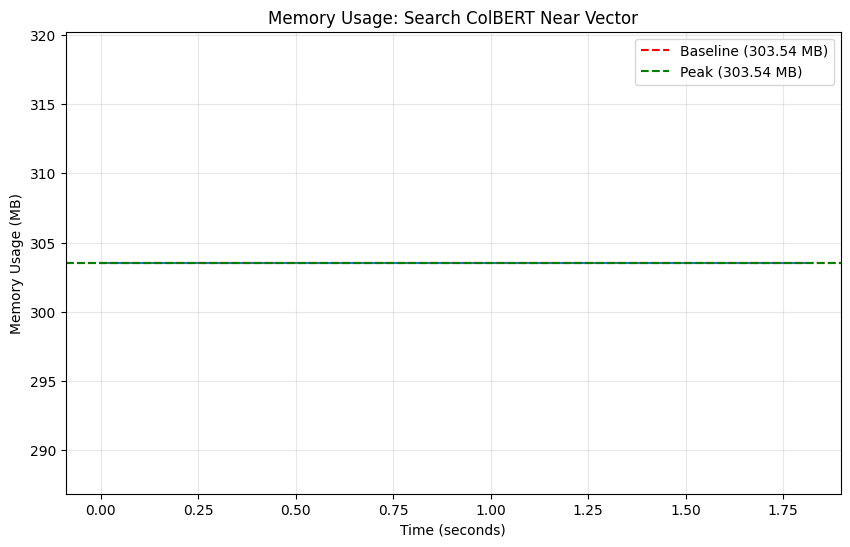


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.53 seconds

Memory plot saved to search_colbert_near_vector.png


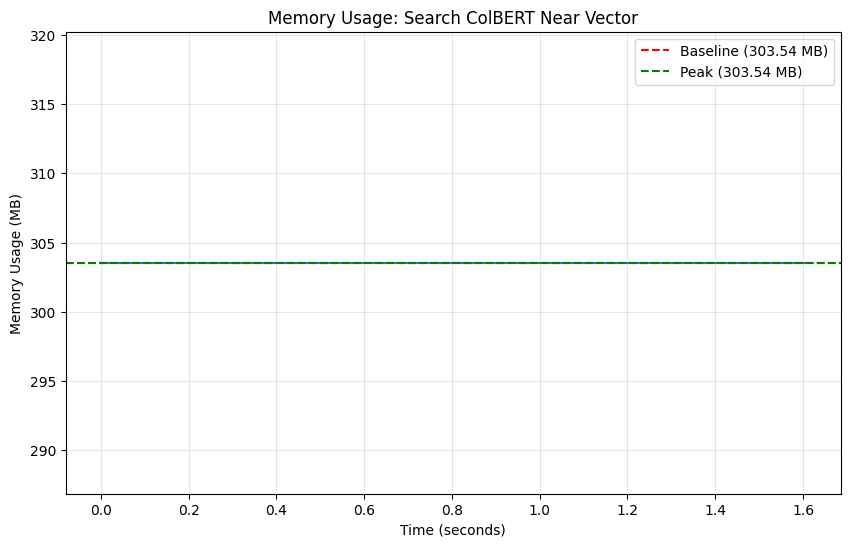


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 0.96 seconds

Memory plot saved to search_colbert_near_vector.png


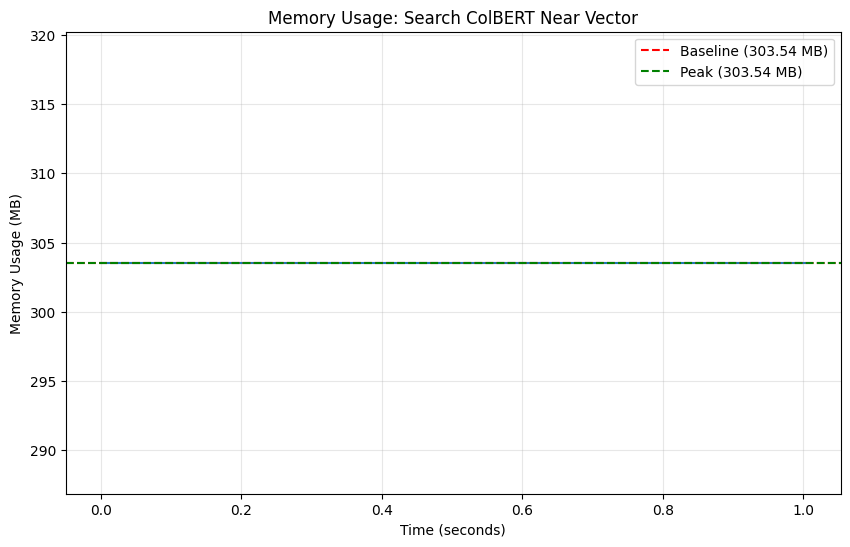


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.54 seconds

Memory plot saved to search_colbert_near_vector.png


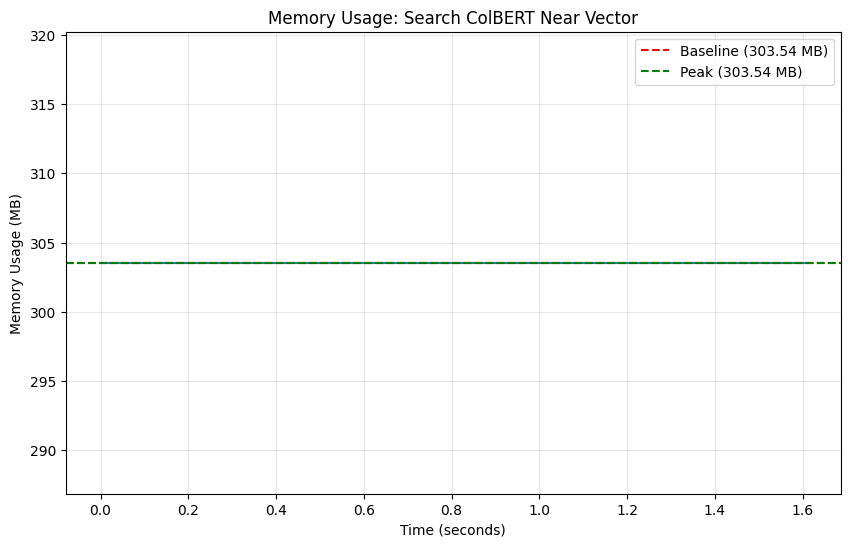


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.22 seconds

Memory plot saved to search_colbert_near_vector.png


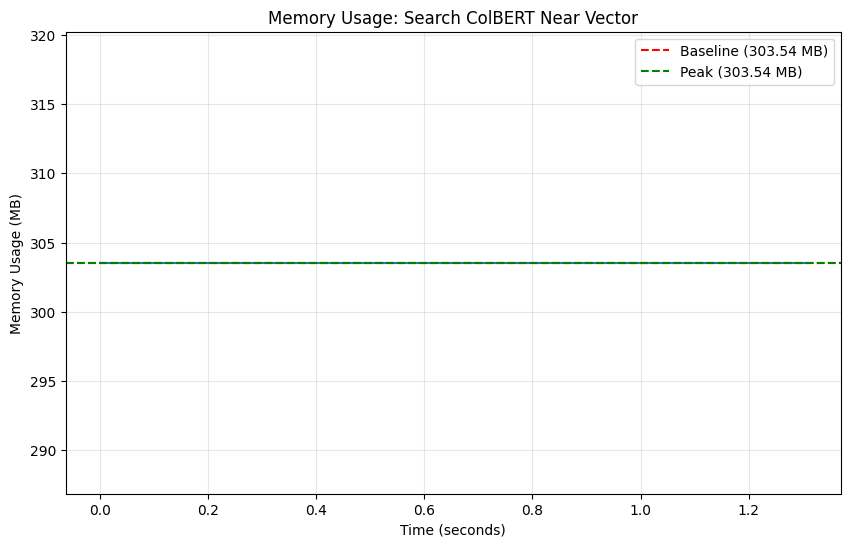


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.25 seconds

Memory plot saved to search_colbert_near_vector.png


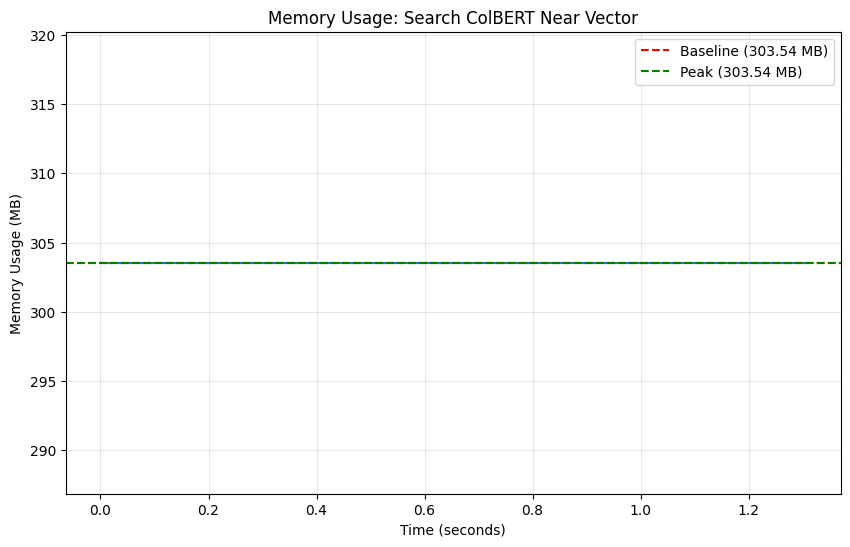


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.56 seconds

Memory plot saved to search_colbert_near_vector.png


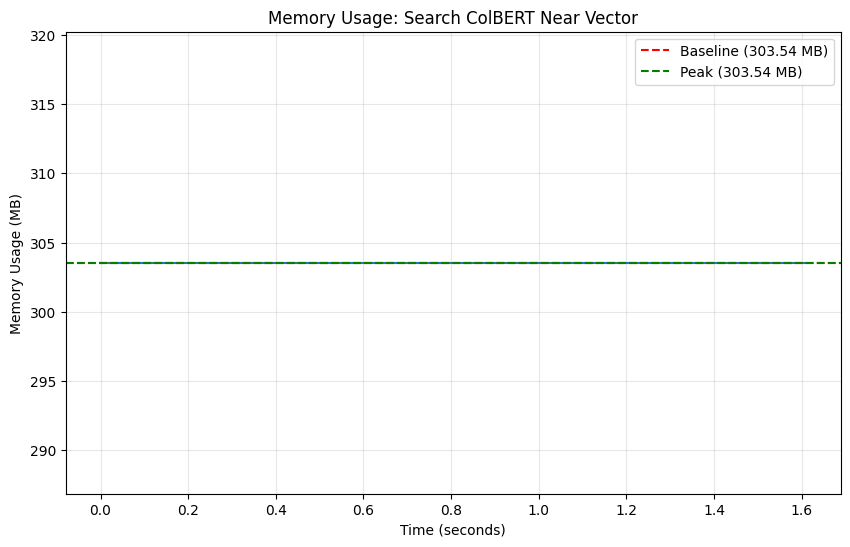


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.25 seconds

Memory plot saved to search_colbert_near_vector.png


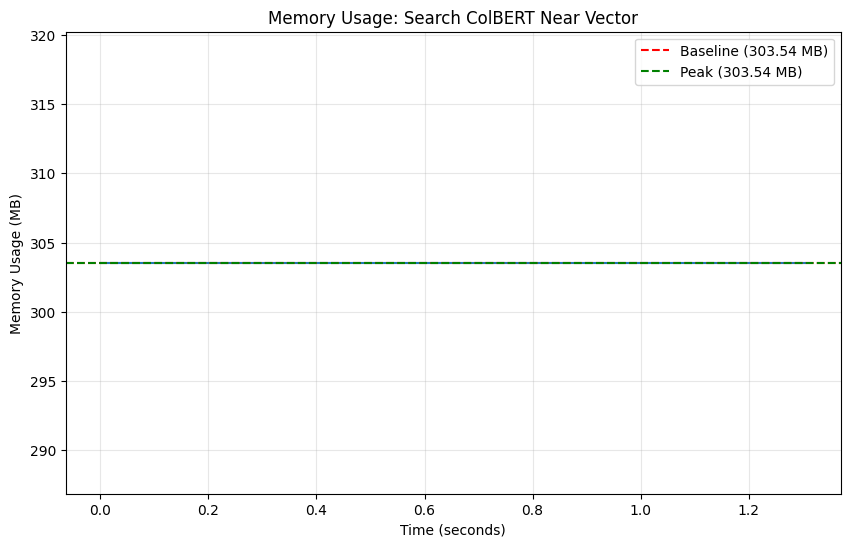


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.25 seconds

Memory plot saved to search_colbert_near_vector.png


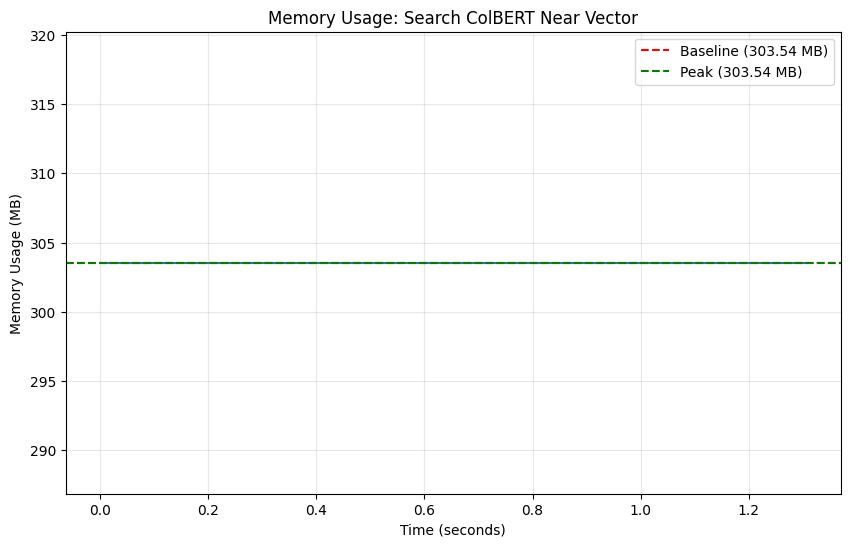


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.24 seconds

Memory plot saved to search_colbert_near_vector.png


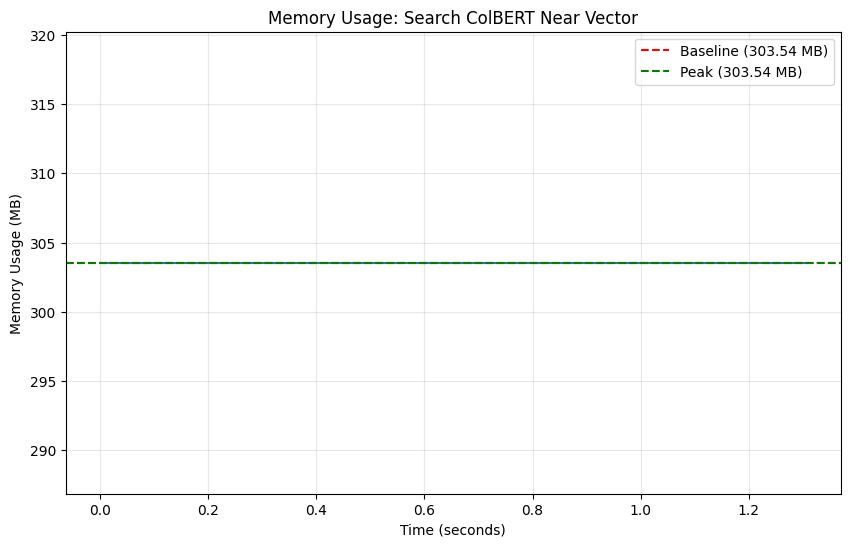


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.21 seconds

Memory plot saved to search_colbert_near_vector.png


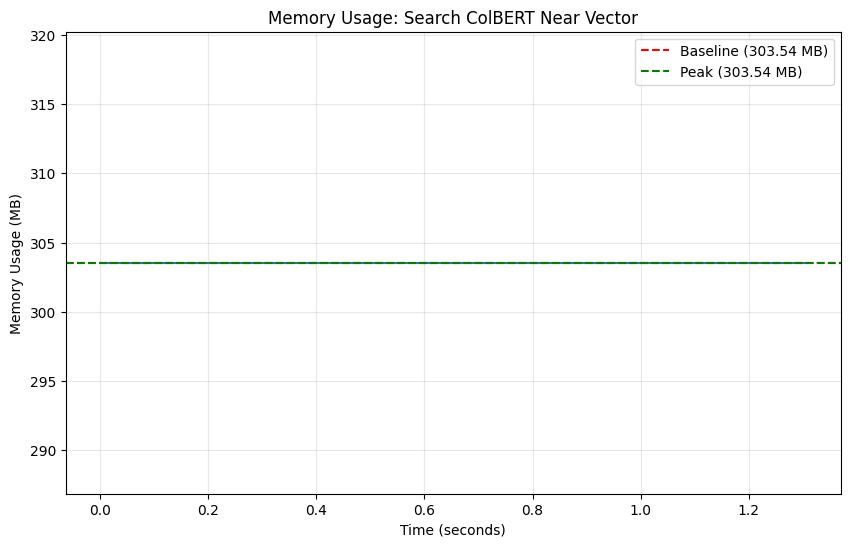


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.32 seconds

Memory plot saved to search_colbert_near_vector.png


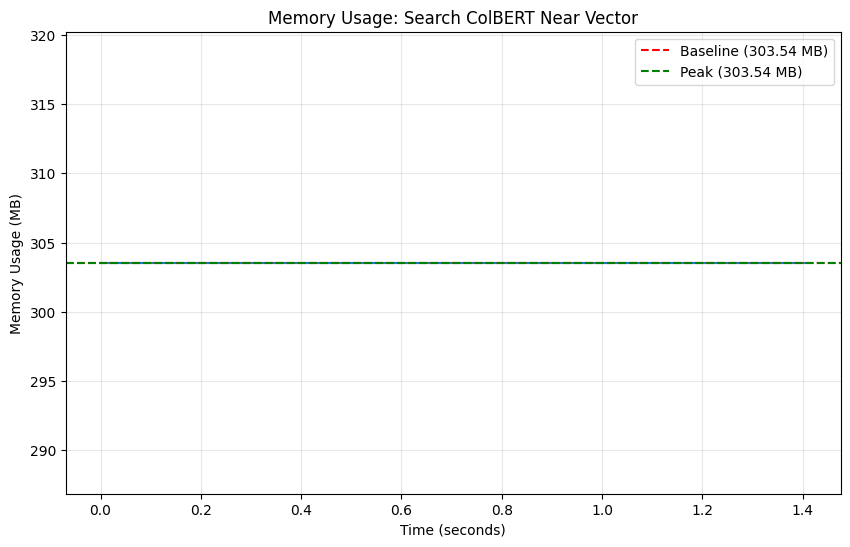


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.45 seconds

Memory plot saved to search_colbert_near_vector.png


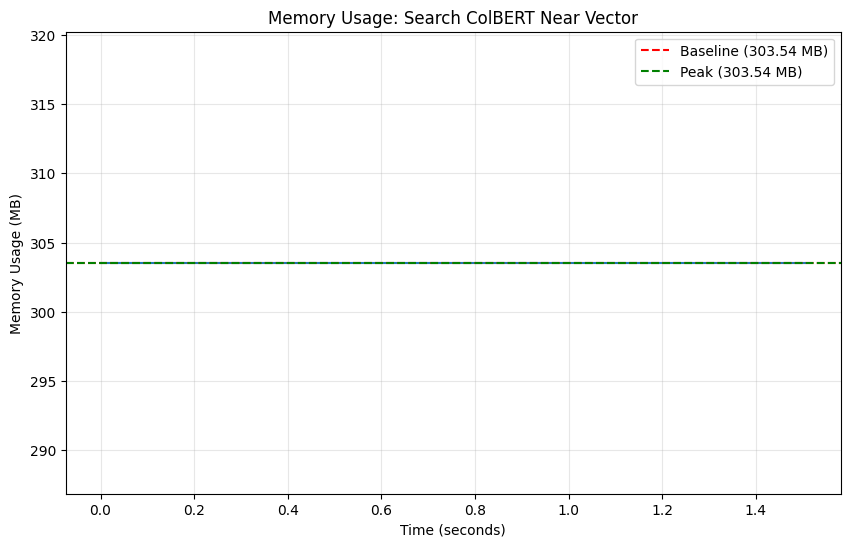


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.54 MB
Peak Memory: 303.54 MB
Memory Increase: 0.00 MB
Execution Time: 1.26 seconds

Memory plot saved to search_colbert_near_vector.png


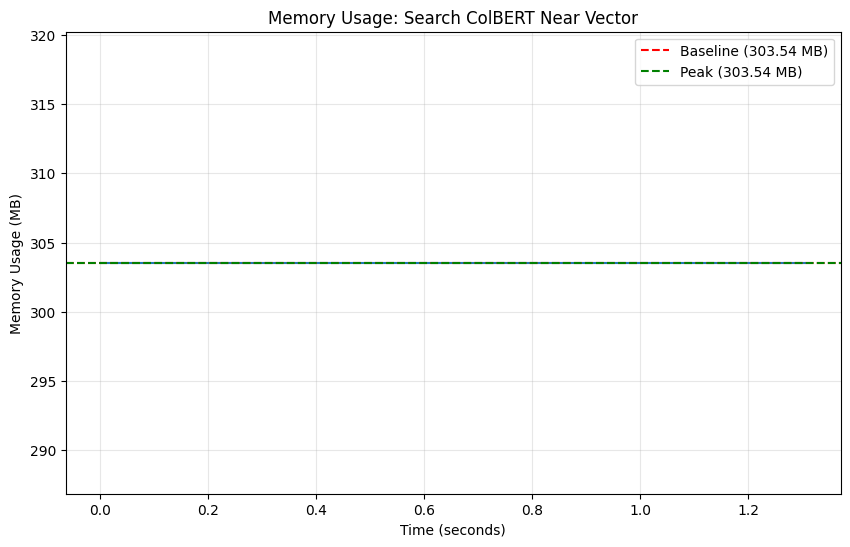


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.67 MB
Peak Memory: 303.67 MB
Memory Increase: 0.00 MB
Execution Time: 1.44 seconds

Memory plot saved to search_colbert_near_vector.png


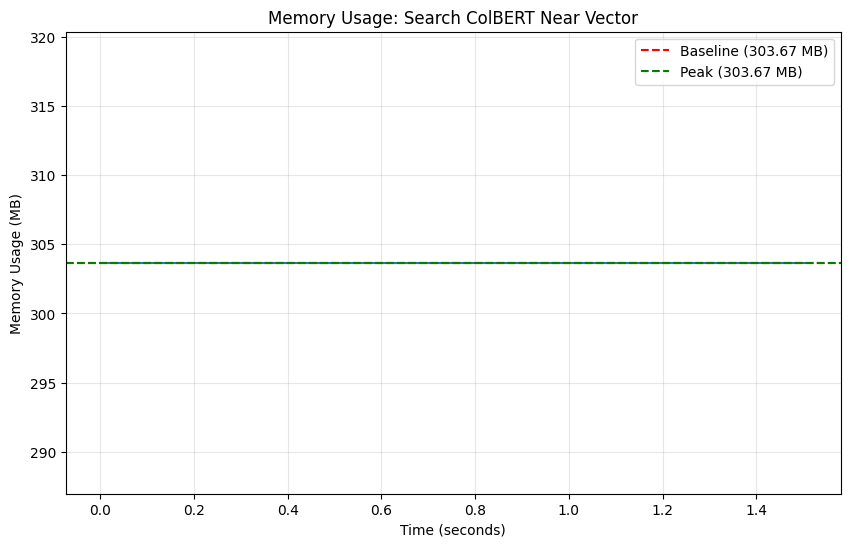


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.67 MB
Peak Memory: 303.67 MB
Memory Increase: 0.00 MB
Execution Time: 1.59 seconds

Memory plot saved to search_colbert_near_vector.png


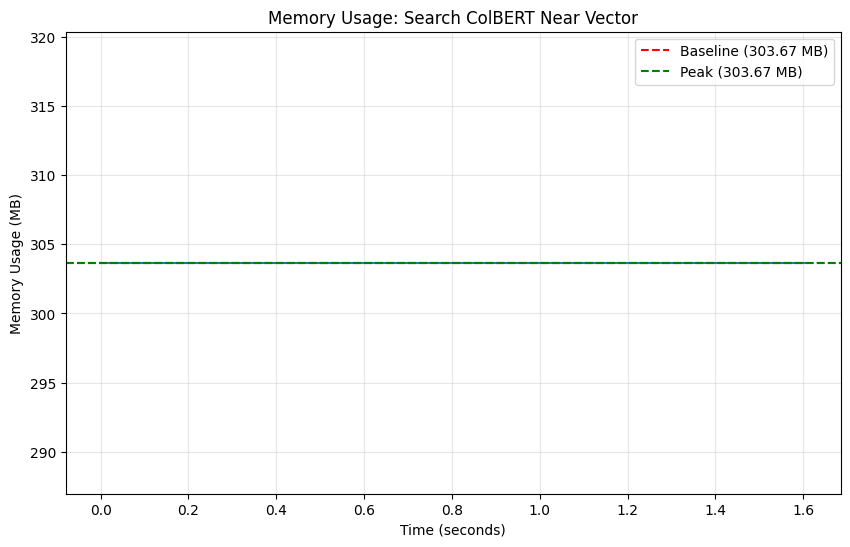


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.79 MB
Peak Memory: 303.79 MB
Memory Increase: 0.00 MB
Execution Time: 0.97 seconds

Memory plot saved to search_colbert_near_vector.png


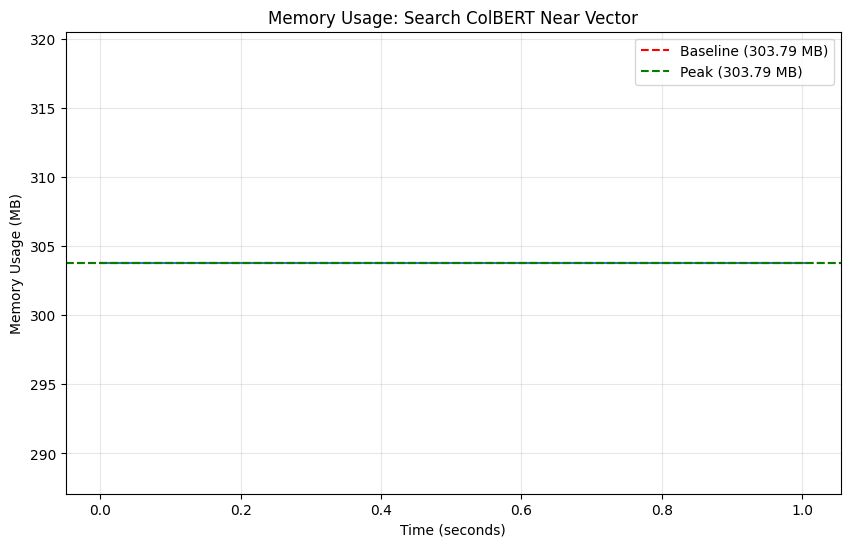


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.79 MB
Peak Memory: 303.79 MB
Memory Increase: 0.00 MB
Execution Time: 1.06 seconds

Memory plot saved to search_colbert_near_vector.png


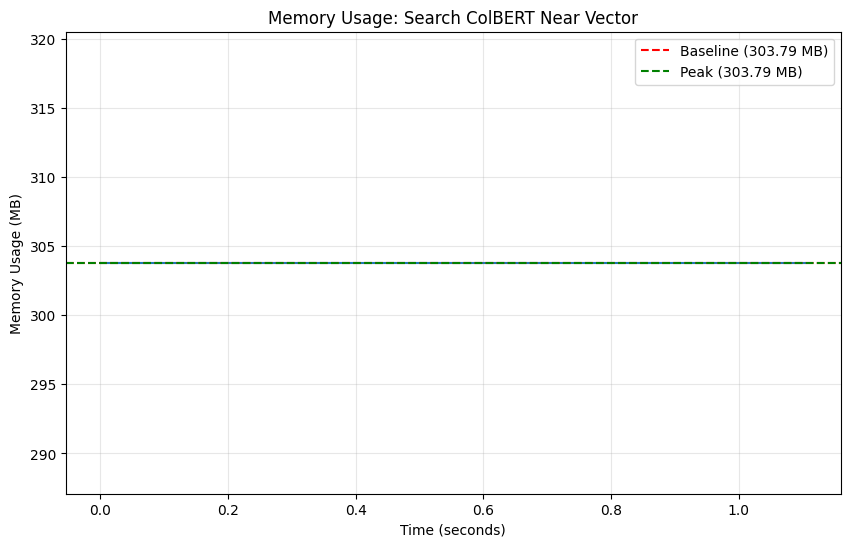


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.79 MB
Peak Memory: 303.79 MB
Memory Increase: 0.00 MB
Execution Time: 1.49 seconds

Memory plot saved to search_colbert_near_vector.png


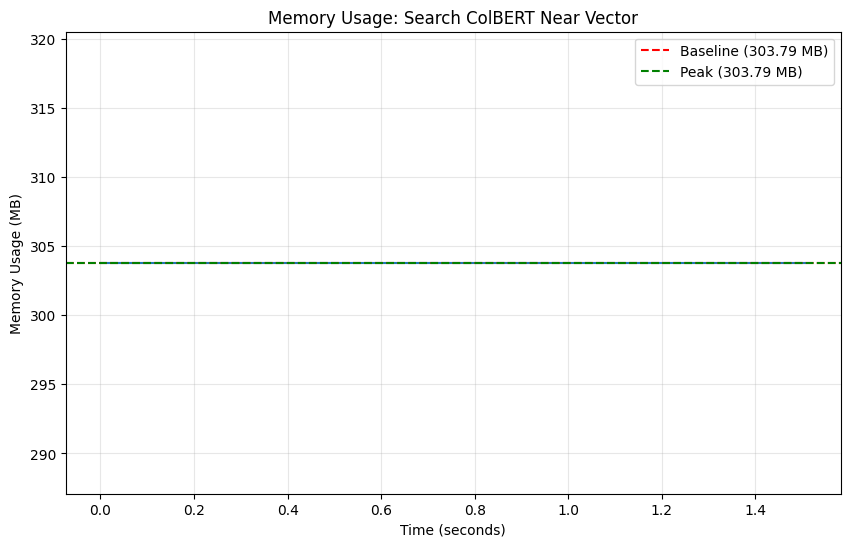


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.79 MB
Peak Memory: 303.79 MB
Memory Increase: 0.00 MB
Execution Time: 1.23 seconds

Memory plot saved to search_colbert_near_vector.png


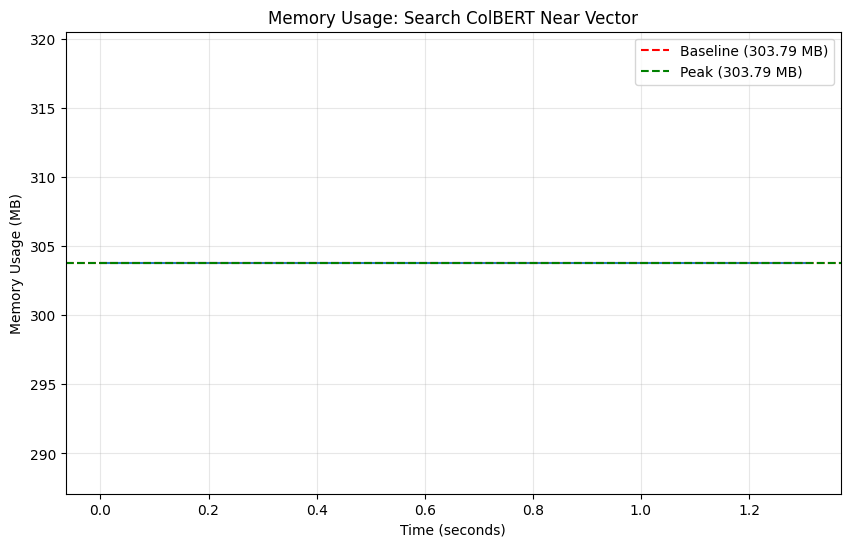


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 303.92 MB
Peak Memory: 303.92 MB
Memory Increase: 0.00 MB
Execution Time: 1.58 seconds

Memory plot saved to search_colbert_near_vector.png


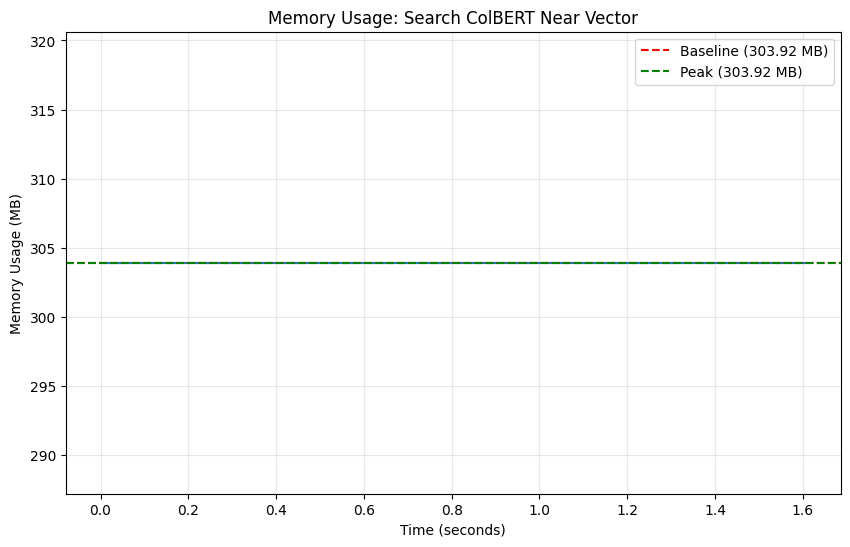


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 304.29 MB
Peak Memory: 304.29 MB
Memory Increase: 0.00 MB
Execution Time: 1.48 seconds

Memory plot saved to search_colbert_near_vector.png


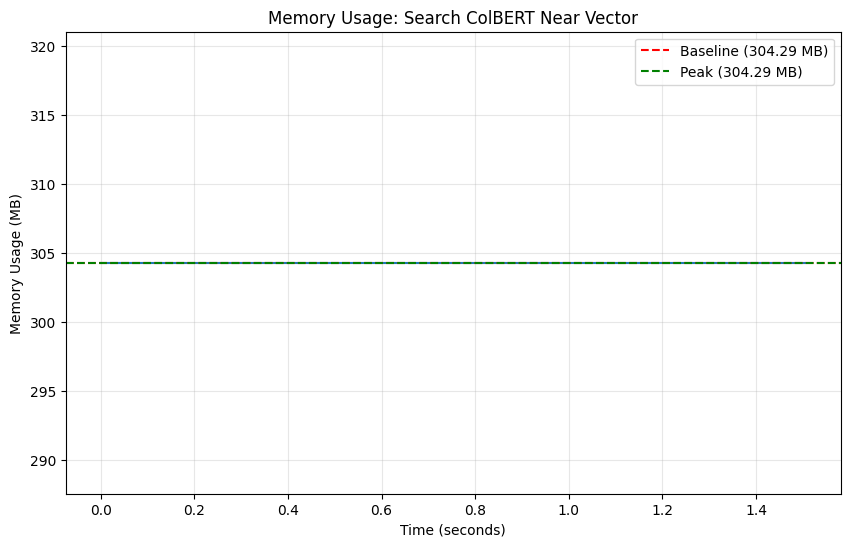


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 304.42 MB
Peak Memory: 304.42 MB
Memory Increase: 0.00 MB
Execution Time: 1.30 seconds

Memory plot saved to search_colbert_near_vector.png


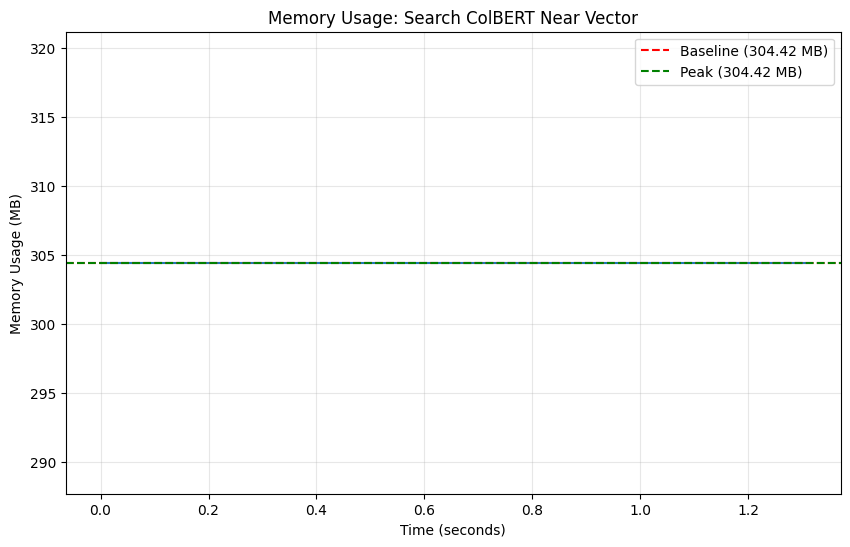


Memory Usage for Search ColBERT Near Vector:
Baseline Memory: 306.17 MB
Peak Memory: 306.17 MB
Memory Increase: 0.00 MB
Execution Time: 1.26 seconds

Memory plot saved to search_colbert_near_vector.png


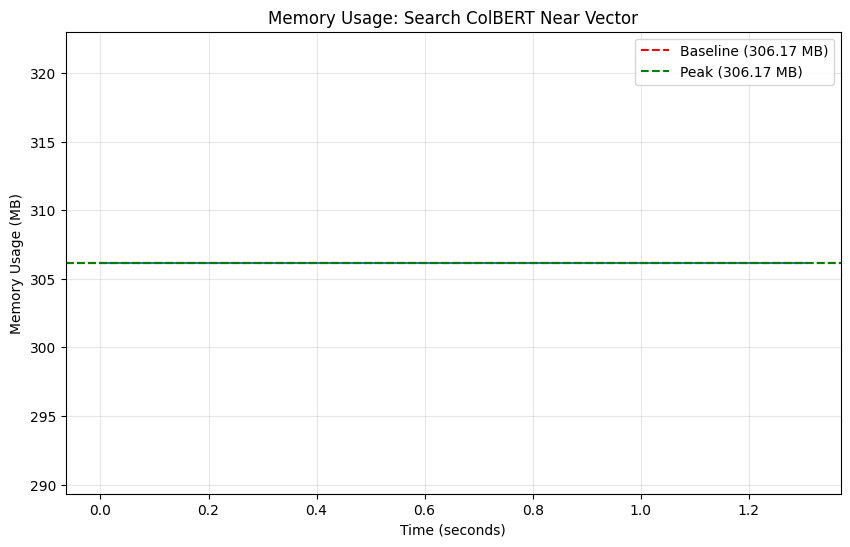

Average search time: 0.0992 seconds
NDCG: 
  - NDCG@1 = 0.8
  - NDCG@3 = 0.74
  - NDCG@5 = 0.77
  - NDCG@10 = 0.8
MAP: 
  - MAP@1 = 0.44
  - MAP@3 = 0.66
  - MAP@5 = 0.71
  - MAP@10 = 0.73
Recall: 
  - Recall@1 = 0.44
  - Recall@3 = 0.7
  - Recall@5 = 0.8
  - Recall@10 = 0.86
Precision: 
  - P@1 = 0.8
  - P@3 = 0.49
  - P@5 = 0.34
  - P@10 = 0.18

Results summary:


id                                          question retrieved_count  \
0  237                         apa saja jenis buku fiksi           3 / 3   
1  283  bagaimana cara konfigurasi akses lokasi di mybca           2 / 2   
2  281          bagaimana cara early redemption obligasi           2 / 2   
3  289                 bagaimana cara bayar zakat fitrah           2 / 2   
4   61         bagaimana cara bayar bpjs ketenagakerjaan           2 / 2   

  retrieved_rank search_time  
0        1, 2, 4     0.1087s  
1           1, 2     0.1694s  
2           1, 2     0.1186s  
3           2, 3     0.1100s  
4           1, 2     0.1018s

In [76]:
# Benchmark near-vector search
near_vector_results = benchmark_search_method("near-vector", expected_chunk_dict, ground_truth_contexts)


===== Benchmarking Single Vector search =====


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 305.89 MB
Peak Memory: 306.14 MB
Memory Increase: 0.25 MB
Execution Time: 0.52 seconds

Memory plot saved to search_no_interaction_near_vector.png


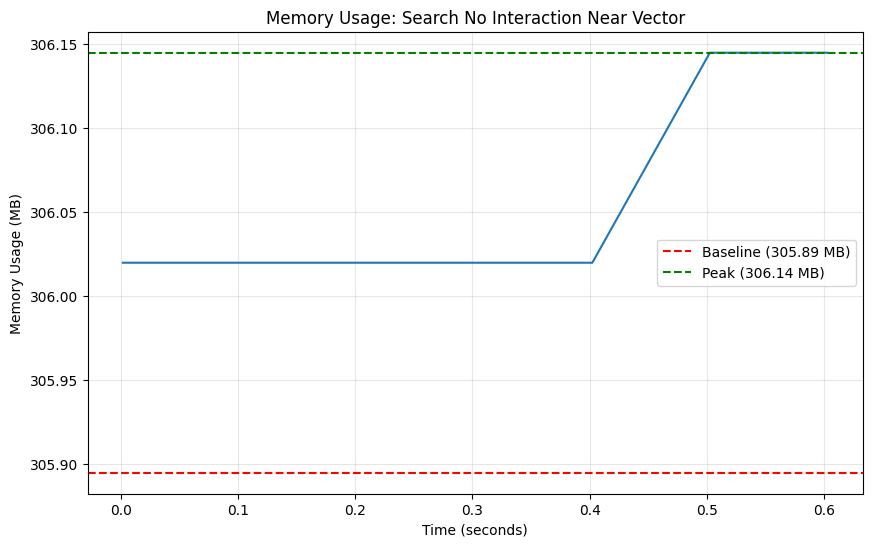


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 306.14 MB
Peak Memory: 306.14 MB
Memory Increase: 0.00 MB
Execution Time: 0.51 seconds

Memory plot saved to search_no_interaction_near_vector.png


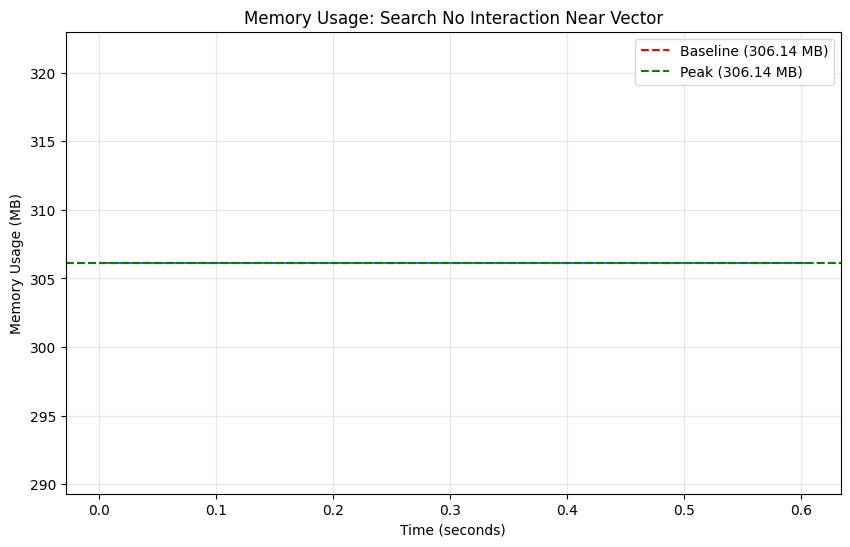


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 308.52 MB
Peak Memory: 308.64 MB
Memory Increase: 0.12 MB
Execution Time: 0.53 seconds

Memory plot saved to search_no_interaction_near_vector.png


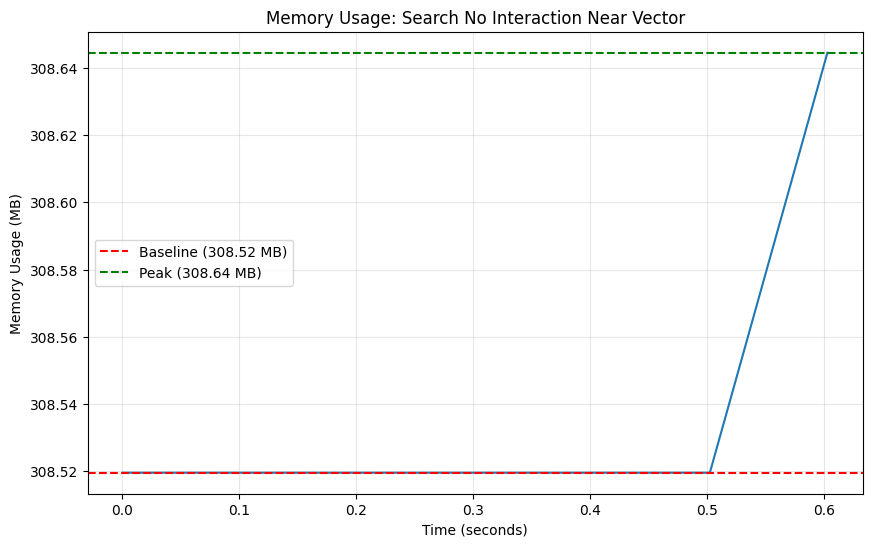


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.75 MB
Peak Memory: 299.87 MB
Memory Increase: 0.12 MB
Execution Time: 0.55 seconds

Memory plot saved to search_no_interaction_near_vector.png


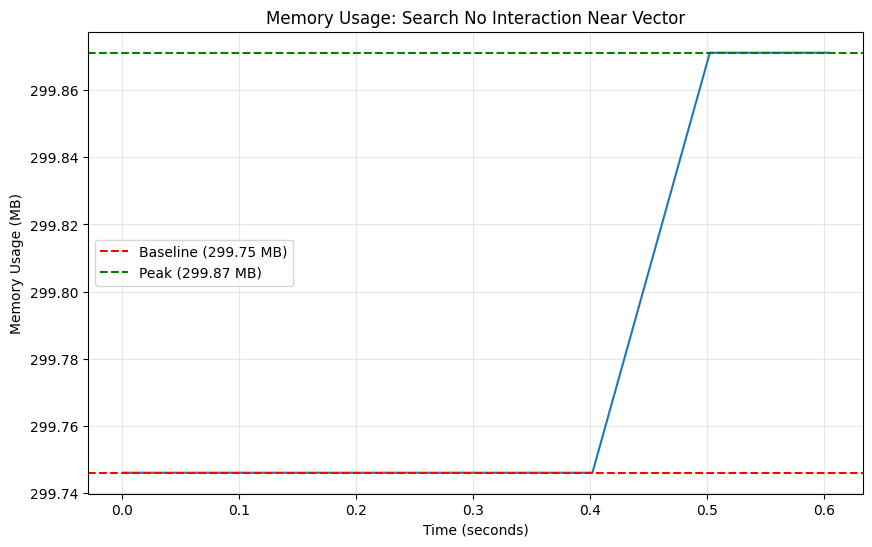


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.87 MB
Peak Memory: 299.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.45 seconds

Memory plot saved to search_no_interaction_near_vector.png


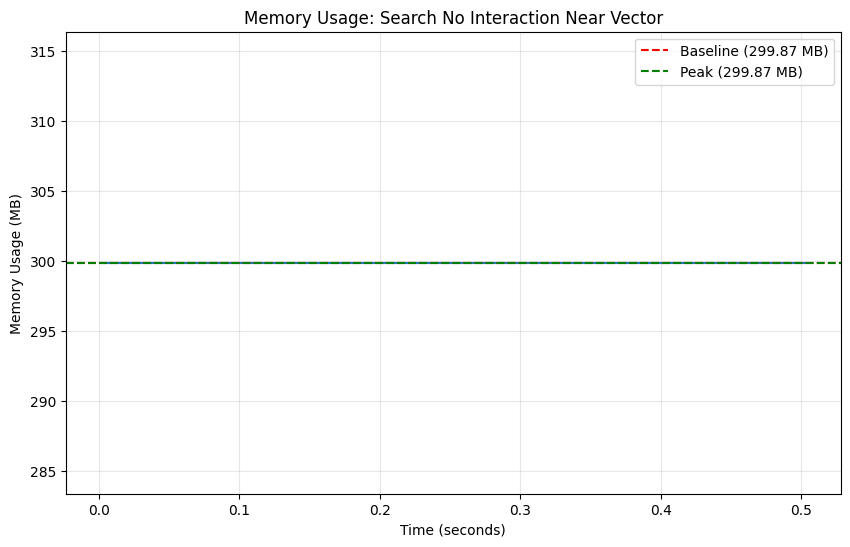


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.87 MB
Peak Memory: 299.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.50 seconds

Memory plot saved to search_no_interaction_near_vector.png


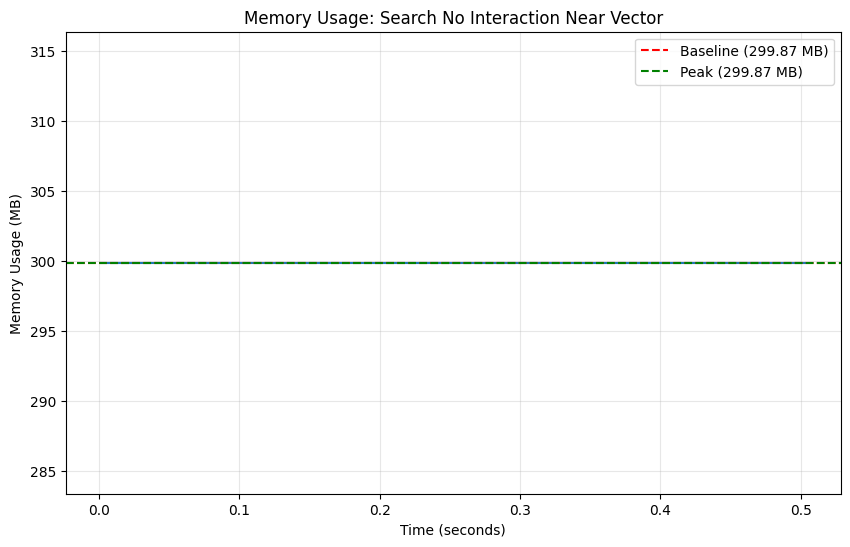


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.87 MB
Peak Memory: 299.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.50 seconds

Memory plot saved to search_no_interaction_near_vector.png


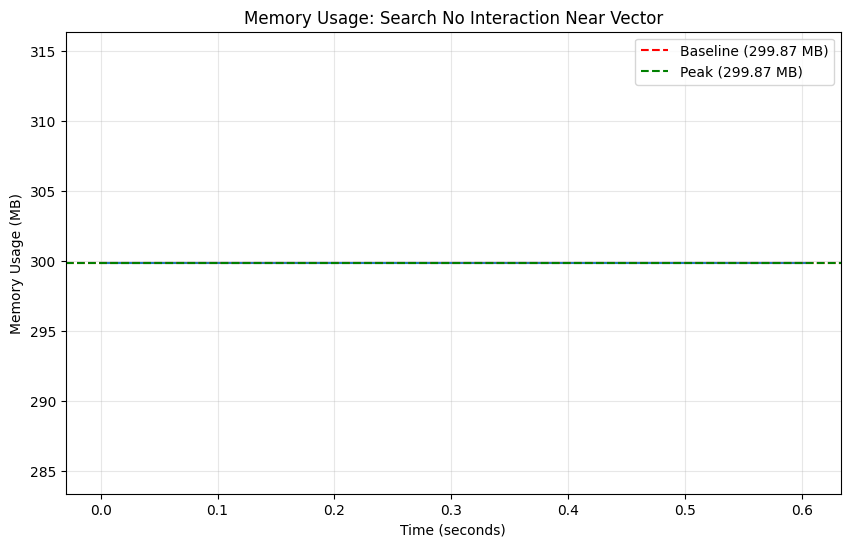


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.87 MB
Peak Memory: 299.87 MB
Memory Increase: 0.00 MB
Execution Time: 1.20 seconds

Memory plot saved to search_no_interaction_near_vector.png


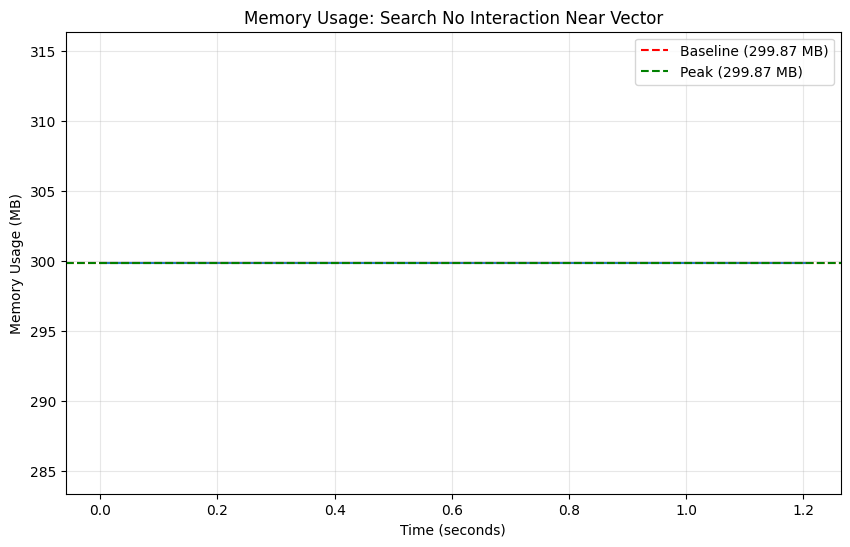


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.87 MB
Peak Memory: 299.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.73 seconds

Memory plot saved to search_no_interaction_near_vector.png


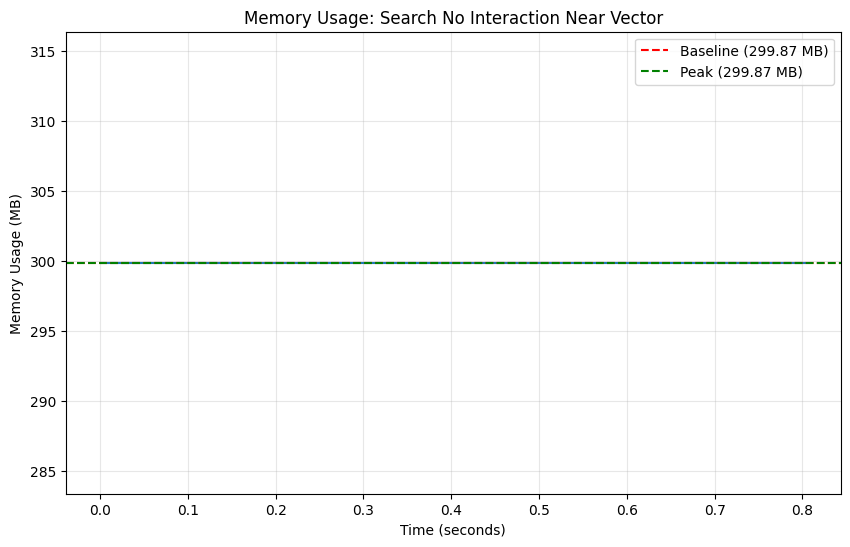


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.87 MB
Peak Memory: 299.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.47 seconds

Memory plot saved to search_no_interaction_near_vector.png


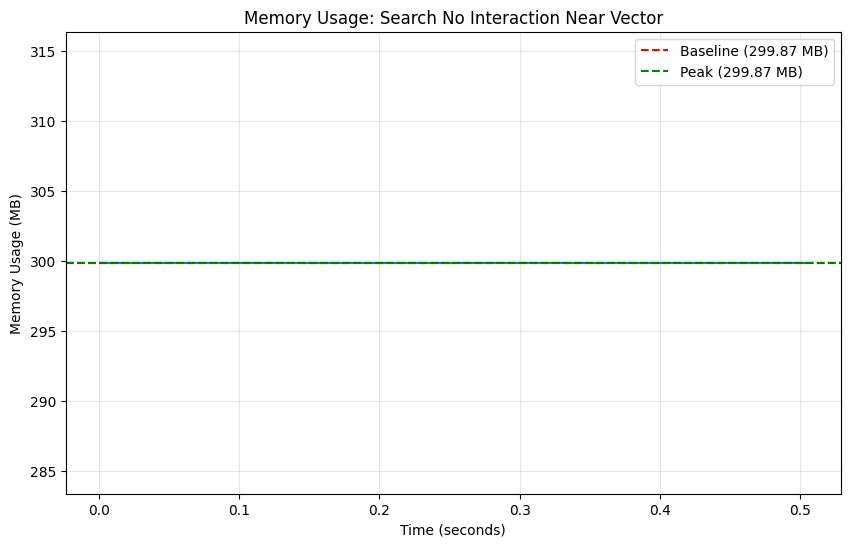


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.87 MB
Peak Memory: 299.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.57 seconds

Memory plot saved to search_no_interaction_near_vector.png


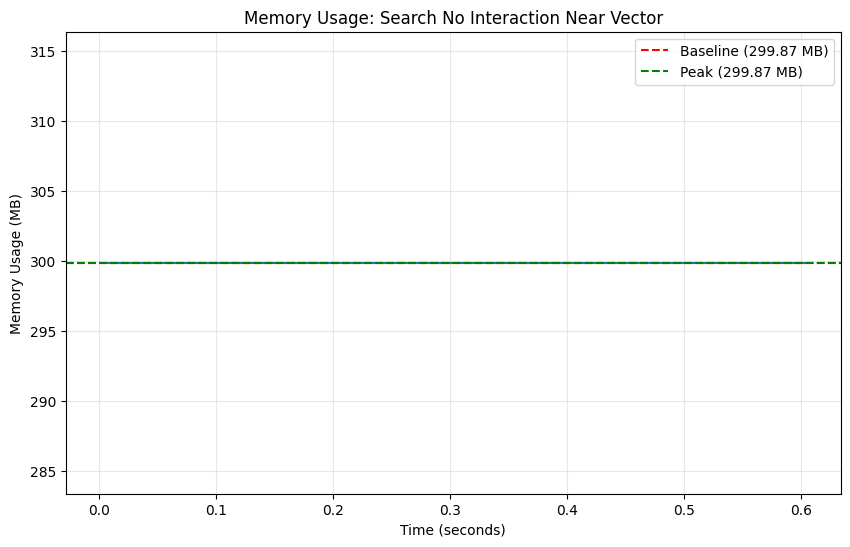


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.87 MB
Peak Memory: 299.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.55 seconds

Memory plot saved to search_no_interaction_near_vector.png


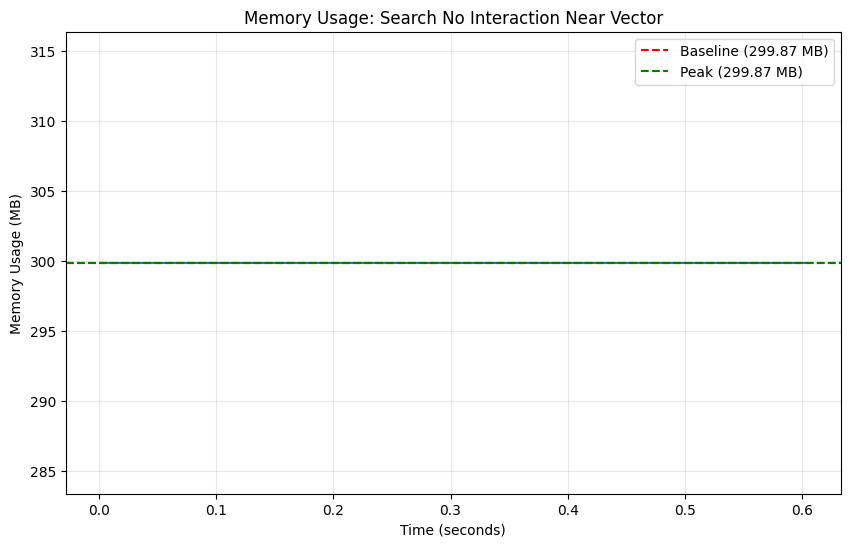


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.87 MB
Peak Memory: 299.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.50 seconds

Memory plot saved to search_no_interaction_near_vector.png


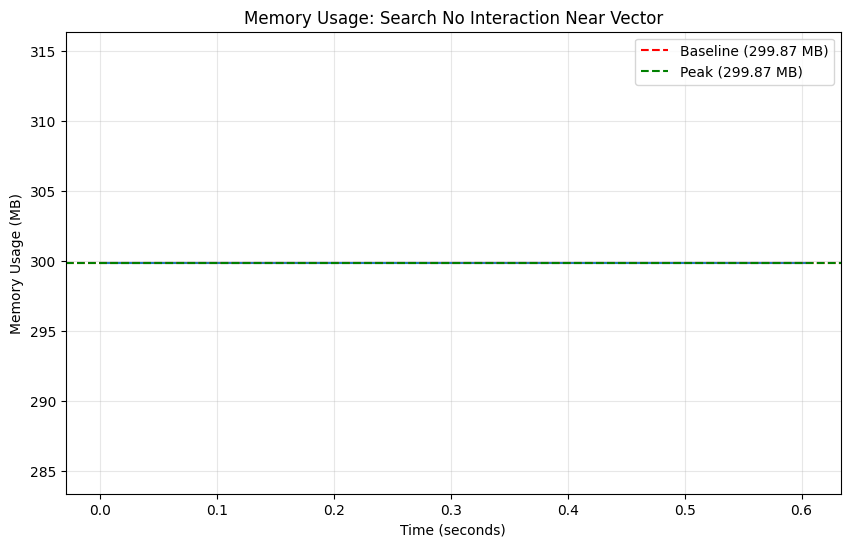


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.87 MB
Peak Memory: 299.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.76 seconds

Memory plot saved to search_no_interaction_near_vector.png


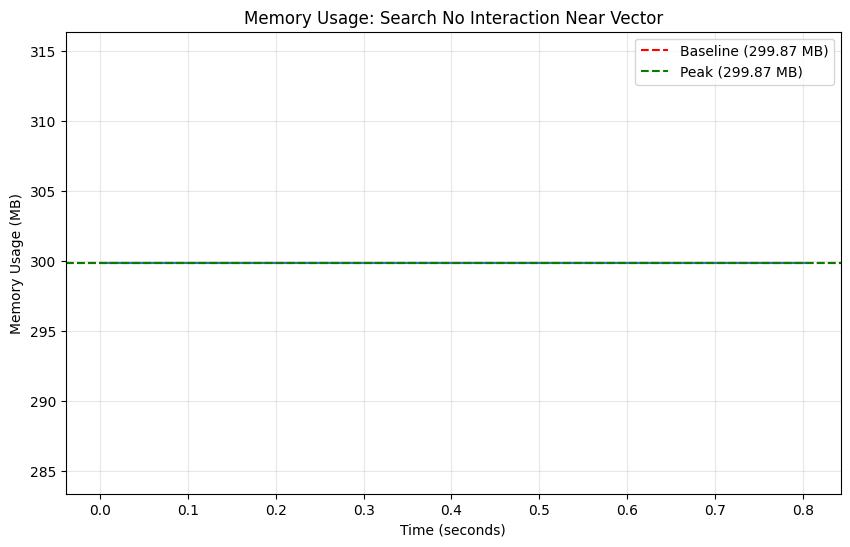


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.87 MB
Peak Memory: 299.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.46 seconds

Memory plot saved to search_no_interaction_near_vector.png


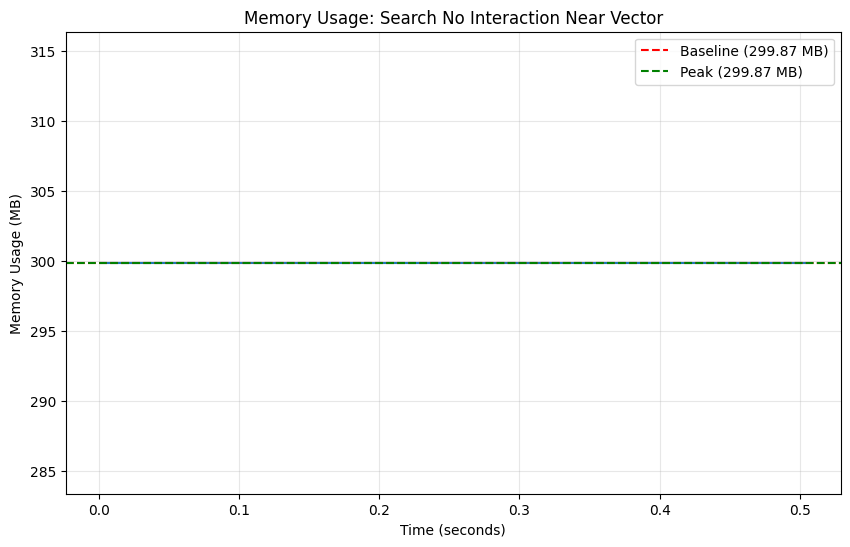


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.87 MB
Peak Memory: 299.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.50 seconds

Memory plot saved to search_no_interaction_near_vector.png


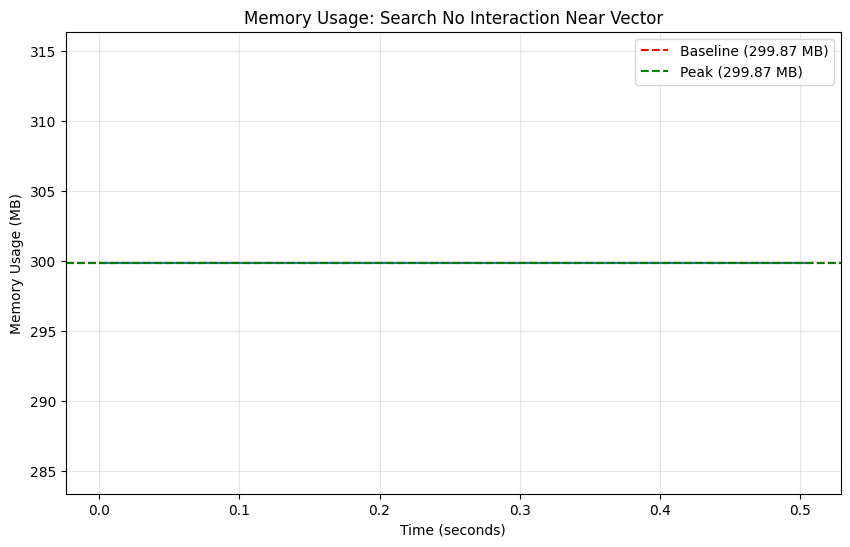


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.87 MB
Peak Memory: 299.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.49 seconds

Memory plot saved to search_no_interaction_near_vector.png


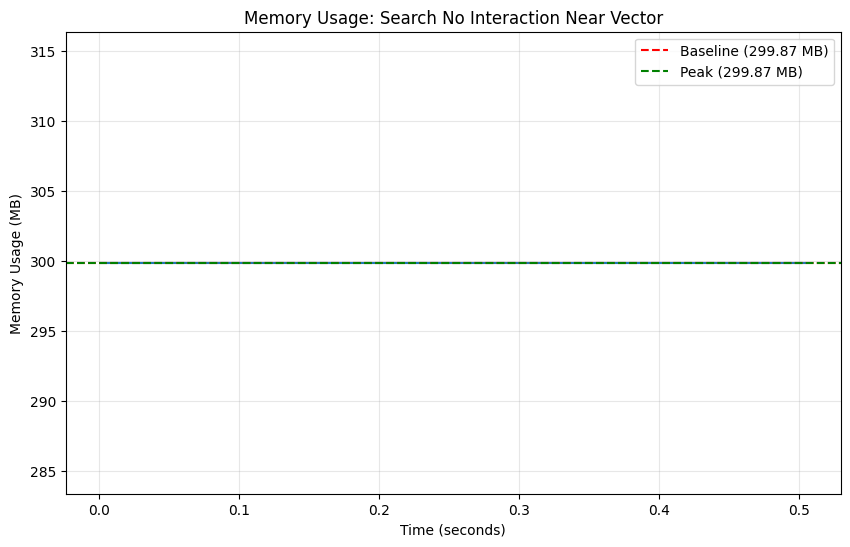


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.87 MB
Peak Memory: 299.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.41 seconds

Memory plot saved to search_no_interaction_near_vector.png


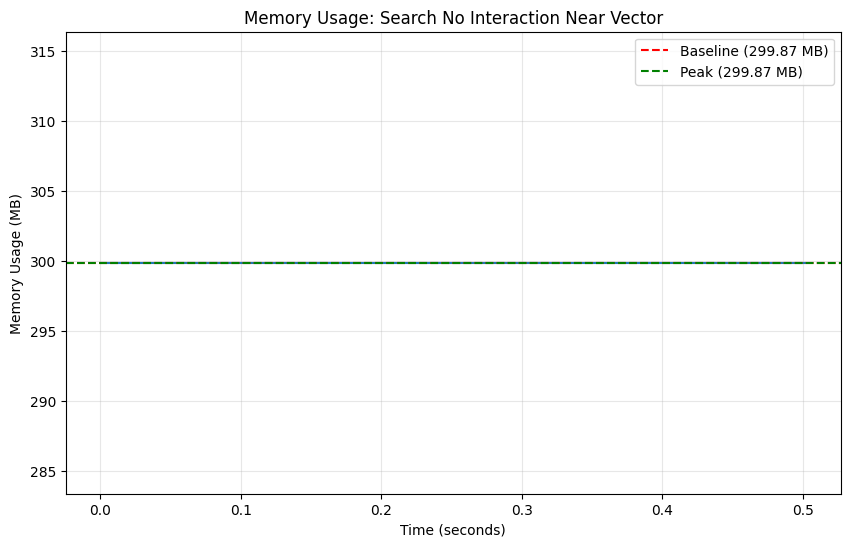


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 299.87 MB
Peak Memory: 299.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.50 seconds

Memory plot saved to search_no_interaction_near_vector.png


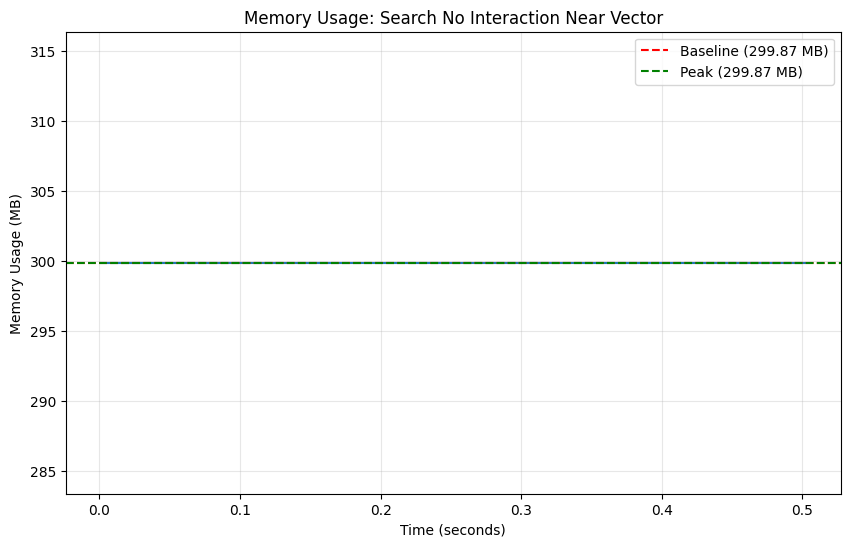


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.00 MB
Peak Memory: 300.00 MB
Memory Increase: 0.00 MB
Execution Time: 0.36 seconds

Memory plot saved to search_no_interaction_near_vector.png


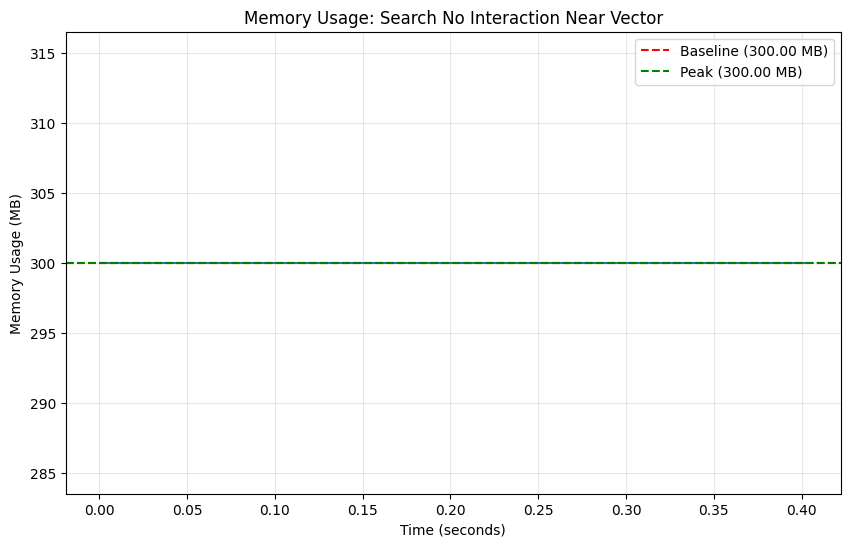


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.00 MB
Peak Memory: 300.12 MB
Memory Increase: 0.12 MB
Execution Time: 0.39 seconds

Memory plot saved to search_no_interaction_near_vector.png


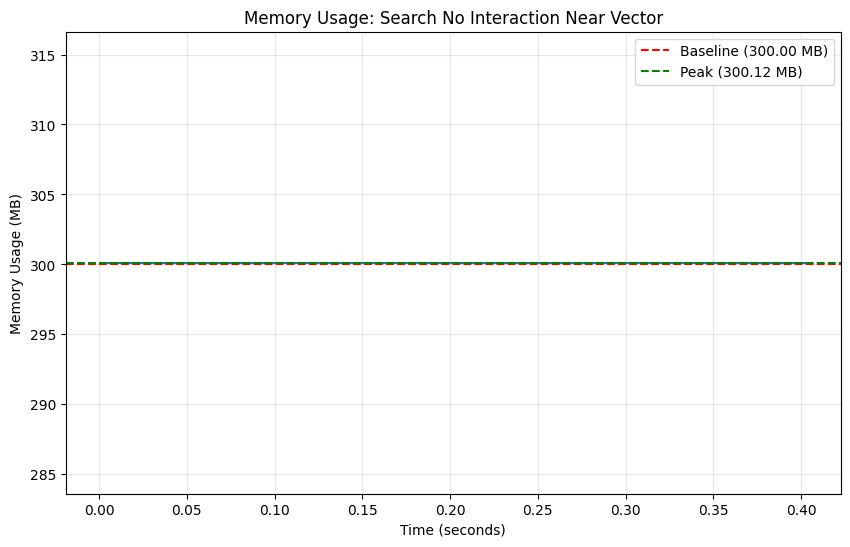


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.12 MB
Peak Memory: 300.12 MB
Memory Increase: 0.00 MB
Execution Time: 1.77 seconds

Memory plot saved to search_no_interaction_near_vector.png


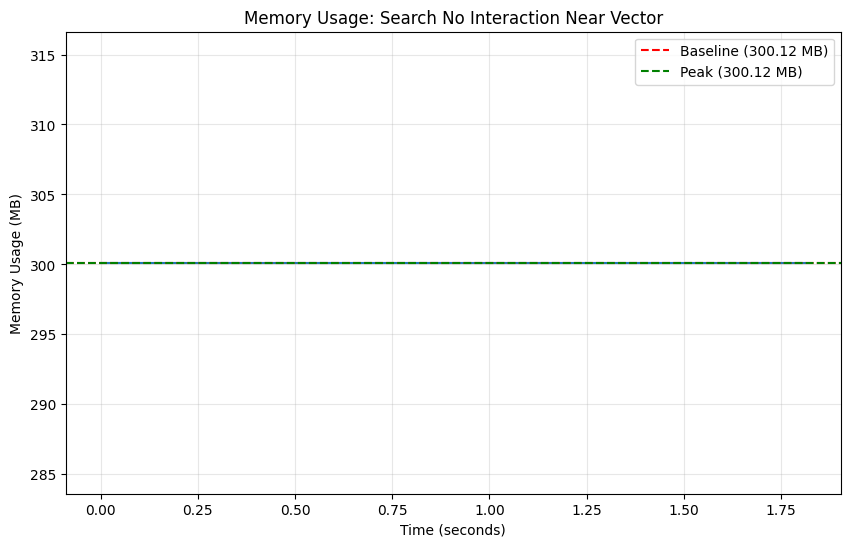


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.37 MB
Peak Memory: 300.37 MB
Memory Increase: 0.00 MB
Execution Time: 0.42 seconds

Memory plot saved to search_no_interaction_near_vector.png


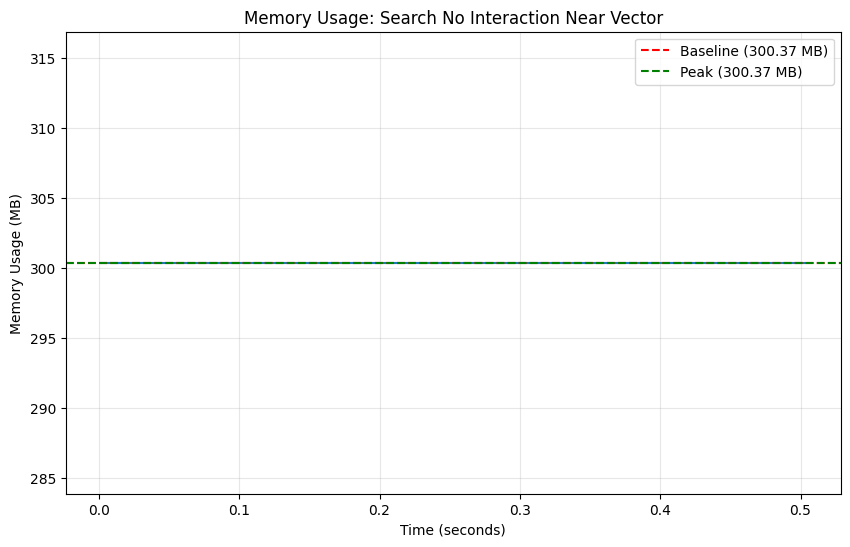


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 301.37 MB
Peak Memory: 301.37 MB
Memory Increase: 0.00 MB
Execution Time: 0.50 seconds

Memory plot saved to search_no_interaction_near_vector.png


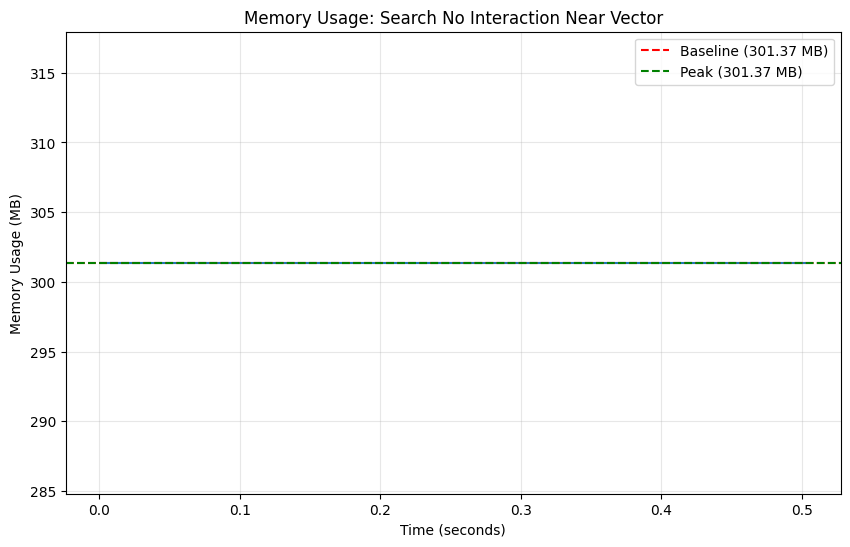


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 301.37 MB
Peak Memory: 301.37 MB
Memory Increase: 0.00 MB
Execution Time: 0.47 seconds

Memory plot saved to search_no_interaction_near_vector.png


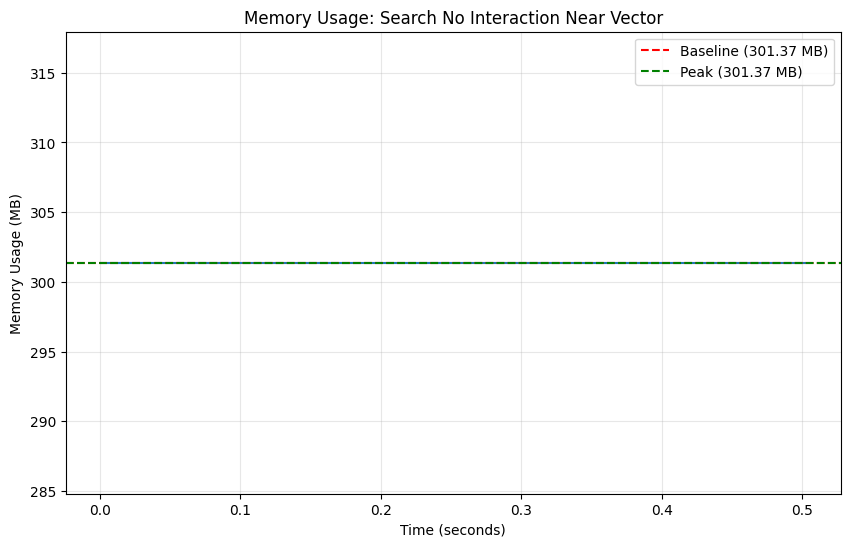


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 303.00 MB
Peak Memory: 303.00 MB
Memory Increase: 0.00 MB
Execution Time: 0.48 seconds

Memory plot saved to search_no_interaction_near_vector.png


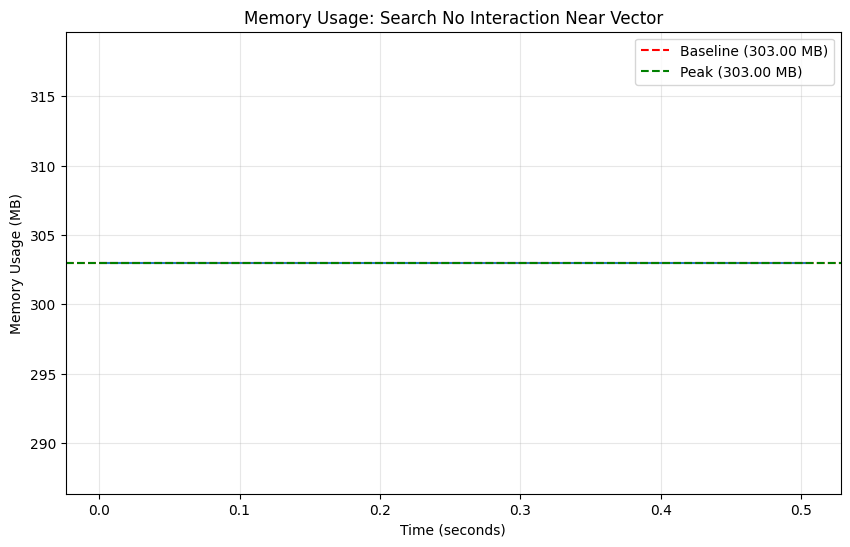


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 303.12 MB
Peak Memory: 303.12 MB
Memory Increase: 0.00 MB
Execution Time: 0.55 seconds

Memory plot saved to search_no_interaction_near_vector.png


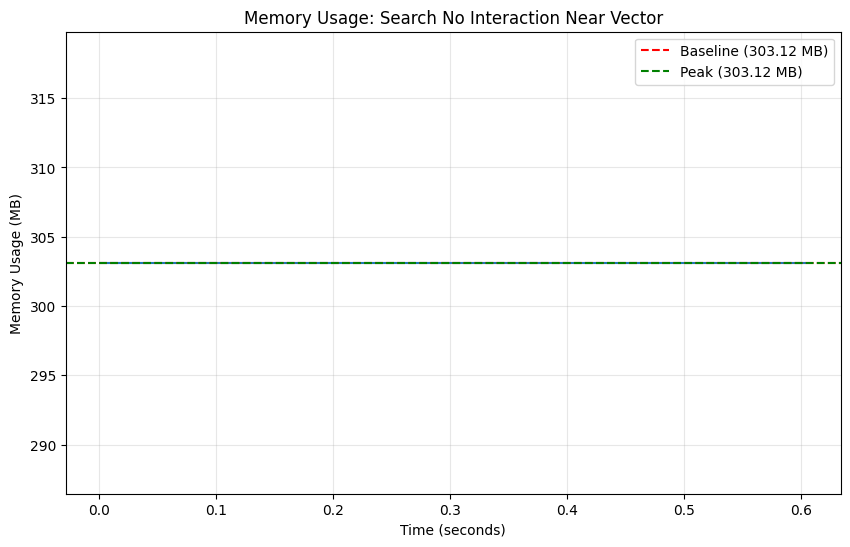


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 304.87 MB
Peak Memory: 304.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.39 seconds

Memory plot saved to search_no_interaction_near_vector.png


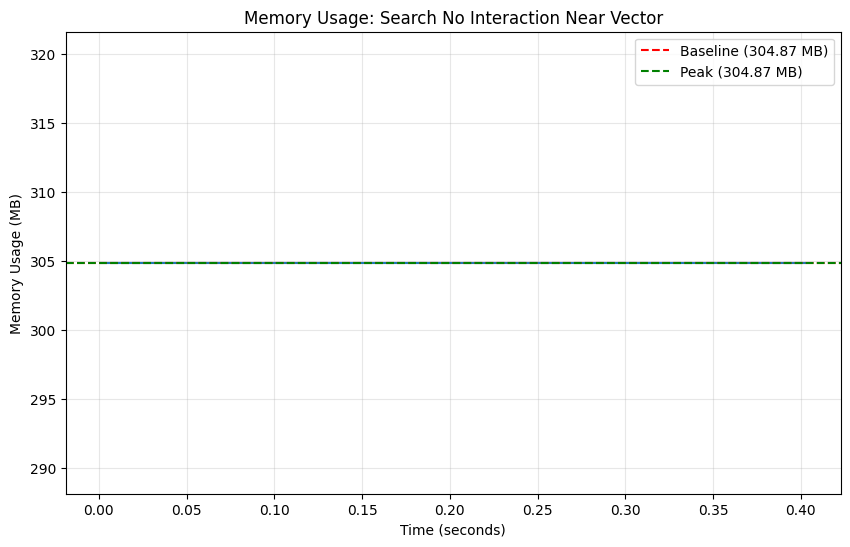


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 304.87 MB
Peak Memory: 304.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.56 seconds

Memory plot saved to search_no_interaction_near_vector.png


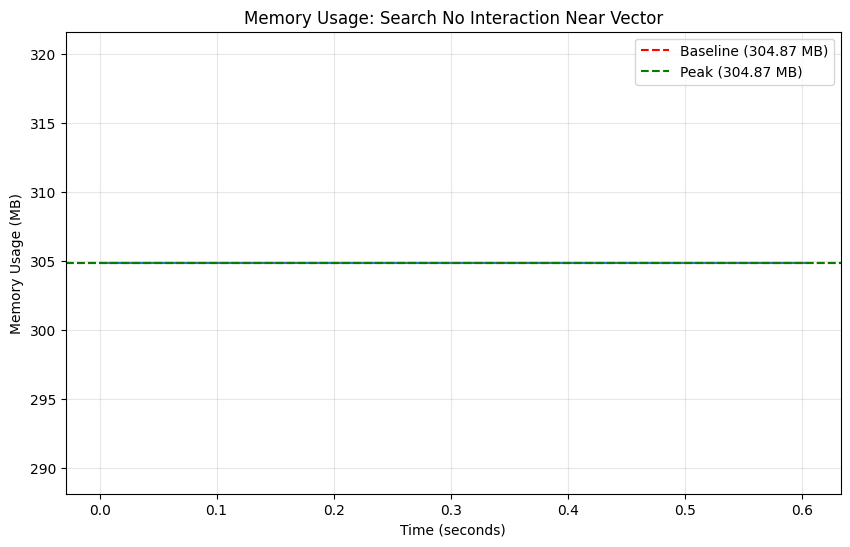


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 306.75 MB
Peak Memory: 306.75 MB
Memory Increase: 0.00 MB
Execution Time: 0.46 seconds

Memory plot saved to search_no_interaction_near_vector.png


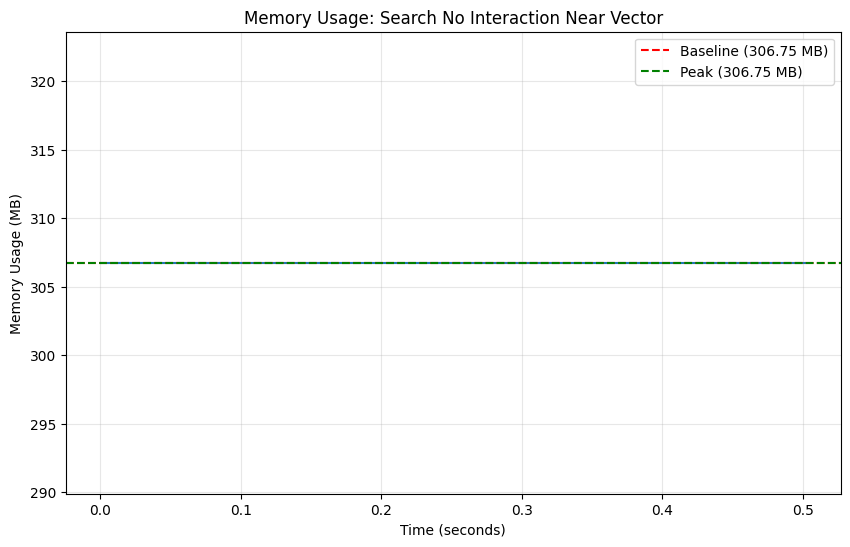


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 308.62 MB
Peak Memory: 308.62 MB
Memory Increase: 0.00 MB
Execution Time: 0.42 seconds

Memory plot saved to search_no_interaction_near_vector.png


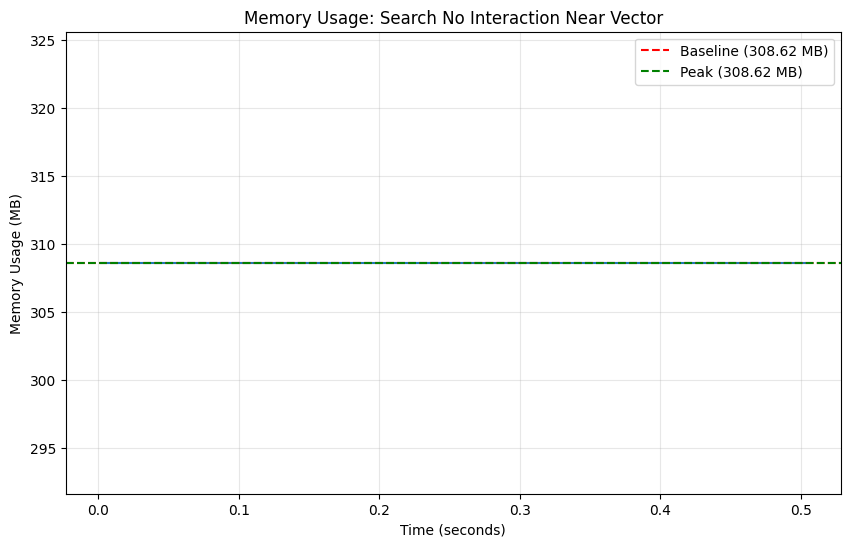


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 308.87 MB
Peak Memory: 308.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.44 seconds

Memory plot saved to search_no_interaction_near_vector.png


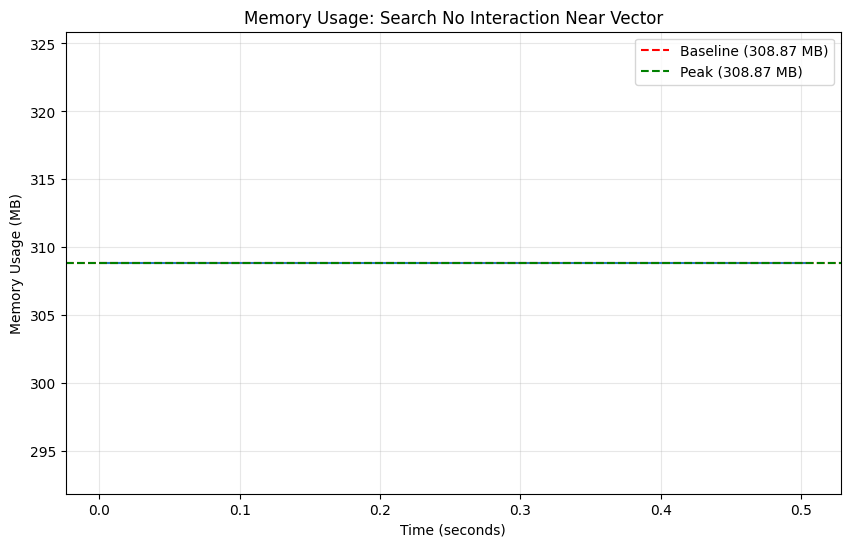


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 310.87 MB
Peak Memory: 310.87 MB
Memory Increase: 0.00 MB
Execution Time: 0.76 seconds

Memory plot saved to search_no_interaction_near_vector.png


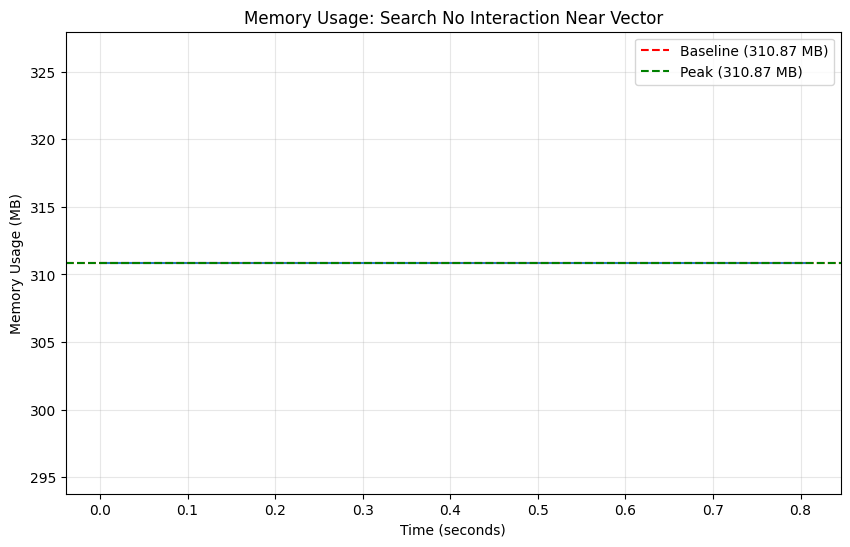


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.52 seconds

Memory plot saved to search_no_interaction_near_vector.png


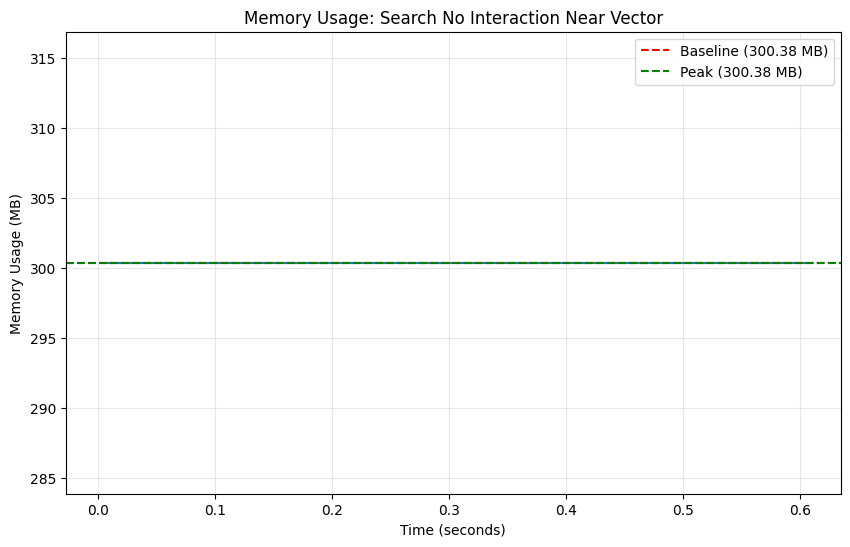


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.43 seconds

Memory plot saved to search_no_interaction_near_vector.png


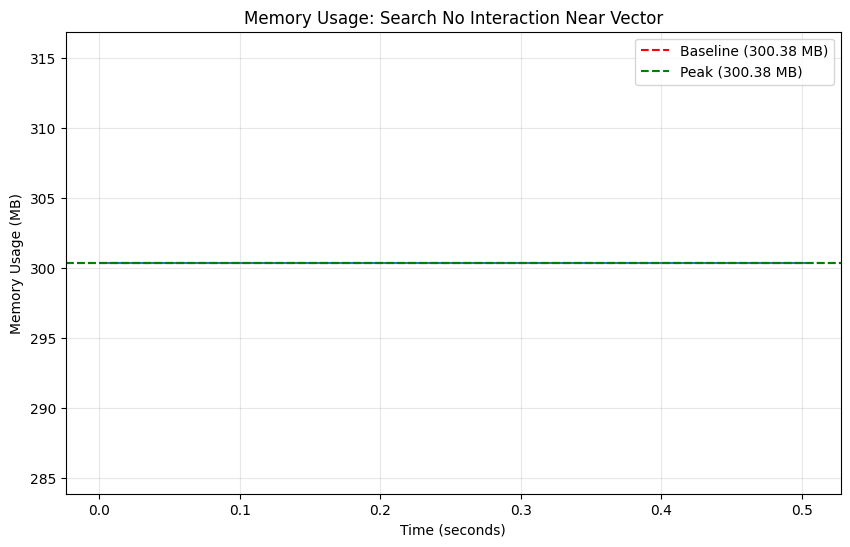


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.65 seconds

Memory plot saved to search_no_interaction_near_vector.png


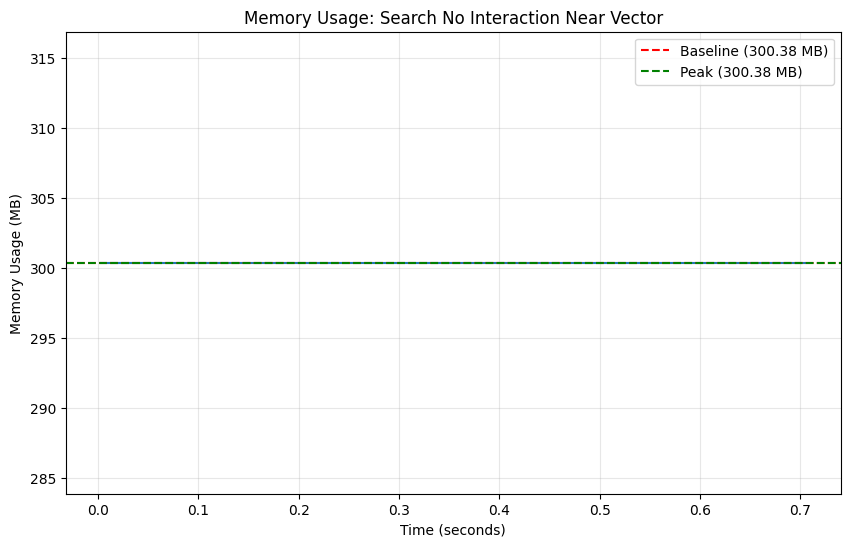


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.52 seconds

Memory plot saved to search_no_interaction_near_vector.png


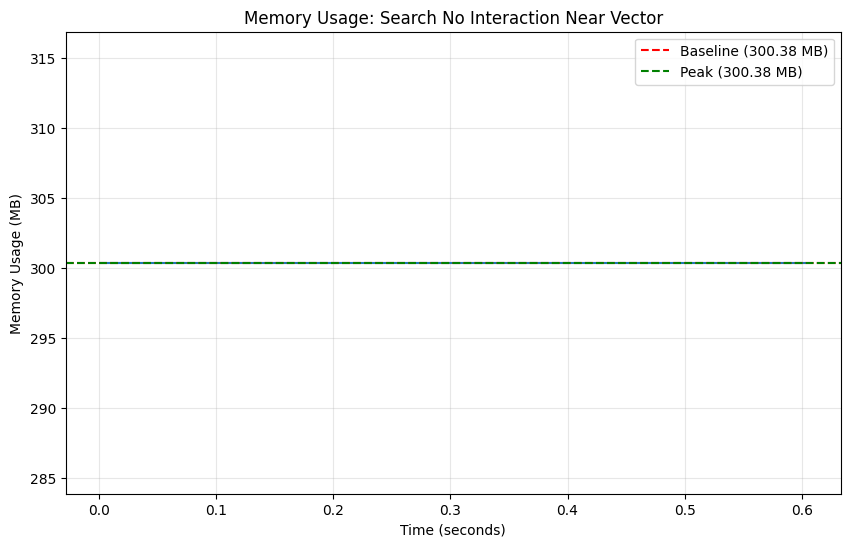


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.35 seconds

Memory plot saved to search_no_interaction_near_vector.png


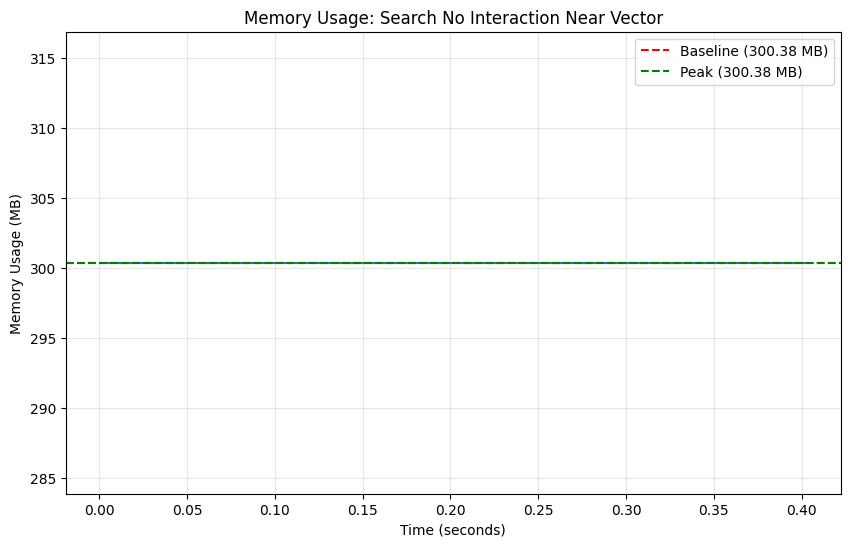


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.45 seconds

Memory plot saved to search_no_interaction_near_vector.png


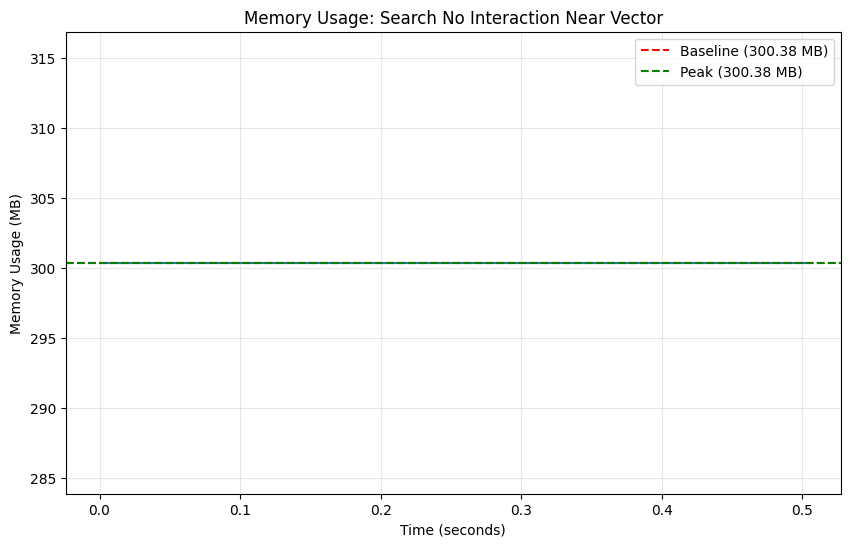


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.46 seconds

Memory plot saved to search_no_interaction_near_vector.png


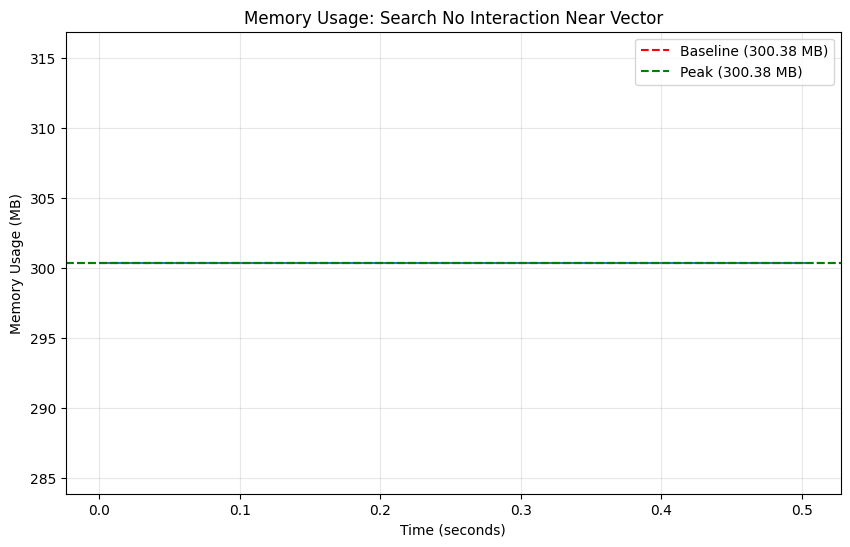


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.47 seconds

Memory plot saved to search_no_interaction_near_vector.png


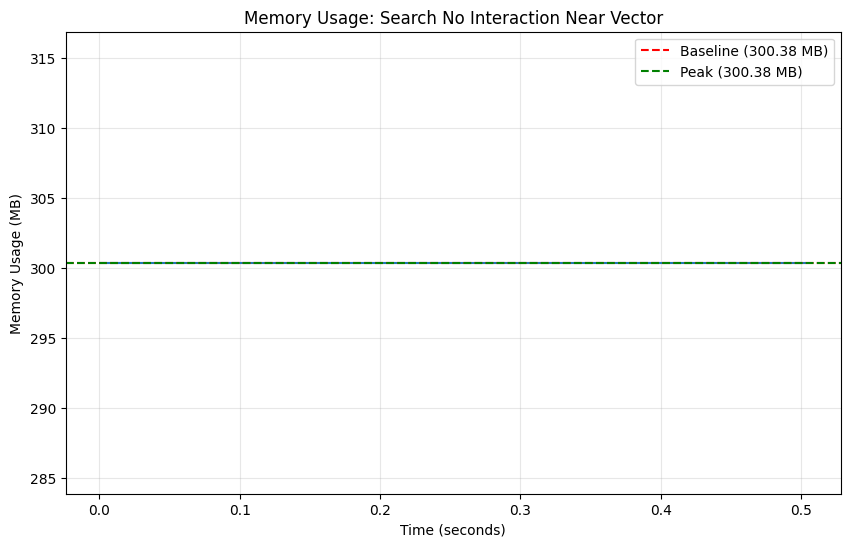


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.44 seconds

Memory plot saved to search_no_interaction_near_vector.png


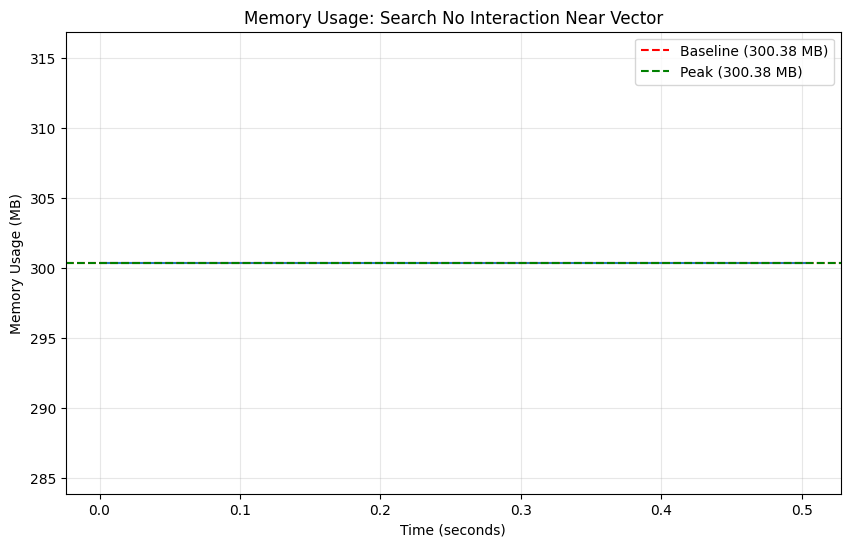


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.48 seconds

Memory plot saved to search_no_interaction_near_vector.png


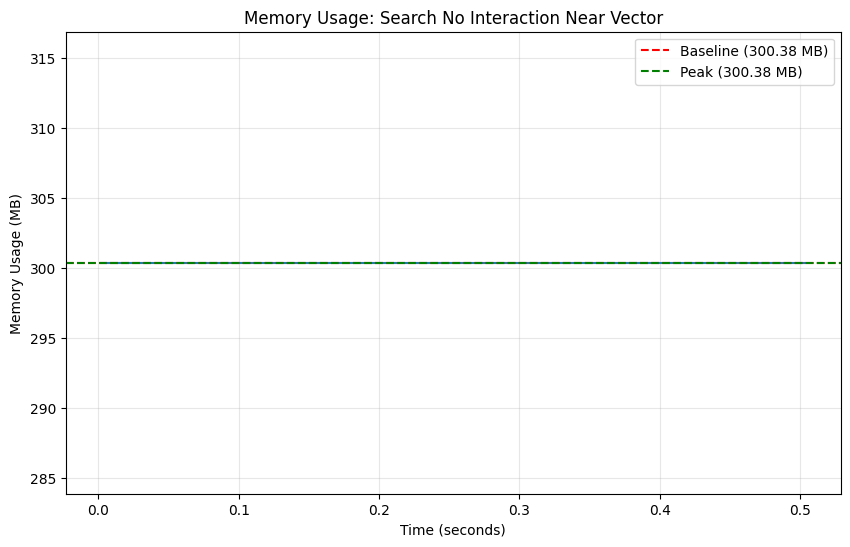


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.40 seconds

Memory plot saved to search_no_interaction_near_vector.png


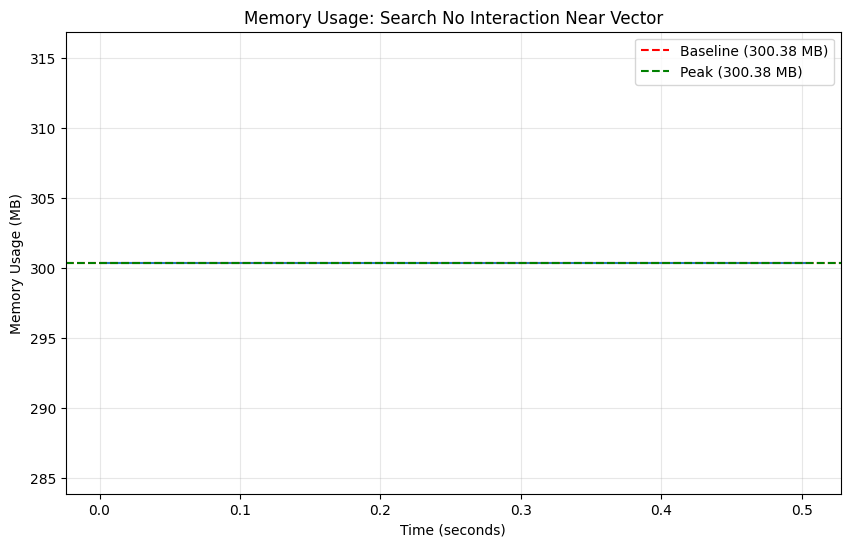


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.38 seconds

Memory plot saved to search_no_interaction_near_vector.png


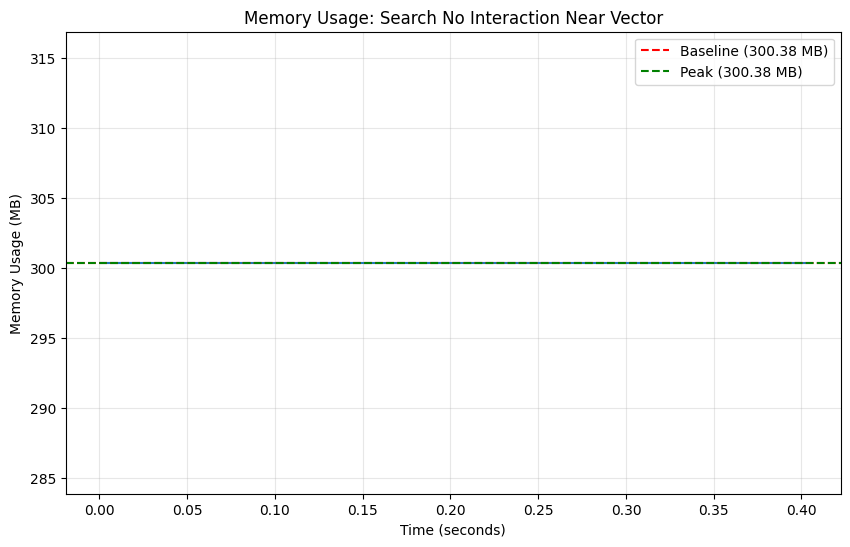


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.39 seconds

Memory plot saved to search_no_interaction_near_vector.png


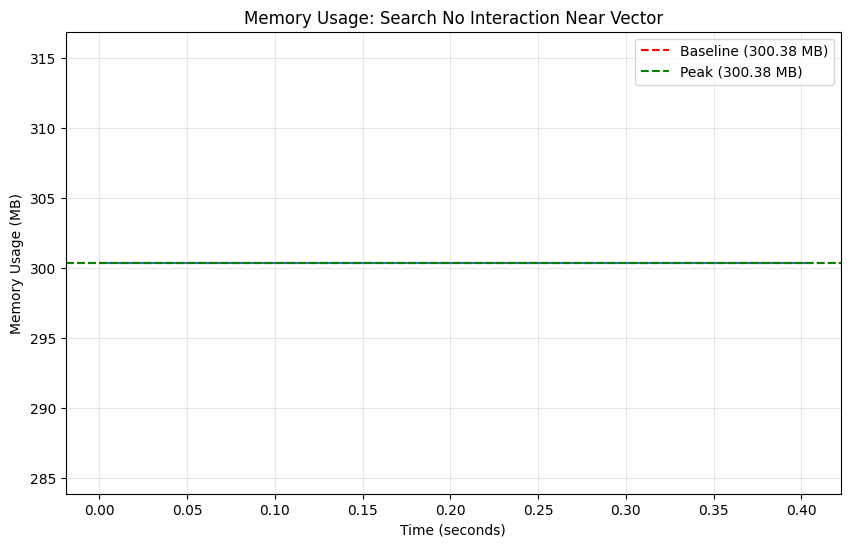


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.43 seconds

Memory plot saved to search_no_interaction_near_vector.png


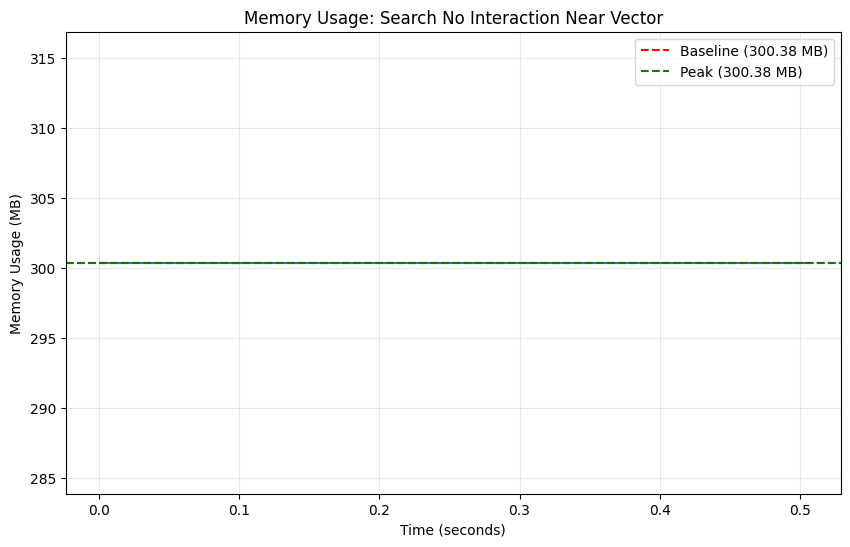


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 1.74 seconds

Memory plot saved to search_no_interaction_near_vector.png


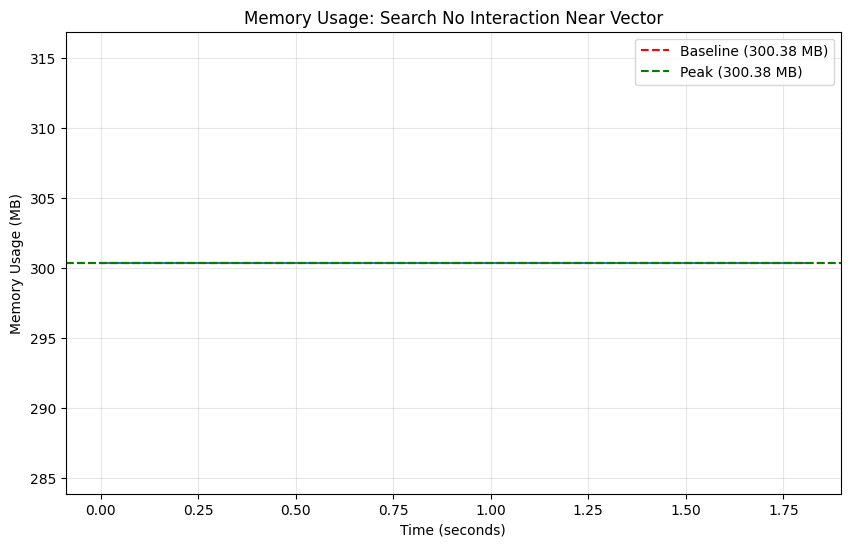


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.47 seconds

Memory plot saved to search_no_interaction_near_vector.png


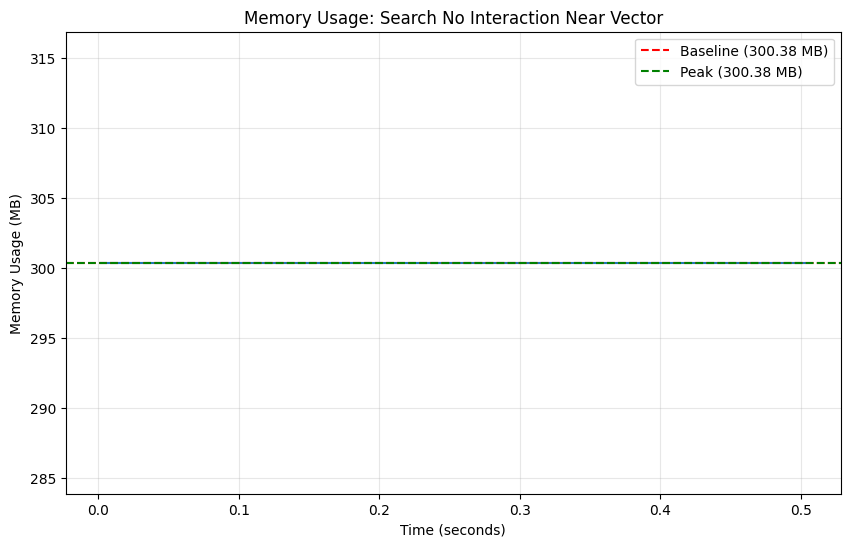


Memory Usage for Search No Interaction Near Vector:
Baseline Memory: 300.38 MB
Peak Memory: 300.38 MB
Memory Increase: 0.00 MB
Execution Time: 0.47 seconds

Memory plot saved to search_no_interaction_near_vector.png


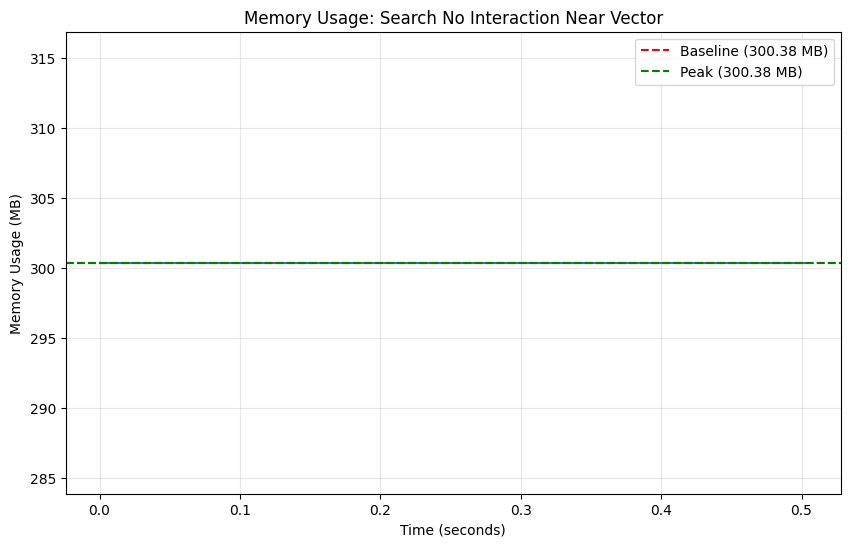

Average search time: 0.5535 seconds
NDCG: 
  - NDCG@1 = 0.66
  - NDCG@3 = 0.69
  - NDCG@5 = 0.72
  - NDCG@10 = 0.78
MAP: 
  - MAP@1 = 0.34
  - MAP@3 = 0.62
  - MAP@5 = 0.65
  - MAP@10 = 0.69
Recall: 
  - Recall@1 = 0.34
  - Recall@3 = 0.72
  - Recall@5 = 0.78
  - Recall@10 = 0.93
Precision: 
  - P@1 = 0.66
  - P@3 = 0.49
  - P@5 = 0.34
  - P@10 = 0.2

Results summary:


id                                          question retrieved_count  \
0  237                         apa saja jenis buku fiksi           0 / 3   
1  283  bagaimana cara konfigurasi akses lokasi di mybca           0 / 2   
2  281          bagaimana cara early redemption obligasi           0 / 2   
3  289                 bagaimana cara bayar zakat fitrah           0 / 2   
4   61         bagaimana cara bayar bpjs ketenagakerjaan           0 / 2   

  retrieved_rank search_time  
0              -     0.5188s  
1              -     0.5063s  
2              -     0.5317s  
3              -     0.5527s  
4              -     0.4464s

In [80]:
near_vector_single_vector_result = benchmark_single_vector_search_method(expected_chunk_dict, ground_truth_contexts)

## Comparative Analysis

This section creates a visual comparison of the average execution times between the multi-vector (ColBERT) and single-vector approaches.

### Data Collection
- Aggregates results from both search methods into a unified structure
- Extracts the average execution time for each method from the benchmark results

### Visualization Implementation
- Creates a bar chart comparing execution times across search methods

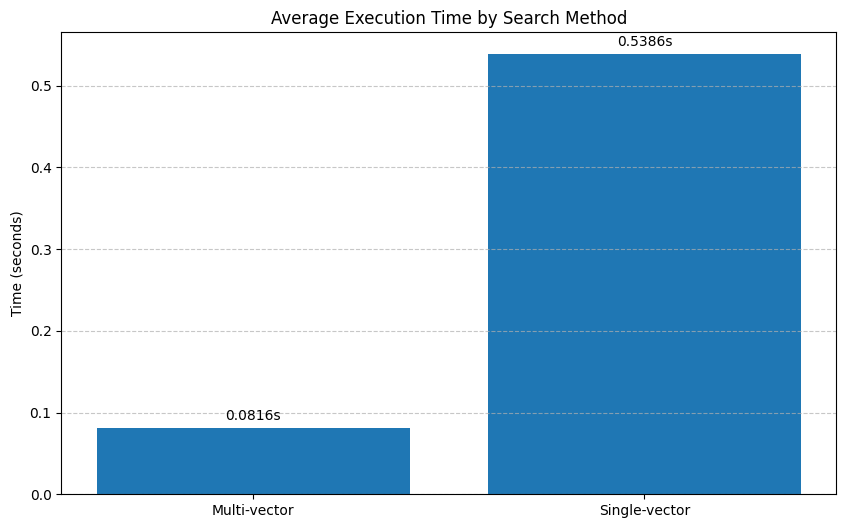

Execution times plot saved to ./results/execution_times.png


<Figure size 640x480 with 0 Axes>

In [70]:
# Collect results
results = {
    "Multi-vector": near_vector_results,
    "Single-vector": near_vector_single_vector_result
}

# Compare execution times
execution_times = {
    method: data["avg_execution_time"]
    for method, data in results.items()
}

plt.figure(figsize=(10, 6))
plt.bar(execution_times.keys(), execution_times.values())
plt.title("Average Execution Time by Search Method")
plt.ylabel("Time (seconds)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(execution_times.values()):
    plt.text(i, v + 0.01, f"{v:.4f}s", ha='center')
plt.show()

# Save the plot
plt.savefig(f"{RESULTS_DIR}/execution_times.png")
print(f"Execution times plot saved to {RESULTS_DIR}/execution_times.png")

Multi-vector  Single-vector
NDCG@1             0.80000        0.66000
NDCG@3             0.74617        0.69303
NDCG@5             0.77703        0.71800
NDCG@10            0.79824        0.77517
MAP@1              0.44467        0.33900
MAP@3              0.67611        0.61906
MAP@5              0.71839        0.64971
MAP@10             0.73238        0.68577
Recall@1           0.44467        0.33900
Recall@3           0.71167        0.71800
Recall@5           0.80733        0.78167
Recall@10          0.85533        0.92533
Precision@1        0.80000        0.66000
Precision@3        0.49333        0.49333
Precision@5        0.34000        0.33600
Precision@10       0.18400        0.19800

<Figure size 1200x800 with 0 Axes>

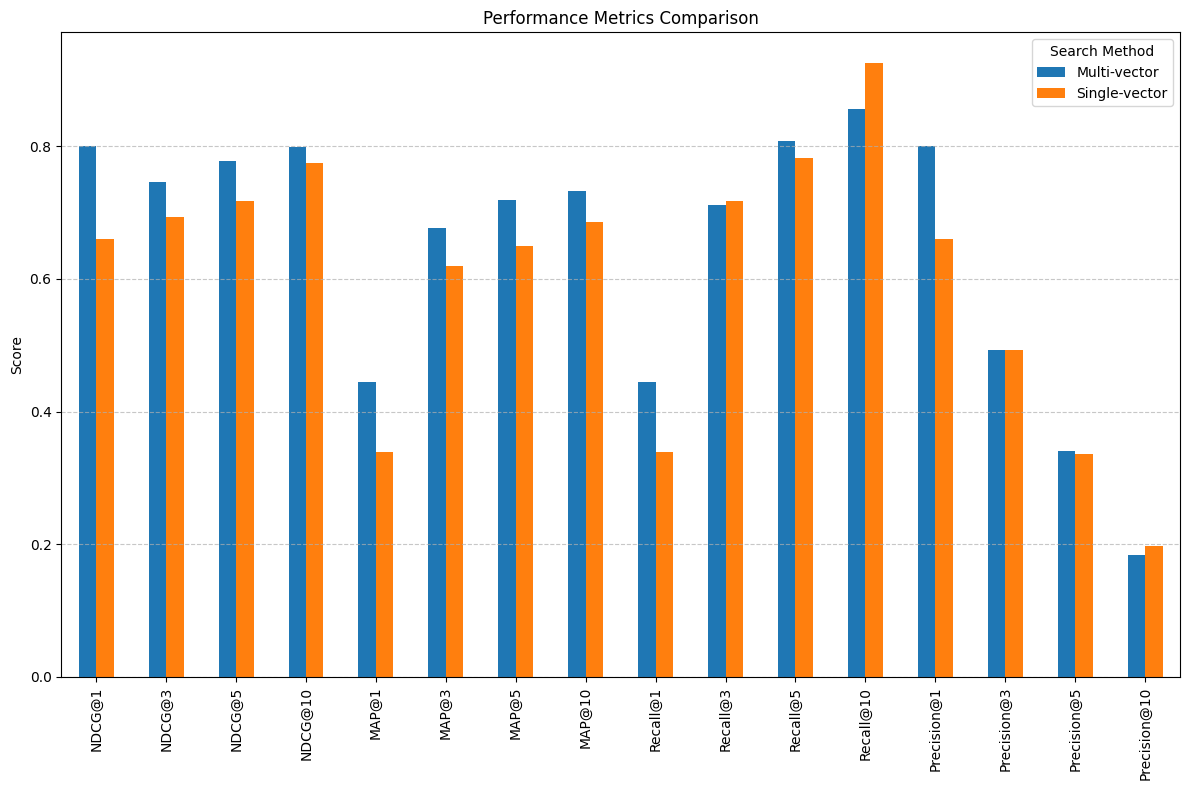

Metrics comparison plot saved to ./results/metrics_comparison.png
Metrics comparison data saved to ./results/metrics_comparison.csv


<Figure size 640x480 with 0 Axes>

In [19]:
# Extract metrics for comparison
metrics_data = {}

for method, data in results.items():
    metrics = data["metrics"]
    metrics_data[method] = {
        # NDCG metrics
        "NDCG@1": metrics["ndcg"].get("NDCG@1", 0),
        "NDCG@3": metrics["ndcg"].get("NDCG@3", 0),
        "NDCG@5": metrics["ndcg"].get("NDCG@5", 0),
        "NDCG@10": metrics["ndcg"].get("NDCG@10", 0),
        
        # MAP metrics
        "MAP@1": metrics["map"].get("MAP@1", 0),
        "MAP@3": metrics["map"].get("MAP@3", 0),
        "MAP@5": metrics["map"].get("MAP@5", 0),
        "MAP@10": metrics["map"].get("MAP@10", 0),
        
        # Recall metrics
        "Recall@1": metrics["recall"].get("Recall@1", 0),
        "Recall@3": metrics["recall"].get("Recall@3", 0),
        "Recall@5": metrics["recall"].get("Recall@5", 0),
        "Recall@10": metrics["recall"].get("Recall@10", 0),
        
        # Precision metrics
        "Precision@1": metrics["precision"].get("P@1", 0),
        "Precision@3": metrics["precision"].get("P@3", 0),
        "Precision@5": metrics["precision"].get("P@5", 0),
        "Precision@10": metrics["precision"].get("P@10", 0)
    }

metrics_df = pd.DataFrame(metrics_data)

# Display the metrics comparison
display(metrics_df)

# Plot the metrics comparison
plt.figure(figsize=(12, 8))
metrics_df.plot(kind="bar", figsize=(12, 8))
plt.title("Performance Metrics Comparison")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Search Method")
plt.tight_layout()
plt.show()

# Save the plot and data
plt.savefig(f"{RESULTS_DIR}/metrics_comparison.png")
metrics_df.to_csv(f"{RESULTS_DIR}/metrics_comparison.csv")
print(f"Metrics comparison plot saved to {RESULTS_DIR}/metrics_comparison.png")
print(f"Metrics comparison data saved to {RESULTS_DIR}/metrics_comparison.csv")

In [81]:
client.close()  

## Conclusion

This notebook has benchmarked the Near-Vector search method using Single Vector and Multi Vector:

We evaluated each method based on standard information retrieval metrics (NDCG, MAP, Recall, Precision) and execution time. The comparative analysis helps identify which search method performs best for the given test dataset.

Key findings:
- Late embedding (multi vector) is faster than early embedding (single vector) in term of query time
- Late embedding (multi vector) is slower than early embedding (single vector) in term of index time
- Late embedding (multi vector) is more accurate than early embedding (single vector) in term of metrics
- Late embedding (multi vector) initial chunking is 2x slower than early embedding (single vector)